The below code implements the textbook definition of the Intrinsic Time-Scale Decomposition algorithm, by Frei and Osorio(2006). Note that the algorithm is patented at the present time(2022) with expiration in two years. The usage of this algorithm for research purposes in certain countries may be restricted.
https://www.oecd.org/science/inno/36311146.pdf 

China, Iceland, Japan, Korea, Mexico, Norway and Turkey, Austria, Belgium, the Czech Republic,
Denmark, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Luxembourg, the Netherlands,
Poland, Portugal, Slovakia, Spain, Sweden and the United Kingdom all have research exeptions or legal constraints to the rights of patent owners that provide for the use in research(but not commercially) of patented code.

However, in the United States ,‘formal research enjoys no absolute protection from infringement liability regardless of the institutional venue, the purpose of the inquiry, the origin of the patented inventions, or the use that is made of them'.As a result, your usage of this algorithm carries with it strict liability concerns and your incorporation of it into your work must be limited to research publications of a strictly academic nature- that is to say, you may make publications relating to this algorithm, but you may not for any purpose make software based upon it or incorporate it into other packages until the license has expired. For those interested in obtaining a license, I suggest contacting flint hills scientific by mail at 5040 Bob Billings Pkwy, Ste A, Lawrence, KS 66049-3843

In [17]:
#!/usr/bin/python
# coding: UTF-8
#
# Author:  Chronum94, Falsywichnet, template and some code shamelessly copied from Dawid Laszuk

#!/usr/bin/python
# coding: UTF-8
#
# Author:  Chronum94, Falsywichnet, template shamelessly copied from Dawid Laszuk
# Contact:  https://github.com/falsywinchnet/PyITD/issues
#
# Feel free to contact for any information.

import logging
from typing import Optional, Tuple

import numpy
import numba

FindExtremaOutput = Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]

@numba.njit(numba.boolean[:](numba.int64[:],numba.int64[:]),parallel=True)
def isin(a, b):
        out=numpy.empty(a.shape[0], dtype=numba.boolean)
        b = set(b)
        for i in numba.prange(a.shape[0]):
            if a[i] in b:
                out[i]=True
            else:
                out[i]=False
        return out
@numba.njit(numba.int64[:](numba.float64[:]))
def detect_peaks(x: list[float]):
    """Detect peaks in data based on their amplitude and other features.
    warning: this code is an optimized copy of the "Marcos Duarte, https://github.com/demotu/BMC"
    matlab compliant detect peaks function intended for use with data sets that only want
    rising edge and is optimized for numba. experiment with it at your own peril.
    """
    # find indexes of all peaks
    x = numpy.asarray(x)
    if len(x) < 3:
        return numpy.empty(1, numpy.int64)
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = numpy.where(numpy.isnan(x))[0]
    indl = numpy.asarray(indnan)

    if indl.size!= 0:
        x[indnan] = numpy.inf
        dx[numpy.where(numpy.isnan(dx))[0]] = numpy.inf

    vil = numpy.zeros(dx.size + 1)
    vil[:-1] = dx[:]# hacky solution because numba does not like hstack tuple arrays
    #numpy.asarray((dx[:], [0.]))# hacky solution because numba does not like hstack
    vix = numpy.zeros(dx.size + 1)
    vix[1:] = dx[:]

    ind = numpy.unique(numpy.where((vil <= 0) & (vix > 0))[0])

            
    rx = numpy.append(dx,[dx[-1] + 1])
    arr_diff = numpy.diff(rx)
    res_mask = arr_diff == 0
    arr_diff_zero_right = numpy.nonzero(res_mask)[0] + 1
    res_mask[arr_diff_zero_right] = True
    repeating = numpy.nonzero(res_mask)[0]
    rset = set(repeating)
    if len(repeating)!= 0: #if there are repeating elements:
        for each in range(len(ind)):
            if ind[each] in rset: #is this a repeating index?
                ind[each] = numpy.argmax(dx[ind[each]:] != dx[ind[each]]) -1 #if so, set it to the rightmost value.
    #this adjustment is intended to implement "rightmost value of flat peaks" efficiently.    
    #https://arxiv.org/pdf/1404.3827v1.pdf page 3 - always take right-most sample
        
    # handle NaN's
    # NaN's and values close to NaN's cannot be peaks
    if ind.size and indl.size:
        outliers = numpy.unique(numpy.concatenate((indnan, indnan - 1, indnan + 1)))
        booloutliers = isin(ind, outliers)
        booloutliers = numpy.invert(booloutliers)
        ind = ind[booloutliers]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
        
    #eliminate redundant values
    return numpy.unique(ind)

#TODO: implement end knots optional
@numba.jit(numba.types.Tuple((numba.float64[:],numba.float64[:]))(numba.float64[:]))
def itd_baseline_extract(data: list[numpy.float64])-> Tuple[numpy.ndarray, numpy.ndarray]:

        x = numpy.asarray(data,dtype=numpy.float64)
        rotation = numpy.zeros_like(x)

        alpha=0.5
        # signal.find_peaks_cwt(x, 1)
        idx_max =numpy.asarray(detect_peaks(x))
        idx_min= numpy.asarray(detect_peaks(-x))
        val_max = x[idx_max] #get peaks based on indexes
        val_min = x[idx_min]
        val_min= -val_min
    
        num_extrema = len(val_max) + len(val_min)

        extremabuffersize = num_extrema + 2
        extrema_indices = numpy.zeros(extremabuffersize, dtype=numpy.int64)
        extrema_indices[1:-1] = numpy.sort(numpy.unique(numpy.hstack((idx_max,idx_min)))) 
        extrema_indices[-1] = len(x) - 1
    
        baseline_knots = numpy.zeros(len(extrema_indices))
        baseline_knots[0] = numpy.mean(x[:2])
        baseline_knots[-1] = numpy.mean(x[-2:])
        #also reflections possible, but should be treated with caution

        #j = extrema_indices, k = k, baseline_knots = B, x =  τ
        for k in range(1, len(extrema_indices) - 1):
            baseline_knots[k] = alpha * (x[extrema_indices[k - 1]] + \
            (extrema_indices[k] - extrema_indices[k - 1]) / (extrema_indices[k + 1] - extrema_indices[k - 1]) * \
            (x[extrema_indices[k + 1]] - x[extrema_indices[k - 1]])) + \
                           alpha * x[extrema_indices[k]]
    
        baseline_new = numpy.zeros_like(x)

        for k in range(0, len(extrema_indices) - 1):
            baseline_new[extrema_indices[k]:extrema_indices[k + 1]] = baseline_knots[k]  + \
            (baseline_knots[k + 1] - baseline_knots[k]) / (x[extrema_indices[k + 1]] - x[extrema_indices[k]]) * \
            (x[extrema_indices[k]:extrema_indices[k + 1]] - x[extrema_indices[k]])
    
        rotation[:] = numpy.subtract(x, baseline_new)

        return rotation[:] , baseline_new[:]
    
class ITD:
    """
    .. _ITD:
    **Intrinsic Time-Scale Decomposition**
    Method of decomposing signal into Intrinsic Baselines (IB)
    based on algorithm presented in Frei et al. [Frei2007]_.
    Algorithm was validated with Restrepo et al. [Restrepo2014]_ simplified algorithm representation.
    Threshold which control the goodness of the decomposition:
        * `end_knots` --- set the end knots. defaults to mean

    References
    ----------
    .. [Frei2007] Frei, Mark G.; Osorio, Ivan (2007). "Intrinsic time-scale decomposition: 
    time–frequency–energy analysis and real-time filtering of non-stationary signals". 
    Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 
    463(2078), 321–342. doi:10.1098/rspa.2006.1761 

    .. [Restrepo2014] Restrepo, Juan M; Venkataramani, Shankar; Comeau, Darin; Flaschka, Hermann (2014). 
    Defining a trend for time series using the intrinsic time-scale decomposition. 
    New Journal of Physics, 16(8), 085004–. doi:10.1088/1367-2630/16/8/085004 
    
    Examples
    --------
    >>> import numpy
    >>> T = numpy.linspace(0, 1, 100)
    >>> S = numpy.sin(2*2*numpy.pi*T)
    >>> itd = ITD(extrema_detection='parabol')
    >>> IB = itd.itd(S)
    >>> IB.shape
    (6, 100)
    """

    #logger = logging.getLogger(__name__)

    def __init__(self, extrema_detection: str = "matlab"):
        """Initiate *ITD* instance.
        Parameters
        ----------
        FIXE : int (default: 0)
        FIXE_H : int (default: 0)
        MAX_ITERATION : int (default 11)
            Maximum number of baselines to decompose
        extrema_detection : str (default 'matlab')
            Method used to finding extrema.
            The matlab method is modified to identify extrema with only one side(plateau) 
            and shift them to the right, per the ITD research paper. Simple and parabola copied from PyEMD
        DTYPE : numpy.dtype (default numpy.float64)
            Data type used.
        Examples
        --------
        >>> itd = ITD(extrema_detection=parabol)
        """
        self.extrema_detection = extrema_detection
        # Declare constants
        assert self.extrema_detection in (
            "simple",
            "parabol",
            "matlab",
        ), "Only 'simple', 'matlab', and 'parabol' values supported"

        self.DTYPE = numpy.float64

        # Instance global declaration
        self.rotations = None  # Optional[numpy.ndarray]
        self.baselines = None  # Optional[numpy.ndarray]

    def __call__(self, S: numpy.ndarray, max_iterations: int = 12) -> numpy.ndarray:
        return self.itd(S, max_iterations=max_iterations)
    
    @staticmethod
    def _not_duplicate(S: numpy.ndarray) -> numpy.ndarray:
        """
        Returns indices for not repeating values, where there is no extremum.
        Example
        -------
        >>> S = [0, 1, 1, 1, 2, 3]
        >>> idx = self._not_duplicate(S)
        [0, 1, 3, 4, 5]
        """
        dup = numpy.r_[S[1:-1] == S[0:-2]] & numpy.r_[S[1:-1] == S[2:]]
        not_dup_idx = numpy.arange(1, len(S) - 1)[~dup]

        idx = numpy.empty(len(not_dup_idx) + 2, dtype=numpy.int64)
        idx[0] = 0
        idx[-1] = len(S) - 1
        idx[1:-1] = not_dup_idx

        return idx
        
    @staticmethod
    def _common_dtype(x: numpy.ndarray, y: numpy.ndarray) -> Tuple[numpy.ndarray, numpy.ndarray]:
        """Casts inputs (x, y) into a common numpy DTYPE."""
        dtype = numpy.find_common_type([x.dtype, y.dtype], [])
        if x.dtype != dtype:
            x = x.astype(dtype)
        if y.dtype != dtype:
            y = y.astype(dtype)
        return x, y
         
    def _prepare_points_simple(
        self,
        T: numpy.ndarray,
        S: numpy.ndarray,
        max_pos: numpy.ndarray,
        max_val: Optional[numpy.ndarray],
        min_pos: numpy.ndarray,
        min_val: Optional[numpy.ndarray],
    ) -> Tuple[numpy.ndarray, numpy.ndarray]:
        """
        Performs mirroring on signal which extrema can be indexed on
        the position array.
        See :meth:`EMD.prepare_points`.
        """

        # Find indexes of pass
        ind_min = min_pos.astype(int)
        ind_max = max_pos.astype(int)

        # Local variables
        nbsym = self.nbsym
        end_min, end_max = len(min_pos), len(max_pos)

        ####################################
        # Left bound - mirror nbsym points to the left
        if ind_max[0] < ind_min[0]:
            if S[0] > S[ind_min[0]]:
                lmax = ind_max[1 : min(end_max, nbsym + 1)][::-1]
                lmin = ind_min[0 : min(end_min, nbsym + 0)][::-1]
                lsym = ind_max[0]
            else:
                lmax = ind_max[0 : min(end_max, nbsym)][::-1]
                lmin = numpy.append(ind_min[0 : min(end_min, nbsym - 1)][::-1], 0)
                lsym = 0
        else:
            if S[0] < S[ind_max[0]]:
                lmax = ind_max[0 : min(end_max, nbsym + 0)][::-1]
                lmin = ind_min[1 : min(end_min, nbsym + 1)][::-1]
                lsym = ind_min[0]
            else:
                lmax = numpy.append(ind_max[0 : min(end_max, nbsym - 1)][::-1], 0)
                lmin = ind_min[0 : min(end_min, nbsym)][::-1]
                lsym = 0

        ####################################
        # Right bound - mirror nbsym points to the right
        if ind_max[-1] < ind_min[-1]:
            if S[-1] < S[ind_max[-1]]:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
                rmin = ind_min[max(end_min - nbsym - 1, 0) : -1][::-1]
                rsym = ind_min[-1]
            else:
                rmax = numpy.append(ind_max[max(end_max - nbsym + 1, 0) :], len(S) - 1)[::-1]
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]
                rsym = len(S) - 1
        else:
            if S[-1] > S[ind_min[-1]]:
                rmax = ind_max[max(end_max - nbsym - 1, 0) : -1][::-1]
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]
                rsym = ind_max[-1]
            else:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
                rmin = numpy.append(ind_min[max(end_min - nbsym + 1, 0) :], len(S) - 1)[::-1]
                rsym = len(S) - 1

        # In case any array missing
        if not lmin.size:
            lmin = ind_min
        if not rmin.size:
            rmin = ind_min
        if not lmax.size:
            lmax = ind_max
        if not rmax.size:
            rmax = ind_max

        # Mirror points
        tlmin = 2 * T[lsym] - T[lmin]
        tlmax = 2 * T[lsym] - T[lmax]
        trmin = 2 * T[rsym] - T[rmin]
        trmax = 2 * T[rsym] - T[rmax]

        # If mirrored points are not outside passed time range.
        if tlmin[0] > T[0] or tlmax[0] > T[0]:
            if lsym == ind_max[0]:
                lmax = ind_max[0 : min(end_max, nbsym)][::-1]
            else:
                lmin = ind_min[0 : min(end_min, nbsym)][::-1]

            if lsym == 0:
                raise Exception("Left edge BUG")

            lsym = 0
            tlmin = 2 * T[lsym] - T[lmin]
            tlmax = 2 * T[lsym] - T[lmax]

        if trmin[-1] < T[-1] or trmax[-1] < T[-1]:
            if rsym == ind_max[-1]:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
            else:
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]

            if rsym == len(S) - 1:
                raise Exception("Right edge BUG")

            rsym = len(S) - 1
            trmin = 2 * T[rsym] - T[rmin]
            trmax = 2 * T[rsym] - T[rmax]

        zlmax = S[lmax]
        zlmin = S[lmin]
        zrmax = S[rmax]
        zrmin = S[rmin]

        tmin = numpy.append(tlmin, numpy.append(T[ind_min], trmin))
        tmax = numpy.append(tlmax, numpy.append(T[ind_max], trmax))
        zmin = numpy.append(zlmin, numpy.append(S[ind_min], zrmin))
        zmax = numpy.append(zlmax, numpy.append(S[ind_max], zrmax))

        max_extrema = numpy.array([tmax, zmax])
        min_extrema = numpy.array([tmin, zmin])

        # Make double sure, that each extremum is significant
        max_dup_idx = numpy.where(max_extrema[0, 1:] == max_extrema[0, :-1])
        max_extrema = numpy.delete(max_extrema, max_dup_idx, axis=1)
        min_dup_idx = numpy.where(min_extrema[0, 1:] == min_extrema[0, :-1])
        min_extrema = numpy.delete(min_extrema, min_dup_idx, axis=1)

        return max_extrema, min_extrema    

    def itd(self, data: numpy.ndarray, max_iteration: int = 11) -> numpy.ndarray:
        """
        Performs Intrisic Time-Scale Decomposition on signal S.
        The decomposition is limited to *max_iteration* baselines.
        Returns proper rotations in numpy array format, along with the final residual trend.
        Parameters
        ----------
        data : numpy array,
            Input signal.
        max_imf : int, (default: 11)
            IPR number to which decomposition should be performed.
        Returns
        -------
        IPR : numpy array
            Set of rotations produced from input signal.
        """
        # Make sure same types are dealt
        self.DTYPE = data.dtype
        N = len(data)

        residue = data.astype(self.DTYPE)
        imf = numpy.zeros(len(data), dtype=self.DTYPE)
        imf_old = numpy.nan

        # Create arrays
        imfNo = 22
        IPR = numpy.empty((imfNo, N))  # Numpy container for IMF
        finished = False

        
        rotations = numpy.zeros((22,len(data)),dtype=numpy.float64)
        baselines = numpy.zeros((22,len(data)),dtype=numpy.float64)
        rotation_ = numpy.zeros((len(data)),dtype=numpy.float64)
        baseline_ = numpy.zeros((len(data)),dtype=numpy.float64)
        r = numpy.zeros((len(data)),dtype=numpy.float64)
        rotation_[:], baseline_[:] = itd_baseline_extract(numpy.transpose(numpy.asarray(data,dtype=numpy.float64))) 
        counter = 0
        while not finished:         

            idx_max =numpy.asarray(detect_peaks(baseline_))
            idx_min= numpy.asarray(detect_peaks(-baseline_))
            num_extrema = len(idx_min) + len(idx_max)
            if num_extrema < 2:
                #is the new baseline decomposable?
                print("No more decompositions possible")
                #implied: last decomposition was invalid!
                #not always the case, but efforts to decompose the trend which are meaningful
                #require a little adjustment to get the baseline monotonic trend to show properly.
                r[:] = baselines[counter-1,:]
                rotations[counter,:] = r[:]
                counter = counter + 1      
                self.rotations = rotations[0:counter,:]
                self.baselines = baselines[0:counter-1,:]
                #self.logger.debug("Baseline -- %s", counter)
                return self.rotations

            elif counter > max_iteration:
                print("Out of time!")
                r[:] = numpy.add(rotation_[:],baseline_[:])
                rotations[counter,:] = r[:]
                counter = counter + 1   #why is this necessary? 
                self.rotations = rotations[0:counter,:]
                self.baselines = baselines[0:counter,:]
                #self.logger.debug("Baseline -- %s", counter)
                return self.rotations

            else: #results are sane, so perform an extraction.
                rotations[counter,:] = rotation_[:]
                baselines[counter,:] =  baseline_[:]
                rotation_[:],  baseline_[:] = itd_baseline_extract(baseline_[:])
                counter = counter + 1   
            #self.logger.debug("Baseline -- %s", counter)


    def get_baselines(self) -> numpy.ndarray:
        """
        Provides access to separated baselines from recently analysed signal.
        Returns
        -------
        baselines : numpy.ndarray
            Obtained baselines

        """
        if self.baselines is None:
            raise ValueError("No baselines found. Please, run ITD method or its variant first.")
        return self.baselines

    def get_rotations(self) -> numpy.ndarray:
        """
        Provides access to separated rotations and residue from recently analysed signal.
        Note that this may differ from the `get_rotations_and_residual` as the baseline isn't
        necessarily the residue. Residue is a final summation when rotation is no longer possible,
        wheras baselines are all remainder Bj1 = Bj - R, all rotation output must sum to 0.
        Returns
        -------
        iprs : numpy.ndarray
            Obtained IPRs
        B : numpy.ndarray
            The baselines.
        """
        if self.rotations is None:
            raise ValueError("No IPR found. Please, run ITD method or its variant first.")
        else:
            return self.rotations


###################################################

In [18]:
inputarray = [-7.379557192325592041e-02, -1.229025349020957947e-01, -6.823866069316864014e-02, -9.151905775070190430e-02, -9.164849668741226196e-02, -1.074047833681106567e-01, -1.575385481119155884e-01, -1.187961027026176453e-01, -8.080478012561798096e-02, 1.896231248974800110e-02, 4.516632482409477234e-02, 2.635395899415016174e-02, 6.747012585401535034e-02, 5.567305907607078552e-02, 9.720688313245773315e-02, 1.181702762842178345e-01, 6.081329658627510071e-02, -1.412852481007575989e-02, -3.068302944302558899e-02, -2.436117455363273621e-02, -1.755801402032375336e-02, -7.668709754943847656e-02, -5.676578357815742493e-02, -1.370615209452807903e-03, 5.622620694339275360e-03, 6.597991287708282471e-02, 5.285447463393211365e-02, 7.990067452192306519e-02, 8.213941007852554321e-02, 1.260891705751419067e-01, 2.981645800173282623e-02, 6.162900477647781372e-02, 1.256690472364425659e-01, -3.885707259178161621e-02, -2.161800116300582886e-02, -2.388211898505687714e-02, -3.462298586964607239e-02, -3.299422562122344971e-02, -4.034312069416046143e-02, -7.844880968332290649e-02, -9.094148874282836914e-02, -3.740644827485084534e-02, 5.272742360830307007e-02, 7.031103968620300293e-02, 1.436059921979904175e-01, 1.512401551008224487e-01, 1.020681560039520264e-01, 9.785984456539154053e-02, 1.156526505947113037e-01, 2.161471694707870483e-01, 5.395267158746719360e-02, 2.495715208351612091e-02, 2.390759327681735158e-04, -1.132600824348628521e-03, 3.309286013245582581e-02, -2.174700982868671417e-02, -5.825019627809524536e-02, -9.697953239083290100e-03, -3.561458364129066467e-02, 9.799340739846229553e-03, 1.298731416463851929e-01, 6.353887915611267090e-02, 1.054281145334243774e-01, -5.194122716784477234e-02, 7.780433446168899536e-02, 4.384769126772880554e-02, -9.892856329679489136e-02, 1.384618110023438931e-03, -4.211983829736709595e-02, -9.511680901050567627e-02, -1.323749423027038574e-01, -1.195372194051742554e-01, -1.148153096437454224e-01, -8.120266348123550415e-02, -6.100799515843391418e-02, -8.336252719163894653e-02, -1.163966115564107895e-02, 9.403777867555618286e-02, 4.130976647138595581e-02, 7.464813441038131714e-02, -7.363529875874519348e-03, -2.490960434079170227e-02, -4.664693400263786316e-02, -9.417336434125900269e-03, -2.868438325822353363e-02, -1.264862716197967529e-01, -1.163947954773902893e-01, -1.467099785804748535e-01, -9.402330219745635986e-02, -8.276534825563430786e-02, -1.084201335906982422e-01, -9.065247327089309692e-02, 2.292282646521925926e-03, 2.414789982140064240e-03, 1.290042251348495483e-01, 2.464022673666477203e-02, 2.820838056504726410e-02, 1.647224724292755127e-01, -1.008095405995845795e-02, 1.496845390647649765e-02, 2.713187970221042633e-02, -4.935103282332420349e-02, -4.900349304080009460e-02, -1.351761072874069214e-01, -1.264876425266265869e-01, -7.640233635902404785e-02, -8.340156823396682739e-02, -1.080988049507141113e-01, -1.471959948539733887e-01, -7.513047009706497192e-02, -9.256866574287414551e-02, -8.578863926231861115e-03, 1.293031685054302216e-02, -6.050250306725502014e-02, -2.973642013967037201e-02, -1.049828901886940002e-01, -1.288664489984512329e-01, -9.195497259497642517e-03, -8.551534265279769897e-02, -2.015441656112670898e-01, -1.381197124719619751e-01, -1.957266777753829956e-01, -1.137887388467788696e-01, -8.818079531192779541e-02, -1.600197404623031616e-01, -6.439820677042007446e-02, -6.343719363212585449e-02, 2.174017764627933502e-02, -1.518892496824264526e-02, 5.681955441832542419e-02, 1.452148258686065674e-01, 1.620312035083770752e-02, 7.805662602186203003e-02, 1.075128093361854553e-01, 6.559225171804428101e-02, 2.219810150563716888e-02, 3.995312377810478210e-02, 7.168280426412820816e-03, 2.938883192837238312e-02, 5.659717321395874023e-02, 5.512387678027153015e-02, 1.286161094903945923e-01, 7.528410851955413818e-02, 8.304499089717864990e-02, 1.734466552734375000e-01, 1.414385288953781128e-01, 1.751987338066101074e-01, 1.458150744438171387e-01, 9.812715649604797363e-02, 1.209642812609672546e-01, 4.543425887823104858e-02, 1.404293328523635864e-01, 7.165893912315368652e-02, 2.181613072752952576e-02, 1.962459832429885864e-02, -4.892588127404451370e-03, 3.038166277110576630e-02, 3.058151528239250183e-02, 2.866494283080101013e-02, -1.467267796397209167e-02, 4.970106482505798340e-02, -2.133689448237419128e-02, 1.019304692745208740e-01, 7.476608455181121826e-02, -1.626604795455932617e-02, 4.381205886602401733e-02, 2.887442475184798241e-03, 3.462309017777442932e-02, -3.673718124628067017e-02, -8.198488503694534302e-02, -1.193441301584243774e-01, -1.295242309570312500e-01, -1.444813609123229980e-01, -1.267473846673965454e-01, -8.065654337406158447e-02, -1.607288569211959839e-01, -1.567795574665069580e-01, -1.094385236501693726e-01, -1.287078708410263062e-01, -6.194173172116279602e-02, -1.273034662008285522e-01, -1.755763441324234009e-01, -1.387462019920349121e-01, -1.917608976364135742e-01, -2.420022487640380859e-01, -1.514354050159454346e-01, -2.224123477935791016e-01, -3.165110647678375244e-01, -1.817458570003509521e-01, -2.866818904876708984e-01, -1.593543887138366699e-01, -1.874355226755142212e-01, -1.870876401662826538e-01, -1.779696643352508545e-01, -1.977065652608871460e-01, -8.281169459223747253e-03, -1.632667928934097290e-01, -1.045701801776885986e-01, -9.646613895893096924e-02, -6.732247024774551392e-02, -8.750877529382705688e-02, -1.291496455669403076e-01, -1.228246986865997314e-01, -1.547471135854721069e-01, -8.977840095758438110e-02, -1.481863856315612793e-01, -7.608739286661148071e-02, -3.139794617891311646e-02, -2.664183452725410461e-02, -3.239524737000465393e-02, -3.670493885874748230e-02, 1.248448248952627182e-02, 5.620692297816276550e-02, 5.020145699381828308e-02, 6.081916391849517822e-02, 5.462462455034255981e-02, 7.083614170551300049e-02, 8.227363973855972290e-02, 3.896322101354598999e-02, 1.467942893505096436e-01, 4.382886365056037903e-02, 6.523633748292922974e-02, 9.430079907178878784e-02, 8.863122761249542236e-02, 1.247747316956520081e-01, 1.415631324052810669e-01, 6.306554377079010010e-02, 1.094380766153335571e-02, 2.179149687290191650e-01, 1.109001040458679199e-01, 1.287483572959899902e-01, 1.282357573509216309e-01, 9.886495769023895264e-02, 1.021052971482276917e-01, 9.840720146894454956e-02, 5.802105367183685303e-02, 2.496215514838695526e-03, 8.994168601930141449e-03, -4.223008826375007629e-02, 1.044158264994621277e-02, 7.740254048258066177e-03, -2.094260603189468384e-02, -1.724781841039657593e-02, -7.060781121253967285e-02, -8.565548062324523926e-02, -1.381208933889865875e-02, -7.114755362272262573e-02, -8.824548870325088501e-02, -1.203532889485359192e-01, -1.612988561391830444e-01, -1.174149066209793091e-01, -1.852449774742126465e-01, -2.357978373765945435e-01, -1.541697233915328979e-01, -2.677806615829467773e-01, -2.128610759973526001e-01, -2.242075800895690918e-01, -3.009235858917236328e-01, -1.608216017484664917e-01, -3.682347834110260010e-01, -2.122566699981689453e-01, -1.730937212705612183e-01, -2.100893110036849976e-01, -1.742286831140518188e-01, -1.825616359710693359e-01, -1.270335763692855835e-01, -1.768641620874404907e-01, -1.110940650105476379e-01, -2.378940731287002563e-01, -1.146569624543190002e-01, -2.319506108760833740e-01, -2.129464745521545410e-01, -9.163584560155868530e-02, -2.429351210594177246e-01, -1.449326574802398682e-01, -5.249372124671936035e-02, -1.448060870170593262e-01, -1.272736340761184692e-01, -1.188261620700359344e-02, -9.300255030393600464e-02, 3.215770795941352844e-02, 4.106838256120681763e-03, -7.721845805644989014e-02, 2.340514771640300751e-02, 4.380921274423599243e-02, -1.115976050496101379e-01, 4.754334315657615662e-02, 8.193092420697212219e-03, -1.143701374530792236e-01, 1.030370444059371948e-01, -7.819538563489913940e-02, 7.697512209415435791e-02, -8.051582425832748413e-02, -6.564675271511077881e-02, 7.404860109090805054e-02, -7.092756778001785278e-02, 1.040895953774452209e-01, 4.759707301855087280e-02, 6.823906302452087402e-02, 6.151096895337104797e-02, 1.527743339538574219e-01, 4.748411104083061218e-02, 1.982521265745162964e-02, 2.379494905471801758e-02, -4.359138011932373047e-02, 1.266389638185501099e-01, 1.949068345129489899e-02, 6.223547970876097679e-04, 1.205929145216941833e-01, 6.052427738904953003e-02, 3.190447017550468445e-02, 1.273271590471267700e-01, 2.584713697433471680e-02, 7.725920528173446655e-02, 4.603369906544685364e-02, -1.323686167597770691e-02, -7.564306724816560745e-03, -4.331378638744354248e-02, -2.834901213645935059e-02, -9.712575376033782959e-02, 3.069153754040598869e-04, -1.054948270320892334e-01, -1.138274744153022766e-01, -1.046476364135742188e-01, -9.084367752075195312e-02, -2.038513422012329102e-01, -1.850742846727371216e-01, -1.003781780600547791e-01, -2.789567708969116211e-01, -1.110425665974617004e-01, -9.103398770093917847e-02, -2.063595652580261230e-01, -1.189744770526885986e-01, -1.406852006912231445e-01, -1.452851593494415283e-01, -1.204782202839851379e-01, -2.280670702457427979e-01, -2.206027358770370483e-01, -1.982905119657516479e-01, -1.975552737712860107e-01, -2.245180457830429077e-01, -1.591678112745285034e-01, -1.897248923778533936e-01, -2.241043150424957275e-01, -1.661023646593093872e-01, -1.842758506536483765e-01, -1.281960159540176392e-01, -1.723506450653076172e-01, -1.909563839435577393e-01, -1.427610963582992554e-01, -2.045324593782424927e-01, -1.258015334606170654e-01, -1.302201747894287109e-01, -2.294644862413406372e-01, 4.985361360013484955e-03, -1.119281426072120667e-01, -7.354339212179183960e-02, -3.993915859609842300e-03, -2.308775782585144043e-01, -1.474391296505928040e-02, -8.173766732215881348e-02, -1.068237423896789551e-01, -1.162839680910110474e-02, 4.383979365229606628e-02, -2.154707722365856171e-02, 8.741216361522674561e-02, 5.795435979962348938e-02, -2.451213635504245758e-02, 1.089888215065002441e-01, -1.128320470452308655e-01, 5.868025124073028564e-02, -2.698747813701629639e-02, -7.071598619222640991e-02, -1.672915968811139464e-04, -5.240169167518615723e-02, 1.897036843001842499e-02, -5.392035096883773804e-02, -6.574254482984542847e-02, -7.158817350864410400e-02, -4.293998330831527710e-02, -3.259990736842155457e-02, -7.695797085762023926e-02, -1.063801050186157227e-01, -9.873519092798233032e-02, -1.117630749940872192e-01, -2.307802205905318260e-03, -2.424850910902023315e-01, -1.371953487396240234e-01, -4.532522708177566528e-02, -2.303637117147445679e-01, -6.368813663721084595e-02, -2.839057743549346924e-01, -1.319312304258346558e-01, -1.394737958908081055e-01, -1.822542697191238403e-01, -1.246613040566444397e-01, -1.383263319730758667e-01, -3.348880261182785034e-02, -9.836327284574508667e-02, -4.611246660351753235e-02, -6.712248176336288452e-02, -4.599487036466598511e-02, -1.754167228937149048e-01, -9.098030626773834229e-02, -8.667362481355667114e-02, -1.819649040699005127e-01, -6.524214055389165878e-03, -8.773285150527954102e-02, -3.743422031402587891e-02, 1.241615787148475647e-02, -5.078615248203277588e-02, -3.700605779886245728e-02, -5.845119804143905640e-02, -2.529098466038703918e-02, -6.859622895717620850e-02, -9.977167099714279175e-02, -1.031546369194984436e-01, -1.182734891772270203e-01, -2.656745351850986481e-02, -1.014736667275428772e-01, -1.715147048234939575e-01, -4.070429503917694092e-02, -1.138709336519241333e-01, -8.198153972625732422e-02, -1.735220849514007568e-01, -1.061988621950149536e-01, -7.613529264926910400e-02, -1.256726384162902832e-01, -2.732609584927558899e-02, -1.419978886842727661e-01, 2.637813426554203033e-02, 2.846625447273254395e-02, -8.157602697610855103e-02, 2.914801985025405884e-02, 3.814515192061662674e-03, -6.533456593751907349e-02, -6.898531690239906311e-03, -2.303523197770118713e-02, -7.816406339406967163e-02, 8.239299058914184570e-03, -3.294284641742706299e-02, -9.553965181112289429e-02, 1.370799075812101364e-02, -1.221644133329391479e-01, -4.752887040376663208e-02, -1.097317487001419067e-01, -1.538354307413101196e-01, -1.007900014519691467e-01, -1.731413900852203369e-01, -1.291987448930740356e-01, -2.004527151584625244e-01, -8.761163800954818726e-02, -1.700135171413421631e-01, -1.251909285783767700e-01, -2.737779021263122559e-01, -1.161314919590950012e-01, -1.526835709810256958e-01, -3.386140763759613037e-01, -9.378339350223541260e-02, -3.075827956199645996e-01, -2.022949010133743286e-01, -2.177011966705322266e-01, -1.658177226781845093e-01, -1.795846372842788696e-01, -1.096514388918876648e-01, -1.436299085617065430e-01, -1.759663224220275879e-01, -9.166596084833145142e-02, -2.091462165117263794e-01, -8.393157273530960083e-02, -1.924213021993637085e-01, -1.192371472716331482e-01, -1.213836893439292908e-01, -1.132675036787986755e-01, -1.218620091676712036e-01, -6.556823104619979858e-02, -1.172682568430900574e-01, -1.270730346441268921e-01, -1.172452047467231750e-01, -2.006536126136779785e-01, -8.603429794311523438e-02, -2.247332483530044556e-01, -1.396606117486953735e-01, -1.731383651494979858e-01, -9.905754774808883667e-02, -1.232343018054962158e-01, -9.598792344331741333e-02, -1.580342501401901245e-01, -1.583423763513565063e-01, -2.657697536051273346e-02, -2.737817168235778809e-01, -4.207450896501541138e-02, -1.713740825653076172e-01, -1.162842810153961182e-01, -5.774155631661415100e-02, -1.673723459243774414e-01, -2.480194158852100372e-02, -1.111169308423995972e-01, -3.596457466483116150e-02, -7.604771107435226440e-02, -9.977945685386657715e-02, -5.610792338848114014e-02, -3.719010576605796814e-02, -8.501777797937393188e-02, -3.637262806296348572e-02, -5.001239012926816940e-03, -5.372272431850433350e-02, -4.273499920964241028e-02, 7.006674073636531830e-03, -9.062233380973339081e-03, -6.305427104234695435e-02, -2.121504396200180054e-03, -1.057277992367744446e-01, -1.913370750844478607e-02, -3.428170830011367798e-02, -9.597215056419372559e-02, -7.167216390371322632e-02, -7.223094254732131958e-02, -2.774355746805667877e-02, -8.462362736463546753e-02, -5.729321390390396118e-02, -1.173737049102783203e-01, -1.186174750328063965e-01, -8.944984525442123413e-02, -1.174159944057464600e-01, -1.265084296464920044e-01, -1.223668977618217468e-01, -1.653060130774974823e-02, -1.084682270884513855e-01, -8.448776602745056152e-02, -6.759154051542282104e-02, -1.264817416667938232e-01, -5.402105674147605896e-02, -1.638676375150680542e-01, -8.403585851192474365e-02, -8.529295772314071655e-02, -6.260949373245239258e-02, -7.440274953842163086e-02, -3.881146386265754700e-02, -1.256412360817193985e-02, -1.192959845066070557e-01, 4.290562123060226440e-02, -8.263056725263595581e-02, -1.225433051586151123e-01, -7.573464512825012207e-02, -1.645665913820266724e-01, -1.060604453086853027e-01, -1.467160880565643311e-01, -1.441137194633483887e-01, -1.557657569646835327e-01, -1.527356356382369995e-01, -1.296290755271911621e-01, -1.662445366382598877e-01, -1.511346697807312012e-01, -1.216588988900184631e-01, -2.361490279436111450e-01, -1.231053024530410767e-01, -1.137510091066360474e-01, -2.181828171014785767e-01, -8.180753886699676514e-02, -1.518210470676422119e-01, -1.240823715925216675e-01, -8.290892094373703003e-02, -1.103599369525909424e-01, -1.703381389379501343e-01, -5.620173737406730652e-02, -1.320758759975433350e-01, -1.014234647154808044e-01, -8.170429617166519165e-02, -9.018106013536453247e-02, -4.590499401092529297e-02, -1.485774070024490356e-01, 7.037180475890636444e-04, -2.059670686721801758e-01, -1.049236208200454712e-01, -8.068296313285827637e-02, -2.217879444360733032e-01, -1.002852544188499451e-01, -2.377658039331436157e-01, -1.566149294376373291e-01, -1.548469364643096924e-01, -2.620416283607482910e-01, -2.092982828617095947e-01, -2.581707537174224854e-01, -1.968470364809036255e-01, -2.323278188705444336e-01, -3.411473929882049561e-01, -1.687206029891967773e-01, -3.219053149223327637e-01, -3.092224299907684326e-01, -1.767139136791229248e-01, -3.907743990421295166e-01, -2.520522177219390869e-01, -2.176962494850158691e-01, -2.454292029142379761e-01, -2.507229149341583252e-01, -2.316732257604598999e-01, -2.559660673141479492e-01, -2.640392780303955078e-01, -1.939354836940765381e-01, -3.193009197711944580e-01, -1.970494836568832397e-01, -1.868060827255249023e-01, -1.801466196775436401e-01, -1.536028832197189331e-01, -1.200757697224617004e-01, -1.022451072931289673e-01, -1.478642225265502930e-01, -3.618869930505752563e-02, -1.423005908727645874e-01, -1.140862256288528442e-01, -1.137088984251022339e-01, -1.440970748662948608e-01, -7.660859823226928711e-02, -1.345179975032806396e-01, -9.665359556674957275e-02, -1.562592387199401855e-01, -9.363467246294021606e-02, -9.140948951244354248e-02, -1.780113875865936279e-01, -3.079684823751449585e-02, -1.534080803394317627e-01, -1.680318862199783325e-01, -4.295355826616287231e-02, -1.209761723875999451e-01, -1.292321681976318359e-01, -6.289639323949813843e-02, -1.197983548045158386e-01, -8.447462692856788635e-03, -1.189794614911079407e-01, -1.149709895253181458e-01, -7.085955888032913208e-02, -9.411673992872238159e-02, -2.167636714875698090e-02, -1.517531722784042358e-01, 2.436337433755397797e-02, -6.103122979402542114e-02, -6.327326875180006027e-03, -9.884589351713657379e-03, -8.156596682965755463e-03, 4.780007060617208481e-03, 6.720415502786636353e-02, 3.228747844696044922e-02, -5.717465654015541077e-03, 4.738219827413558960e-02, -5.692083016037940979e-02, 7.220686972141265869e-02, -9.971693903207778931e-02, 4.784691147506237030e-03, -4.006251320242881775e-02, -1.185565348714590073e-02, 8.061311207711696625e-03, -1.428648680448532104e-01, 4.007698968052864075e-02, -4.649722948670387268e-02, -7.613853365182876587e-02, -4.073761776089668274e-02, 1.821924746036529541e-02, -8.846389502286911011e-02, -1.264826278202235699e-03, 3.546918043866753578e-03, -4.273943975567817688e-02, 2.162223495543003082e-02, -6.103315204381942749e-02, -3.310602041892707348e-04, -9.375070780515670776e-02, -7.707130629569292068e-03, -1.100906729698181152e-01, -1.323012635111808777e-02, -3.294317424297332764e-02, -4.737850651144981384e-02, -5.620701238512992859e-02, -6.985955685377120972e-02, -3.946964070200920105e-02, -1.036805137991905212e-01, -1.675099134445190430e-02, -1.908916085958480835e-01, -5.725769326090812683e-02, -2.325307875871658325e-01, -1.403720527887344360e-01, -2.551410198211669922e-01, -2.856436073780059814e-01, -2.328062057495117188e-01, -3.248198330402374268e-01, -1.822565495967864990e-01, -3.979461491107940674e-01, -2.174091786146163940e-01, -2.890212237834930420e-01, -2.840126156806945801e-01, -3.519195914268493652e-01, -2.684899568557739258e-01, -3.254515230655670166e-01, -3.002734482288360596e-01, -2.426483631134033203e-01, -3.245997726917266846e-01, -1.565035581588745117e-01, -3.674686849117279053e-01, -1.758247613906860352e-01, -3.236104249954223633e-01, -2.116248905658721924e-01, -2.761938273906707764e-01, -2.905402183532714844e-01, -1.298196613788604736e-01, -2.950704395771026611e-01, -1.992276012897491455e-01, -2.511374354362487793e-01, -1.781777739524841309e-01, -2.187940925359725952e-01, -1.347924768924713135e-01, -2.304295152425765991e-01, -1.606355458498001099e-01, -2.516457736492156982e-01, -1.846836358308792114e-01, -2.014237493276596069e-01, -3.422445654869079590e-01, -1.941034644842147827e-01, -3.581085503101348877e-01, -1.424668282270431519e-01, -3.840931951999664307e-01, -2.261258810758590698e-01, -2.156544327735900879e-01, -3.047822117805480957e-01, -2.751945853233337402e-01, -2.801008224487304688e-01, -1.728540211915969849e-01, -3.368419706821441650e-01, -1.301929652690887451e-01, -2.733461558818817139e-01, -1.488911956548690796e-01, -2.231245636940002441e-01, -1.529870033264160156e-01, -1.708517521619796753e-01, -1.468102931976318359e-01, -1.118563041090965271e-01, -1.540967822074890137e-01, -1.625460572540760040e-02, -1.401737630367279053e-01, -4.257356747984886169e-02, -1.062310859560966492e-01, 3.396699950098991394e-02, -6.331618130207061768e-02, 5.600036680698394775e-02, -2.746419748291373253e-03, 1.614635065197944641e-02, 3.219684585928916931e-02, -5.498394370079040527e-02, 7.626222819089889526e-02, -1.415676325559616089e-01, 9.798835031688213348e-03, -1.049262732267379761e-01, 3.823856124654412270e-03, -7.800185680389404297e-02, -4.676932469010353088e-02, 2.069936133921146393e-02, -4.895311966538429260e-02, -6.475994735956192017e-02, -1.478632241487503052e-01, 5.100945010781288147e-02, -1.959831565618515015e-01, 1.085145398974418640e-02, -1.263967305421829224e-01, -5.009651556611061096e-02, -1.842525601387023926e-02, -1.247153133153915405e-01, -2.243023179471492767e-02, -1.503221839666366577e-01, -1.845869421958923340e-02, -1.137671694159507751e-01, -7.679848372936248779e-02, -7.073359191417694092e-02, -5.334528908133506775e-02, -1.084132269024848938e-01, 2.486948482692241669e-02, -1.030190512537956238e-01, 2.846554480493068695e-02, -1.519577670842409134e-02, -9.887501597404479980e-02, 3.279916569590568542e-02, -1.127856150269508362e-01, 3.699324280023574829e-02, -2.037791758775711060e-01, -6.227610260248184204e-02, -1.424831449985504150e-01, -1.061428934335708618e-01, -1.092049777507781982e-01, -1.916060894727706909e-01, -5.440089851617813110e-02, -1.210028976202011108e-01, -1.371363401412963867e-01, -2.430777847766876221e-01, -4.955901578068733215e-02, -2.442467361688613892e-01, -1.388376057147979736e-01, -1.558576673269271851e-01, -1.260188966989517212e-01, -1.252509951591491699e-01, -1.509517580270767212e-01, -2.539298124611377716e-02, -1.773063093423843384e-01, -8.615923114120960236e-03, -1.443613022565841675e-01, -2.635764889419078827e-02, -1.184033229947090149e-01, -7.477550953626632690e-02, -9.765524417161941528e-02, -6.143619492650032043e-02, -4.511266574263572693e-02, -1.101463586091995239e-01, 5.848487373441457748e-03, -1.652211993932723999e-01, -3.416847437620162964e-02, -1.874922811985015869e-01, -6.913210451602935791e-02, -2.321712821722030640e-01, -1.861562877893447876e-01, -1.724634915590286255e-01, -2.361387759447097778e-01, -1.386564373970031738e-01, -2.761134505271911621e-01, -1.426076740026473999e-01, -2.041905075311660767e-01, -1.843996793031692505e-01, -3.029535412788391113e-01, -1.310185492038726807e-01, -2.713549137115478516e-01, -2.772374451160430908e-01, -2.039268910884857178e-01, -2.248720824718475342e-01, -2.642751038074493408e-01, -2.817009091377258301e-01, -9.738948196172714233e-02, -3.596449792385101318e-01, -1.449455767869949341e-01, -2.447962611913681030e-01, -1.798654645681381226e-01, -2.051981538534164429e-01, -2.368182837963104248e-01, -1.388861835002899170e-01, -1.979430764913558960e-01, -1.483062505722045898e-01, -2.368676215410232544e-01, -1.152716130018234253e-01, -2.320460081100463867e-01, -1.603488177061080933e-01, -2.914897501468658447e-01, -1.804322600364685059e-01, -2.938005626201629639e-01, -2.996210157871246338e-01, -2.292671203613281250e-01, -3.136842250823974609e-01, -2.061464637517929077e-01, -3.634672164916992188e-01, -2.059951573610305786e-01, -3.119257390499114990e-01, -2.522474825382232666e-01, -3.964914083480834961e-01, -2.810826599597930908e-01, -2.583717703819274902e-01, -4.151978492736816406e-01, -2.455027699470520020e-01, -3.064185678958892822e-01, -2.488991618156433105e-01, -3.110841810703277588e-01, -2.162264436483383179e-01, -2.789362668991088867e-01, -2.066232115030288696e-01, -1.996992081403732300e-01, -2.007641047239303589e-01, -1.749320775270462036e-01, -1.590079218149185181e-01, -1.262802928686141968e-01, -1.219359040260314941e-01, -4.356338828802108765e-02, -9.931658208370208740e-02, 6.657980382442474365e-02, -8.876189589500427246e-02, -2.605926617980003357e-02, -8.386635035276412964e-02, -4.621323198080062866e-02, -6.301039457321166992e-02, -1.398317962884902954e-01, -2.282616868615150452e-02, -1.244094893336296082e-01, -1.972785685211420059e-03, -1.554484963417053223e-01, -6.409753113985061646e-02, -7.700773328542709351e-02, -6.393072009086608887e-02, -1.216308549046516418e-01, -1.028309911489486694e-01, -3.526157885789871216e-02, -1.757879555225372314e-01, -3.051521629095077515e-02, -9.162357449531555176e-02, -3.486564755439758301e-02, -9.094642847776412964e-02, -7.868285477161407471e-02, -1.109590977430343628e-01, -5.417726933956146240e-02, -3.083594515919685364e-02, -5.285360291600227356e-02, 4.458607360720634460e-02, -6.906134076416492462e-04, 6.463720649480819702e-02, -4.044365137815475464e-02, 5.563094839453697205e-02, 3.797717392444610596e-03, 6.466123461723327637e-02, -2.074006013572216034e-02, -4.264150187373161316e-02, 1.199709996581077576e-02, -5.512354522943496704e-02, -1.955125294625759125e-02, -1.174155101180076599e-01, 3.031440079212188721e-02, -7.723526656627655029e-02, 3.483502194285392761e-02, -5.807961896061897278e-02, -1.050660386681556702e-02, -1.598623953759670258e-02, -8.487625420093536377e-02, -2.692829631268978119e-02, -1.610935628414154053e-01, -3.277588635683059692e-02, -1.504434198141098022e-01, -2.404689416289329529e-02, -1.281601339578628540e-01, -7.517143338918685913e-02, -8.936626464128494263e-02, -1.788476556539535522e-01, -8.580092340707778931e-02, -1.783309280872344971e-01, -1.500878334045410156e-01, -1.884080469608306885e-01, -1.087248846888542175e-01, -1.420992165803909302e-01, -1.033803671598434448e-01, -1.198875233530998230e-01, -8.233809471130371094e-02, -1.417955756187438965e-01, -5.421681702136993408e-02, -1.186803802847862244e-01, -2.071211040019989014e-01, -1.105811893939971924e-01, -1.853353381156921387e-01, -1.535837650299072266e-01, -2.834648787975311279e-01, -1.991454511880874634e-01, -2.637135982513427734e-01, -2.109266221523284912e-01, -2.491341680288314819e-01, -2.539345622062683105e-01, -2.217670381069183350e-01, -2.866861820220947266e-01, -2.180602997541427612e-01, -3.790365457534790039e-01, -2.601470351219177246e-01, -3.225511014461517334e-01, -3.404569625854492188e-01, -3.499793708324432373e-01, -3.250690102577209473e-01, -2.945680320262908936e-01, -3.664290606975555420e-01, -2.700431644916534424e-01, -3.478460907936096191e-01, -3.173203766345977783e-01, -3.662810921669006348e-01, -2.489660084247589111e-01, -2.967930436134338379e-01, -3.057944774627685547e-01, -2.343269139528274536e-01, -2.357771992683410645e-01, -2.298002094030380249e-01, -2.288568913936614990e-01, -1.664979755878448486e-01, -2.813123166561126709e-01, -2.097323983907699585e-01, -2.905274033546447754e-01, -2.594784200191497803e-01, -3.045359849929809570e-01, -2.752235531806945801e-01, -2.896136045455932617e-01, -2.603546679019927979e-01, -2.353300750255584717e-01, -3.135355412960052490e-01, -2.263109833002090454e-01, -2.646042406558990479e-01, -1.622455269098281860e-01, -2.834273278713226318e-01, -2.057903110980987549e-01, -1.651621460914611816e-01, -2.240287065505981445e-01, -1.858379840850830078e-01, -2.018179744482040405e-01, -1.421497315168380737e-01, -1.996039599180221558e-01, -1.361534297466278076e-01, -1.293427199125289917e-01, -1.244438365101814270e-01, -8.438065648078918457e-02, -4.811133816838264465e-02, -3.928848356008529663e-02, -1.525703235529363155e-03, 4.057596623897552490e-02, 2.773660607635974884e-02, 3.695794194936752319e-02, 4.686887189745903015e-02, 8.904444426298141479e-02, -1.427554525434970856e-02, 4.073654115200042725e-02, 1.771008246578276157e-03, -4.546981770545244217e-03, -4.509757459163665771e-02, -4.696138575673103333e-02, -2.575634047389030457e-03, -4.796091094613075256e-02, 4.972853511571884155e-02, -8.251187950372695923e-02, -8.528809994459152222e-03, 2.798638306558132172e-04, -2.901191823184490204e-02, -3.615615516901016235e-02, -1.285798847675323486e-02, 2.635379321873188019e-03, -9.012267738580703735e-02, -6.640434265136718750e-02, -1.285390406847000122e-01, -1.176775395870208740e-01, -1.210518702864646912e-01, -9.061153233051300049e-02, -1.268110424280166626e-01, -1.045133769512176514e-01, -4.585445299744606018e-02, -8.763756603002548218e-02, -1.244843378663063049e-01, -3.691944479942321777e-02, -1.607064716517925262e-02, -4.602269083261489868e-02, -6.044429261237382889e-03, -2.291727811098098755e-02, 8.301920443773269653e-02, -8.591146022081375122e-02, -4.586686566472053528e-02, -6.054070591926574707e-02, -1.050185561180114746e-01, -8.529493212699890137e-02, -1.874881088733673096e-01, -8.589327335357666016e-02, -1.595332771539688110e-01, -1.347000002861022949e-01, -1.765705198049545288e-01, -1.307095289230346680e-01, -1.271248459815979004e-01, -1.276664435863494873e-01, -7.953774929046630859e-02, -1.004896014928817749e-01, -1.653381735086441040e-01, -1.530688852071762085e-01, -1.182484328746795654e-01, -2.739488482475280762e-01, -2.301508188247680664e-01, -2.196333855390548706e-01, -2.493986636400222778e-01, -2.601971924304962158e-01, -1.646645367145538330e-01, -1.724647730588912964e-01, -2.008757740259170532e-01, -1.166388913989067078e-01, -1.394218802452087402e-01, -1.719239652156829834e-01, -1.225512176752090454e-01, -1.078334078192710876e-01, -1.465975642204284668e-01, -5.981207266449928284e-02, -1.214671060442924500e-01, -1.683242321014404297e-01, -1.553381979465484619e-01, -1.656614542007446289e-01, -1.804752349853515625e-01, -2.149138003587722778e-01, -1.543365716934204102e-01, -2.104282975196838379e-01, -1.609832495450973511e-01, -1.359307914972305298e-01, -1.524329781532287598e-01, -1.066871061921119690e-01, -1.139558032155036926e-01, -6.673189997673034668e-02, -1.322956532239913940e-01, -1.464561671018600464e-01, -1.133372560143470764e-01, -1.915156990289688110e-01, -2.555726468563079834e-01, -1.907447576522827148e-01, -2.172481268644332886e-01, -2.369470596313476562e-01, -1.556370556354522705e-01, -1.527685225009918213e-01, -1.980916857719421387e-01, -1.659123450517654419e-01, -9.778624027967453003e-02, -1.258265823125839233e-01, -1.137397140264511108e-01, -7.834215462207794189e-02, -6.093418225646018982e-02, -1.295918077230453491e-01, -1.059243604540824890e-01, -1.389053612947463989e-01, -1.906995475292205811e-01, -1.620213389396667480e-01, -2.690199315547943115e-01, -1.852721571922302246e-01, -2.218788564205169678e-01, -2.523766458034515381e-01, -2.694298326969146729e-01, -2.558142244815826416e-01, -2.020115554332733154e-01, -3.321079909801483154e-01, -1.557085961103439331e-01, -1.454725414514541626e-01, -2.258866280317306519e-01, -1.837555319070816040e-01, -2.015009969472885132e-01, -2.188611626625061035e-01, -2.980675697326660156e-01, -2.818182706832885742e-01, -2.710102200508117676e-01, -3.243506252765655518e-01, -2.148589491844177246e-01, -1.962963342666625977e-01, -2.058521062135696411e-01, -1.285450607538223267e-01, -1.468574404716491699e-01, -1.188010498881340027e-01, -9.155122190713882446e-02, -2.877131476998329163e-02, -6.104450672864913940e-02, -8.049148134887218475e-03, -2.634494751691818237e-02, -5.915674567222595215e-02, -4.941293224692344666e-02, -1.149649098515510559e-01, -1.012947335839271545e-01, -1.350618600845336914e-01, -6.009278073906898499e-02, -1.112687513232231140e-01, -1.234833225607872009e-01, -7.835370302200317383e-02, -1.143780350685119629e-01, -9.945850074291229248e-02, -6.843911856412887573e-02, 5.597423296421766281e-03, -3.119682893157005310e-02, -4.234691336750984192e-02, 1.814722269773483276e-02, -7.299469411373138428e-02, -1.615994870662689209e-01, -1.488812565803527832e-01, -1.568532139062881470e-01, -2.219192534685134888e-01, -1.987344324588775635e-01, -1.004685238003730774e-01, -1.460647732019424438e-01, -7.882141321897506714e-02, -1.320667285472154617e-02, -3.527086600661277771e-02, 2.439456759020686150e-03, 4.942874237895011902e-02, 6.658235192298889160e-02, -2.762872911989688873e-02, 3.895255550742149353e-02, 3.995524719357490540e-02, -1.146831288933753967e-01, -7.739610504359006882e-03, -5.541073158383369446e-03, -4.295947402715682983e-02, 3.597058728337287903e-02, -8.319880068302154541e-02, 3.249924629926681519e-03, 1.451492216438055038e-02, 1.720874011516571045e-02, 1.427093613892793655e-02, -1.688379049301147461e-02, 1.107422262430191040e-01, 4.793762043118476868e-02, 5.281529203057289124e-02, 6.808873265981674194e-02, 4.901831597089767456e-02, -3.602932207286357880e-03, -8.261244744062423706e-02, -9.798152744770050049e-02, -1.154682412743568420e-01, -1.237127259373664856e-01, -5.500841885805130005e-02, -9.015642106533050537e-02, -2.397900074720382690e-02, -3.875748813152313232e-02, -5.190460011363029480e-02, -5.224642530083656311e-02, -8.150359988212585449e-02, -3.977295011281967163e-02, -9.498976171016693115e-02, -8.877284079790115356e-02, -9.371536970138549805e-02, -1.451131850481033325e-01, -1.902085244655609131e-01, -1.457182317972183228e-01, -1.833216100931167603e-01, -1.400620937347412109e-01, -1.920337527990341187e-01, -2.111259847879409790e-01, -1.452359557151794434e-01, -1.604687571525573730e-01, -2.179423570632934570e-01, -1.803903877735137939e-01, -1.285076439380645752e-01, -1.720925569534301758e-01, -2.114800214767456055e-01, -1.386570185422897339e-01, -2.074917554855346680e-01, -2.929105162620544434e-01, -2.442623227834701538e-01, -3.182789683341979980e-01, -3.222090899944305420e-01, -2.997455596923828125e-01, -2.618419826030731201e-01, -2.810169458389282227e-01, -2.483108192682266235e-01, -2.209982872009277344e-01, -2.239786088466644287e-01, -2.311055213212966919e-01, -1.982742547988891602e-01, -2.410879135131835938e-01, -2.417003065347671509e-01, -2.401372045278549194e-01, -2.737061977386474609e-01, -3.910831511020660400e-01, -2.001839131116867065e-01, -2.713194489479064941e-01, -3.225235044956207275e-01, -1.118077933788299561e-01, -3.288100063800811768e-01, -2.108718901872634888e-01, -1.964055895805358887e-01, -2.254427075386047363e-01, -2.166592180728912354e-01, -2.114139795303344727e-01, -1.244076415896415710e-01, -2.088597118854522705e-01, -1.897792220115661621e-01, -1.563671231269836426e-01, -2.416172027587890625e-01, -1.779042035341262817e-01, -2.588180899620056152e-01, -2.041740417480468750e-01, -1.536773890256881714e-01, -1.748691350221633911e-01, -7.818435877561569214e-02, -9.056919813156127930e-02, -3.075089864432811737e-02, -1.072208210825920105e-02, -1.269274577498435974e-02, 4.789096303284168243e-03, -4.749226942658424377e-02, -2.706209430471062660e-03, -3.663070127367973328e-02, -2.877366915345191956e-02, 3.325810666865436360e-07, -1.464739535003900528e-02, 6.705550849437713623e-02, 2.701036259531974792e-02, 1.141871660947799683e-01, 2.665347419679164886e-02, 8.173869922757148743e-03, 5.014618113636970520e-02, 9.301619231700897217e-02, 2.834426611661911011e-02, 5.316328257322311401e-02, 9.551955759525299072e-02, 4.255622997879981995e-02, 9.073829650878906250e-02, 3.734565526247024536e-02, 2.074577845633029938e-02, -2.928825654089450836e-02, -4.262608662247657776e-02, -8.758594095706939697e-02, -4.311269149184226990e-02, -1.593215018510818481e-02, 3.611760912463068962e-03, 4.926309455186128616e-03, 7.527674082666635513e-03, 4.947284236550331116e-02, -2.110680937767028809e-02, -1.427239738404750824e-02, -3.446329385042190552e-02, -4.919800162315368652e-02, -1.106459870934486389e-01, -1.069400236010551453e-01, -1.379643827676773071e-01, -1.400409638881683350e-01, -1.054947543889284134e-02, -2.290423959493637085e-01, -9.144344180822372437e-02, -4.297266155481338501e-02, -1.498969793319702148e-01, -9.789362549781799316e-02, -9.082200378179550171e-02, -9.359977394342422485e-02, -8.526780456304550171e-02, -5.687234178185462952e-02, -3.671476989984512329e-02, -1.421391777694225311e-02, -6.700190901756286621e-02, -7.218043506145477295e-02, -1.991496682167053223e-01, -1.354830265045166016e-01, -1.847437918186187744e-01, -1.665702462196350098e-01, -1.132184863090515137e-01, -1.403376460075378418e-01, -3.595113754272460938e-02, -5.379934329539537430e-03, -6.244276650249958038e-03, -4.089001193642616272e-02, -2.660506218671798706e-02, -6.180850416421890259e-02, -1.030441150069236755e-01, -1.759266555309295654e-01, -1.482028216123580933e-01, -1.977005600929260254e-01, -1.639402806758880615e-01, -1.235215216875076294e-01, -1.972487866878509521e-01, -3.501716628670692444e-02, -1.305177360773086548e-01, -1.347503513097763062e-01, -8.925130218267440796e-02, -7.857741415500640869e-02, -1.341982334852218628e-01, -9.622380137443542480e-02, 3.179108351469039917e-02, -5.613695830106735229e-02, 1.479463465511798859e-02, -7.013390213251113892e-02, -9.635643661022186279e-02, -8.548051118850708008e-02, -1.429030746221542358e-01, -1.994404643774032593e-01, -1.470671445131301880e-01, -8.435090631246566772e-02, -4.440348595380783081e-02, -2.895880304276943207e-02, -2.288818731904029846e-02, 8.943834342062473297e-03, 9.411748498678207397e-03, 9.505396708846092224e-03, -1.276327371597290039e-01, -1.114216744899749756e-01, -1.274535357952117920e-01, -1.492980867624282837e-01, -1.887247562408447266e-01, -1.316069513559341431e-01, -1.608904898166656494e-01, -1.453792452812194824e-01, -2.959664165973663330e-02, -2.157516777515411377e-01, -2.766275107860565186e-01, -1.484389752149581909e-01, -1.444097310304641724e-01, -2.116504609584808350e-01, -1.069336012005805969e-01, -1.471347212791442871e-01, -5.580059066414833069e-02, -4.484317824244499207e-02, -1.370199322700500488e-01, -1.349598169326782227e-01, -2.172291427850723267e-01, -1.818963289260864258e-01, -2.066785395145416260e-01, -2.231539487838745117e-01, -2.238713055849075317e-01, -1.409897357225418091e-01, -1.239446252584457397e-01, -9.911381453275680542e-02, -4.356620460748672485e-02, -5.609185621142387390e-02, -2.879724465310573578e-02, -1.052811220288276672e-01, -5.268638208508491516e-02, -9.613457322120666504e-02, -1.694654226303100586e-01, -9.974991530179977417e-02, -1.461899876594543457e-01, -1.562137603759765625e-01, -6.321910768747329712e-02, -1.292105764150619507e-01, -1.988023370504379272e-01, -9.356507658958435059e-02, -9.290439635515213013e-02, -1.184397339820861816e-01, -6.543918699026107788e-02, -4.808183014392852783e-02, -1.861561089754104614e-02, 5.257089808583259583e-02, 7.110673934221267700e-03, -1.303860247135162354e-01, -1.087703704833984375e-01, -8.481500297784805298e-02, -1.237486302852630615e-01, -6.214078143239021301e-02, -9.389911592006683350e-02, 8.564836345613002777e-03, 2.653522975742816925e-02, 4.410915076732635498e-02, 4.964676499366760254e-02, 7.471341174095869064e-03, -8.416133932769298553e-03, 2.602536976337432861e-02, 2.580014290288090706e-03, -2.269885502755641937e-02, -2.253999933600425720e-02, -1.360043603926897049e-02, 1.183165088295936584e-01, -1.077722832560539246e-01, 5.391317233443260193e-02, -2.664215303957462311e-02, -8.389700204133987427e-02, -2.328457310795783997e-02, -7.123440504074096680e-02, -1.043821964412927628e-02, -6.474342197179794312e-02, -1.105338055640459061e-02, 3.271842375397682190e-02, 9.006064385175704956e-02, 7.141656242311000824e-03, -6.599103566259145737e-03, -5.615535750985145569e-02, -3.390680626034736633e-02, -1.191450282931327820e-01, -2.918016724288463593e-02, -2.865967340767383575e-02, 5.146300792694091797e-02, 1.349793225526809692e-01, 7.393600791692733765e-02, 7.307408004999160767e-02, 7.150369137525558472e-02, 6.602958589792251587e-02, -2.058744803071022034e-02, 2.568921260535717010e-02, -4.897634685039520264e-02, 5.188193172216415405e-02, 6.672710925340652466e-02, 9.744859486818313599e-02, 5.443183332681655884e-02, 6.085800006985664368e-02, 9.096669405698776245e-02, -1.158762574195861816e-01, -1.278992742300033569e-01, -9.364719688892364502e-02, -1.025455370545387268e-01, -6.703923456370830536e-03, -3.547173365950584412e-02, -4.701194167137145996e-02, 3.042225353419780731e-02, 6.910386681556701660e-02, -1.676200702786445618e-02, -9.035193175077438354e-02, -1.259170919656753540e-01, -1.749247014522552490e-01, -4.972248151898384094e-02, -1.182768195867538452e-01, -1.809826306998729706e-02, -9.329381585121154785e-02, 5.438935756683349609e-02, 7.052644342184066772e-02, -4.278741311281919479e-03, 1.356672309339046478e-02, -6.662678718566894531e-02, -1.739951223134994507e-02, -9.204111993312835693e-02, -2.381442300975322723e-02, -1.619388014078140259e-01, 5.876746028661727905e-03, -1.350140571594238281e-01, 5.669495090842247009e-03, -6.793087720870971680e-02, -1.468461155891418457e-01, -1.124864742159843445e-01, -1.367880553007125854e-01, -8.504605293273925781e-02, -2.444293946027755737e-01, -9.694162011146545410e-02, -2.492244541645050049e-01, -5.038398131728172302e-02, -2.360443025827407837e-01, -2.290042340755462646e-01, -2.630399465560913086e-01, -3.155150413513183594e-01, -2.730600833892822266e-01, -2.903516292572021484e-01, -2.095310091972351074e-01, -2.591093182563781738e-01, -1.605119556188583374e-01, -1.917405873537063599e-01, -1.767692267894744873e-01, -2.556401193141937256e-01, -1.931925863027572632e-01, -1.686480939388275146e-01, -2.359220683574676514e-01, -1.464939564466476440e-01, -1.104179769754409790e-01, -1.129309535026550293e-01, -2.566986531019210815e-02, -1.155391931533813477e-01, -5.207942053675651550e-02, -8.265947550535202026e-02, -1.473165005445480347e-01, -1.335498839616775513e-01, -7.952363044023513794e-02, -5.837334319949150085e-02, 4.215983790345489979e-04, -4.423062130808830261e-02, 9.043353796005249023e-02, -2.517931722104549408e-02, -2.758502587676048279e-02, 1.931977458298206329e-02, -1.646599769592285156e-01, 1.103414129465818405e-02, -6.506230682134628296e-02, 6.611838936805725098e-02, 1.476996298879384995e-02, 1.242491602897644043e-01, 3.344857692718505859e-02, 1.350069940090179443e-01, 8.578035980463027954e-02, 2.190283499658107758e-02, 3.351903334259986877e-02, 3.193683549761772156e-02, 7.125934958457946777e-02, 8.021360635757446289e-02, 1.915628761053085327e-01, 1.044020354747772217e-01, 1.692927181720733643e-01, 1.102562770247459412e-01, 1.753044277429580688e-01, -3.357969969511032104e-02, 2.888826467096805573e-02, -6.555876880884170532e-02, 1.268757227808237076e-02, 1.115701422095298767e-01, 7.805661112070083618e-02, 1.133588403463363647e-01, 1.028966456651687622e-01, 1.558082103729248047e-01, 4.237686470150947571e-02, 3.443167731165885925e-02, -1.521899364888668060e-02, -9.716726839542388916e-02, -8.093124628067016602e-02, -7.316450774669647217e-02, 1.865438558161258698e-02, 8.371147513389587402e-02, 4.262047633528709412e-02, 2.937778364866971970e-03, 1.065282430499792099e-02, 5.144765600562095642e-03, -3.979539498686790466e-02, -1.065090065822005272e-03, -1.035038530826568604e-01, -3.923569340258836746e-03, 6.332849152386188507e-03, 3.158011659979820251e-02, -4.334684833884239197e-02, 1.567224413156509399e-01, 1.904422231018543243e-02, -3.245508298277854919e-02, -5.857792217284440994e-03, -9.015184640884399414e-02, -1.173400040715932846e-02, 2.313138544559478760e-02, 2.964260987937450409e-02, -9.343668073415756226e-02, 8.087409287691116333e-02, -6.645067781209945679e-02, 2.557076804805546999e-04, -7.794486731290817261e-02, -1.017568185925483704e-01, -9.450152516365051270e-02, -9.535858035087585449e-02, 3.243264555931091309e-02, -6.228483840823173523e-02, -9.911886602640151978e-02, -6.399088352918624878e-02, -1.197479143738746643e-01, -5.647511780261993408e-02, -8.854562044143676758e-02, -1.232580021023750305e-01, -1.000353544950485229e-01, 1.925446838140487671e-02, -3.670988231897354126e-02, 4.025851842015981674e-03, 3.430268168449401855e-02, -5.557508021593093872e-02, 8.041251450777053833e-02, -8.144124597311019897e-02, -4.533887282013893127e-02, -4.961785301566123962e-02, -2.004163805395364761e-03, 6.736157834529876709e-02, 8.641811460256576538e-02, 6.312477588653564453e-02, 8.047303557395935059e-02, -2.271553501486778259e-03, 5.752495303750038147e-02, -4.369436204433441162e-02, -6.715568155050277710e-02, -2.677777782082557678e-02, -3.632520884275436401e-02, 7.628866285085678101e-02, 4.762176424264907837e-02, 1.688564419746398926e-01, -2.506119199097156525e-02, -3.430462628602981567e-02, 2.086714841425418854e-02, -1.716586500406265259e-01, -3.638506680727005005e-02, -1.402689218521118164e-01, -1.349742561578750610e-01, -1.751227304339408875e-02, -4.293959215283393860e-02, 2.875294350087642670e-02, -1.152591258287429810e-01, 2.191608212888240814e-02, -1.687084734439849854e-01, -1.219011321663856506e-01, -1.526134312152862549e-01, -1.958710551261901855e-01, -7.180796563625335693e-02, -4.905356466770172119e-02, 3.947723284363746643e-02, -2.562889829277992249e-02, 1.560574304312467575e-02, -9.716591238975524902e-02, -4.561322182416915894e-02, -1.041175052523612976e-01, -1.890173554420471191e-01, -9.886098653078079224e-02, -9.822144359350204468e-02, -3.892188519239425659e-02, 3.520514443516731262e-02, 1.658789813518524170e-02, 9.400678798556327820e-03, 2.031232975423336029e-02, 8.643882349133491516e-03, -1.265033148229122162e-02, -5.538966879248619080e-02, -1.884644478559494019e-02, 1.564933173358440399e-02, -6.527172774076461792e-02, 4.469932243227958679e-02, -5.406235530972480774e-02, 8.055188506841659546e-02, 6.447570025920867920e-02, 2.867519110441207886e-02, -2.099524438381195068e-02, -8.551910519599914551e-02, 1.765248179435729980e-02, 3.076495602726936340e-03, 1.220277026295661926e-01, -1.600525341928005219e-02, 5.151618272066116333e-02, -3.828344866633415222e-02, 5.773730948567390442e-02, 3.217215090990066528e-02, -6.118050962686538696e-02, 2.165506407618522644e-02, -8.305031061172485352e-02, 7.611698657274246216e-02, 4.713932424783706665e-02, 5.456802248954772949e-02, 1.864024251699447632e-02, -2.684938721358776093e-02, 1.342161279171705246e-02, 5.912401154637336731e-02, 8.269770443439483643e-02, -3.784571960568428040e-02, 1.128182634711265564e-01, 1.626796647906303406e-02, 1.245060339570045471e-01, 6.969403475522994995e-02, 9.358997642993927002e-02, 5.159802734851837158e-02, -7.426880300045013428e-02, 3.618098795413970947e-02, -1.263821721076965332e-01, 6.562133133411407471e-02, 8.030458539724349976e-02, 1.568399667739868164e-01, 1.185942441225051880e-01, 1.141768172383308411e-01, 5.795199424028396606e-02, 6.311102956533432007e-02, 1.034453585743904114e-01, -3.911229595541954041e-02, 3.620416671037673950e-02, 9.323869831860065460e-03, 1.437072157859802246e-01, 1.759206503629684448e-01, 1.727279424667358398e-01, 1.013554409146308899e-01, 1.355555001646280289e-02, 1.072729751467704773e-01, 5.533443018794059753e-02, 9.827885031700134277e-02, 3.626289591193199158e-02, 6.540313363075256348e-02, 4.007654264569282532e-02, 1.238396316766738892e-01, 1.033845096826553345e-01, 1.132997497916221619e-01, 1.446941345930099487e-01, 2.016974426805973053e-02, 3.343415260314941406e-02, -5.192734673619270325e-02, 7.017221301794052124e-02, -3.517873957753181458e-02, 1.133541092276573181e-01, 3.018825873732566833e-02, 3.577485308051109314e-02, 1.201302632689476013e-01, 5.022129043936729431e-02, 1.058823615312576294e-01, -2.925315313041210175e-02, 1.453354675322771072e-02, -3.685420006513595581e-02, 7.973480969667434692e-02, 9.556788206100463867e-02, 5.352442711591720581e-02, 1.298033911734819412e-02, 5.157623812556266785e-02, 9.378746151924133301e-02, 6.910951435565948486e-02, 1.150495037436485291e-01, -5.701614916324615479e-02, 5.636395886540412903e-02, 5.966380983591079712e-02, 7.526948302984237671e-02, -3.364546969532966614e-02, 2.917145006358623505e-02, 6.269834190607070923e-02, -3.378646075725555420e-02, 9.431668370962142944e-02, -9.000646322965621948e-02, 1.904248818755149841e-02, -4.212803393602371216e-02, 6.797752529382705688e-02, -4.318642988801002502e-02, -4.893485084176063538e-02, -7.878787070512771606e-02, -2.362625747919082642e-01, -7.849963009357452393e-02, -2.338117808103561401e-01, -1.189689710736274719e-01, -9.493935853242874146e-02, -3.108374960720539093e-02, -2.270543389022350311e-02, -2.930840291082859039e-02, -8.204649388790130615e-02, -1.662825196981430054e-01, -1.171448081731796265e-01, -1.845744401216506958e-01, -1.337887197732925415e-01, -1.182111576199531555e-01, -2.088594436645507812e-02, -2.928245253860950470e-02, 5.778807774186134338e-02, -6.941129453480243683e-03, -2.832360379397869110e-02, 6.264469772577285767e-02, -5.939653515815734863e-02, -7.228058762848377228e-03, -8.999151736497879028e-02, -4.173651337623596191e-02, 1.848552934825420380e-02, 1.183397993445396423e-01, 1.267718225717544556e-01, 1.405604481697082520e-01, 1.037355288863182068e-01, 6.516397744417190552e-02, 8.195671439170837402e-02, 1.314202696084976196e-02, 5.873439088463783264e-02, -4.720150306820869446e-02, 5.241962522268295288e-02, 8.129139989614486694e-02, 1.233661249279975891e-01, 1.730881482362747192e-01, 1.342941671609878540e-01, 1.095952466130256653e-01, 5.704685300588607788e-02, 1.348717063665390015e-01, 5.360469222068786621e-02, 1.205995678901672363e-01, 8.190864324569702148e-02, 6.533435732126235962e-02, 6.551610678434371948e-02, 1.076056733727455139e-01, 2.186298519372940063e-01, 1.743953227996826172e-01, 1.277780979871749878e-01, -1.673671789467334747e-02, 6.721570156514644623e-03, 8.622766286134719849e-02, 2.039204388856887817e-01, 1.721386909484863281e-01, 1.361716240644454956e-01, 3.823517262935638428e-02, 8.786669373512268066e-02, 1.522655636072158813e-01, 1.238501816987991333e-01, 8.195908367633819580e-02, -1.528736203908920288e-02, 9.475560486316680908e-02, 7.771633565425872803e-02, 2.054371088743209839e-01, 1.005901843309402466e-01, 4.571507871150970459e-02, 8.111844956874847412e-02, -1.908255973830819130e-03, 1.980347484350204468e-01, 1.273073107004165649e-01, 1.720176339149475098e-01, 7.184001058340072632e-02, 9.381881356239318848e-02, 5.235022306442260742e-02, 6.444259732961654663e-02, 1.999396383762359619e-01, 3.305839374661445618e-02, 6.053042039275169373e-02, -2.266586758196353912e-02, 6.372738629579544067e-02, 1.348664313554763794e-01, 1.935719698667526245e-01, 1.025558337569236755e-01, 4.503802955150604248e-02, 4.227601364254951477e-02, 5.770057067275047302e-02, 5.747453495860099792e-02, 6.919613480567932129e-02, -2.147734351456165314e-02, 1.165500842034816742e-02, 1.181020662188529968e-01, 1.119216829538345337e-01, 1.966883093118667603e-01, 8.034792542457580566e-02, 8.555226773023605347e-02, -1.385184563696384430e-02, 3.948370739817619324e-02, 9.311680495738983154e-02, -1.886233501136302948e-02, 7.564713060855865479e-02, 4.104708496015518904e-04, 9.475642442703247070e-02, 1.513304561376571655e-01, 1.570064425468444824e-01, 2.139489948749542236e-01, 8.594558387994766235e-02, 7.981196790933609009e-02, -6.279472261667251587e-02, 3.751210123300552368e-02, 7.811710983514785767e-02, 4.987768456339836121e-02, 1.442508995532989502e-01, 1.365581303834915161e-01, 1.202487424015998840e-01, 1.880208402872085571e-01, 1.377996355295181274e-01, 5.356489121913909912e-02, 1.269867457449436188e-02, -5.198576021939516068e-03, 1.697002723813056946e-02, 9.076616913080215454e-02, 1.384256929159164429e-01, -7.000888697803020477e-03, 9.733224660158157349e-02, 3.132314607501029968e-02, 5.549638345837593079e-02, 8.988488465547561646e-02, -5.014408007264137268e-02, -6.003748625516891479e-02, -1.379811465740203857e-01, -2.667107433080673218e-02, -1.622550934553146362e-01, -1.205947771668434143e-01, -6.129746511578559875e-02, -1.803898960351943970e-01, -6.422411650419235229e-02, -1.648435592651367188e-01, -1.345253884792327881e-01, -9.883657842874526978e-02, -8.610356599092483521e-02, -1.221087202429771423e-01, -1.088028401136398315e-01, -1.383393108844757080e-01, -1.788587570190429688e-01, -1.680377274751663208e-01, -9.909994155168533325e-02, -1.198357045650482178e-01, -1.002203896641731262e-01, -4.558289423584938049e-02, -1.159606352448463440e-01, -2.547325193881988525e-02, -9.923183917999267578e-02, -1.014299392700195312e-01, -9.335758537054061890e-02, -3.351978957653045654e-02, -2.554155886173248291e-02, -1.607618876732885838e-03, 4.144878685474395752e-02, -2.671948820352554321e-02, 4.958948493003845215e-02, -5.501262843608856201e-02, 9.668292477726936340e-03, 5.046689882874488831e-03, -1.400943007320165634e-02, -1.358609646558761597e-02, -1.763719022274017334e-01, -9.184319525957107544e-02, -8.312654495239257812e-02, -1.314870268106460571e-02, 9.578317403793334961e-02, 7.910153269767761230e-02, -7.613901793956756592e-02, -3.890983387827873230e-02, -1.310754716396331787e-01, -1.078461036086082458e-01, -3.461673110723495483e-02, -1.033623516559600830e-01, -8.630649000406265259e-02, -7.375773042440414429e-02, 4.668569192290306091e-02, -5.927600339055061340e-02, 1.287522073835134506e-02, -8.267983794212341309e-02, -1.677890717983245850e-01, -6.392865628004074097e-02, -7.071177661418914795e-02, -1.475767232477664948e-02, -2.090303227305412292e-02, 3.379144519567489624e-02, -7.071664184331893921e-02, 5.745996162295341492e-02, 7.496102154254913330e-02, 1.690527237951755524e-02, 3.853774443268775940e-02, -7.389068603515625000e-02, -8.434709906578063965e-02, -2.739064395427703857e-02, 7.874350249767303467e-02, 1.151210977695882320e-03, 5.843115597963333130e-02, -5.815942212939262390e-02, -4.100085794925689697e-02, 6.846130359917879105e-03, 4.728291556239128113e-02, 2.281035855412483215e-02, -2.795365825295448303e-02, -7.646645884960889816e-03, -2.526945620775222778e-02, 1.054871529340744019e-01, 6.934843957424163818e-02, -1.739647425711154938e-02, -2.898728661239147186e-02, 2.661485970020294189e-02, 3.033067658543586731e-02, 1.022705212235450745e-01, 1.154216602444648743e-01, -7.467207964509725571e-03, 8.777799084782600403e-03, 2.826683921739459038e-03, 3.105675987899303436e-02, 9.910190105438232422e-02, 5.068607255816459656e-02, 3.988125920295715332e-02, -7.848083972930908203e-03, 4.274688195437192917e-03, 7.294315844774246216e-02, 1.221921071410179138e-01, 1.279690861701965332e-01, 6.824904680252075195e-02, -4.855202883481979370e-02, 7.276940345764160156e-02, -2.056006155908107758e-02, -3.446295112371444702e-02, 1.042175013571977615e-02, -1.156343966722488403e-01, 2.988039702177047729e-02, 9.309131652116775513e-02, 1.273876130580902100e-01, 7.825873792171478271e-02, 1.348273176699876785e-02, -3.781285509467124939e-02, -4.747749119997024536e-02, 5.097491666674613953e-02, 1.796884462237358093e-03, -2.368175610899925232e-02, 1.890896819531917572e-02, 1.893360540270805359e-02, -1.790051534771919250e-02, 1.148425042629241943e-01, 8.291289210319519043e-02, -4.196307435631752014e-02, -2.678350917994976044e-02, -1.166833490133285522e-01, -1.101552769541740417e-01, -2.308239415287971497e-02, 1.438508741557598114e-02, -1.627834513783454895e-02, 3.383863344788551331e-02, -6.828588247299194336e-02, -1.748780347406864166e-02, -6.749158352613449097e-02, -6.796430796384811401e-02, -1.711300313472747803e-01, -1.299066990613937378e-01, -1.159152612090110779e-01, -1.853201240301132202e-01, -8.156747370958328247e-02, -2.002412527799606323e-01, -1.315553784370422363e-01, -1.380103975534439087e-01, -1.149437502026557922e-01, -9.694939106702804565e-02, -1.015041992068290710e-01, -1.033472940325737000e-01, -1.480733305215835571e-01, -1.085982024669647217e-01, -1.229678466916084290e-01, -1.514205038547515869e-01, -6.285007577389478683e-03, -3.728690743446350098e-02, -5.574000999331474304e-02, -4.160515218973159790e-02, -1.141969710588455200e-01, -9.209320694208145142e-02, -2.124005928635597229e-02, 1.298870309256017208e-03, 5.325759947299957275e-02, -3.977956622838973999e-02, 4.958955105394124985e-03, -6.672263145446777344e-02, 8.896329440176486969e-03, 9.204758703708648682e-02, -1.060413569211959839e-02, 5.205088108777999878e-02, 3.495966084301471710e-03, -9.480641223490238190e-03, 5.609485507011413574e-02, 8.053880929946899414e-02, -3.760129585862159729e-02, 9.904595091938972473e-03, -6.987863034009933472e-02, -1.797269470989704132e-02, 7.049622386693954468e-02, 5.218572542071342468e-02, 4.838195070624351501e-02, -2.989992033690214157e-03, -4.982534050941467285e-02, 5.721328407526016235e-02, 7.525464147329330444e-02, 6.364853680133819580e-02, -1.951481914147734642e-03, -9.408921748399734497e-02, 3.883570432662963867e-02, 4.157367348670959473e-02, 1.428856104612350464e-01, 1.772501319646835327e-01, 1.546296291053295135e-02, 1.003686524927616119e-02, -3.072223812341690063e-02, 8.797452785074710846e-03, 1.888959109783172607e-02, 4.345512762665748596e-02, 7.905350998044013977e-03, 4.892475903034210205e-02, 9.318584203720092773e-02, 1.055671125650405884e-01, 1.341826766729354858e-01, 2.851667068898677826e-02, 2.901459299027919769e-02, 1.187830977141857147e-02, 9.452499449253082275e-02, 3.245875984430313110e-02, 5.359522253274917603e-02, 7.401974406093358994e-03, -1.899523288011550903e-02, 2.562702819705009460e-02, 1.482316404581069946e-01, 1.236666887998580933e-01, 1.350358426570892334e-01, 3.790398687124252319e-02, -8.738972246646881104e-02, 2.820386737585067749e-02, 4.755211248993873596e-02, 1.116777956485748291e-01, 8.420863002538681030e-02, 5.988075956702232361e-02, 4.190355166792869568e-02, 8.560622483491897583e-02, 1.233645454049110413e-01, 5.302724614739418030e-02, 2.989558875560760498e-02, 1.538097765296697617e-02, -3.629541490226984024e-03, 2.991396933794021606e-02, 3.896662220358848572e-02, 3.399192914366722107e-02, 7.027135789394378662e-02, 8.695349842309951782e-02, 9.266162663698196411e-02, 1.566845029592514038e-01, 1.232041940093040466e-01, 9.746650606393814087e-02, 3.702087327837944031e-02, 1.059791147708892822e-01, -5.593679845333099365e-02, 8.377783745527267456e-02, 5.128257349133491516e-02, -5.163912847638130188e-02, 7.716396450996398926e-02, 8.178596384823322296e-03, 1.180760189890861511e-01, 1.332961916923522949e-01, 1.718789637088775635e-01, 9.842089563608169556e-02, 7.948476821184158325e-02, 2.471512556076049805e-02, 3.759437054395675659e-02, -5.673026200383901596e-03, -2.987547079101204872e-03, 5.084231868386268616e-02, 8.991533890366554260e-03, 1.366372555494308472e-01, 5.857570096850395203e-02, 5.532290041446685791e-02, -6.953084375709295273e-03, -7.509608566761016846e-02, -4.494858160614967346e-02, -7.471203804016113281e-02, -4.495629109442234039e-03, -2.654966525733470917e-02, 8.984799496829509735e-03, -3.627431765198707581e-02, 3.942301124334335327e-02, -4.881807416677474976e-02, 4.857840761542320251e-02, -1.624912023544311523e-02, -4.861221462488174438e-02, -5.943077802658081055e-02, -2.151875644922256470e-01, -1.229151859879493713e-01, -1.424536705017089844e-01, -4.044105485081672668e-02, 7.889583357609808445e-04, 3.604020550847053528e-02, -5.188936740159988403e-02, -6.513784173876047134e-03, -1.069320961833000183e-01, -7.229809463024139404e-02, -4.153452068567276001e-02, -1.301710158586502075e-01, 1.983872614800930023e-02, -2.469080127775669098e-02, 2.680386044085025787e-02, 5.340160429477691650e-02, 3.150878474116325378e-02, 8.513450622558593750e-03, 2.441865764558315277e-02, 5.693690851330757141e-02, -1.795591972768306732e-02, 8.933053165674209595e-02, 6.074006203562021255e-03, 5.865244194865226746e-02, -4.015854559838771820e-03, 8.798222988843917847e-02, 1.250148266553878784e-01, 9.717692434787750244e-02, 1.402151733636856079e-01, -2.680721879005432129e-02, 2.789668552577495575e-02, 7.959333807229995728e-02, 1.334549337625503540e-01, 1.167384982109069824e-01, 1.009485796093940735e-01, -8.008720725774765015e-02, 1.407497841864824295e-02, 3.032622858881950378e-02, 6.456497311592102051e-02, 8.656407892704010010e-02, 3.844640776515007019e-02, 1.186916325241327286e-02, 3.098744200542569160e-03, 8.545766025781631470e-02, 3.224673122167587280e-02, 6.801540404558181763e-02, -3.383430466055870056e-02, -2.338217338547110558e-03, 3.053867071866989136e-02, 8.245187252759933472e-02, 1.462959796190261841e-01, 5.393191054463386536e-02, 7.513777911663055420e-02, -7.015541195869445801e-02, 2.580939233303070068e-02, 6.424898654222488403e-02, 5.577855929732322693e-02, 9.179611504077911377e-02, -2.517028152942657471e-02, -2.401652745902538300e-03, 7.970553636550903320e-02, 1.772421002388000488e-01, 2.069851607084274292e-01, 1.332117915153503418e-01, 7.488610595464706421e-02, 1.042520552873611450e-01, 8.986373431980609894e-03, 8.060861378908157349e-02, -1.867729984223842621e-02, -6.691663525998592377e-03, 7.114861905574798584e-02, 8.149716258049011230e-02, 1.687134355306625366e-01, 1.343377232551574707e-01, 7.285534590482711792e-02, 1.934457384049892426e-02, -1.284035854041576385e-03, 1.172318775206804276e-02, 1.233433410525321960e-01, 8.896084874868392944e-02, 8.979263156652450562e-02, 1.345023065805435181e-01, 5.546151474118232727e-02, 1.626870483160018921e-01, 1.381366997957229614e-01, 1.092358753085136414e-01, 8.139897137880325317e-02, -3.451205044984817505e-02, -3.587936982512474060e-02, 2.855934947729110718e-02, 1.416252255439758301e-01, 1.764421314001083374e-01, 1.764328628778457642e-01, 1.220227405428886414e-01, 1.392064839601516724e-01, 1.979473382234573364e-01, 1.488675177097320557e-01, 1.214294210076332092e-01, 1.101792752742767334e-01, 4.077053442597389221e-02, 1.276002228260040283e-01, 9.397687762975692749e-02, 1.153210550546646118e-01, 1.257919818162918091e-01, 1.580682992935180664e-01, 1.273259222507476807e-01, 1.652025878429412842e-01, 1.138338074088096619e-01, 5.977626144886016846e-02, 1.124035343527793884e-01, 1.132625564932823181e-01, 5.162987112998962402e-02, 8.912670612335205078e-02, 1.474733948707580566e-01, 4.602342471480369568e-02, 1.759918779134750366e-01, 4.800781607627868652e-02, 4.431600123643875122e-02, 8.807674795389175415e-02, 5.577259883284568787e-02, 4.809585958719253540e-02, 7.647664099931716919e-02, 1.108725927770137787e-02, 3.762370673939585686e-03, 3.430784121155738831e-02, -2.548632584512233734e-02, -1.421258226037025452e-02, -2.571198903024196625e-02, 6.006573885679244995e-02, 2.234145998954772949e-02, 6.683683395385742188e-02, 7.526444643735885620e-02, -7.138850539922714233e-02, -4.453634470701217651e-02, -1.039107665419578552e-01, -1.429836302995681763e-01, -8.968377858400344849e-02, -2.028959104791283607e-03, -1.477797236293554306e-02, 6.332722306251525879e-02, 2.212880412116646767e-03, -6.595522165298461914e-02, 4.395177215337753296e-02, -3.439310938119888306e-02, -1.323830150067806244e-02, -9.703413397073745728e-02, -9.315747767686843872e-02, -7.123084366321563721e-02, 2.527114376425743103e-02, 8.174273371696472168e-02, 1.096529439091682434e-01, 1.117669865489006042e-01, 5.420314148068428040e-02, 4.036404192447662354e-03, 5.030467174947261810e-03, 5.139840301126241684e-03, -5.548589304089546204e-02, 6.622517108917236328e-02, 2.127713896334171295e-02, 9.814405441284179688e-02, 1.014773696660995483e-01, 1.177024990320205688e-01, 8.501798659563064575e-02, 9.202290326356887817e-02, 1.136893779039382935e-01, -2.155966125428676605e-02, 9.070931375026702881e-02, 1.190978568047285080e-02, 6.854961067438125610e-02, 5.342638120055198669e-02, 1.397572606801986694e-01, 1.497038453817367554e-01, 1.209810376167297363e-01, 1.080307066440582275e-01, -1.226784475147724152e-02, 3.552727401256561279e-02, 4.151266813278198242e-02, 1.118150204420089722e-01, 1.055290773510932922e-01, 1.702758520841598511e-01, 5.080015212297439575e-02, 1.610126644372940063e-01, 1.417220383882522583e-01, 1.383045464754104614e-01, 1.252868473529815674e-01, 2.180786430835723877e-02, 4.526783153414726257e-02, 3.509867191314697266e-02, 1.763394922018051147e-01, 4.455013573169708252e-02, 1.929430067539215088e-01, 8.584461361169815063e-02, 9.014254063367843628e-02, 1.288398951292037964e-01, 1.000921875238418579e-01, 1.395480185747146606e-01, 1.655512750148773193e-01, 2.438336461782455444e-01, 6.179674342274665833e-02, 2.216948419809341431e-01, 9.589732438325881958e-02, 9.958038479089736938e-02, 1.406214237213134766e-01, 6.606845557689666748e-02, 3.678499907255172729e-02, 1.328922957181930542e-01, 1.279117763042449951e-01, 9.786448627710342407e-02, 1.909908801317214966e-01, 1.253800839185714722e-01, 1.521496623754501343e-01, 1.006251573562622070e-01, 1.381558328866958618e-01, -2.247237786650657654e-02, 6.842511892318725586e-02, 1.066605150699615479e-01, 1.153136640787124634e-01, 2.300305366516113281e-01, 1.309855729341506958e-01, 1.236438676714897156e-01, 5.914886668324470520e-02, 9.978730976581573486e-02, 5.072510614991188049e-02, 1.231036037206649780e-01, 1.247703060507774353e-01, 1.137849316000938416e-01, 1.725884228944778442e-01, 1.357032358646392822e-01, 2.344992756843566895e-01, 2.426479160785675049e-01, 2.217671126127243042e-01, 1.217686533927917480e-01, 5.192758142948150635e-02, 2.400774694979190826e-02, 8.345122635364532471e-02, 1.559091359376907349e-01, 1.886086761951446533e-01, 1.762936413288116455e-01, 2.107923030853271484e-01, 1.635039150714874268e-01, 1.550532728433609009e-01, 1.628010123968124390e-01, 3.895382210612297058e-02, 8.335994929075241089e-02, 6.382453255355358124e-03, 1.011799499392509460e-01, 1.427932530641555786e-01, 7.782974839210510254e-02, 2.184165269136428833e-01, 1.082831621170043945e-01, 1.286681145429611206e-01, 1.009412854909896851e-01, -1.524842437356710434e-02, -6.635161582380533218e-03, 3.284623846411705017e-02, 5.185897648334503174e-02, -2.514261007308959961e-02, 1.310793012380599976e-01, 8.508874475955963135e-02, 4.442385211586952209e-02, 7.386039942502975464e-02, -1.659687422215938568e-02, 3.132879734039306641e-02, 4.873134940862655640e-02, -1.138874702155590057e-02, -2.508728392422199249e-02, -6.998800672590732574e-04, 2.207732945680618286e-02, 5.524468049407005310e-02, 1.196940466761589050e-01, 1.985008828341960907e-02, 2.305686008185148239e-03, -1.884889230132102966e-02, -3.071473352611064911e-02, 6.724015623331069946e-02, 2.887449599802494049e-02, 1.769022643566131592e-02, -1.019693911075592041e-02, 3.845164179801940918e-02, 3.537665680050849915e-02, 4.180035740137100220e-02, 7.410144805908203125e-02, 4.767975956201553345e-02, 9.047073125839233398e-02, 1.006307974457740784e-01, 7.435569167137145996e-02, 1.394567638635635376e-01, 6.332188099622726440e-02, 6.132946163415908813e-02, 2.511031180620193481e-02, -2.208350040018558502e-02, 5.656802281737327576e-02, 6.455057114362716675e-02, 1.066389158368110657e-01, 1.102109476923942566e-01, 2.107287645339965820e-01, 1.726912111043930054e-01, 1.771250814199447632e-01, 1.457851231098175049e-01, 3.437828971073031425e-03, 2.281616814434528351e-02, 2.467080205678939819e-02, 6.430462747812271118e-02, 9.982815384864807129e-02, 7.298015058040618896e-02, 1.007488816976547241e-01, 1.604662239551544189e-01, 1.429824680089950562e-01, 1.163381263613700867e-01, 9.437201917171478271e-02, 3.515931591391563416e-02, 6.073301285505294800e-02, 1.272854655981063843e-01, 1.034476310014724731e-01, 1.710975319147109985e-01, 2.144884169101715088e-01, 1.539375036954879761e-01, 1.819264590740203857e-01, 1.364927440881729126e-01, 9.113409370183944702e-02, 8.519729226827621460e-02, 6.707424670457839966e-02, 3.371316939592361450e-02, 7.096594572067260742e-02, 1.734116822481155396e-01, 1.671550422906875610e-01, 2.556637227535247803e-01, 1.705148667097091675e-01, 2.004254758358001709e-01, 1.897233873605728149e-01, 9.669365733861923218e-02, 1.640348285436630249e-01, 3.882148116827011108e-02, 7.430947571992874146e-02, 8.790836483240127563e-02, 1.595636755228042603e-01, 1.508168280124664307e-01, 1.691889166831970215e-01, 1.537040472030639648e-01, 1.116712838411331177e-01, 1.730769425630569458e-01, 6.250961869955062866e-02, 1.021884307265281677e-01, 1.290997862815856934e-01, 1.236122623085975647e-01, 9.763403981924057007e-02, 1.458962857723236084e-01, 6.423645466566085815e-02, 1.386858224868774414e-01, 1.837909966707229614e-01, 1.407514512538909912e-01, 2.115833908319473267e-01, 1.705108433961868286e-01, 1.507877260446548462e-01, 1.485607922077178955e-01, 1.978380233049392700e-01, 6.717302650213241577e-02, 1.946935355663299561e-01, 1.308950483798980713e-01, 1.420762240886688232e-01, 1.362088769674301147e-01, 1.928739547729492188e-01, 2.816515862941741943e-01, 1.881840825080871582e-01, 2.757301926612854004e-01, 7.824437320232391357e-02, 1.770005673170089722e-01, 1.154609993100166321e-01, 2.075131237506866455e-01, 2.068740129470825195e-01, 1.816725432872772217e-01, 2.497659176588058472e-01, 1.597078740596771240e-01, 2.308401465415954590e-01, 1.457554101943969727e-01, 1.376092880964279175e-01, 8.352912962436676025e-02, 1.311060190200805664e-01, 1.031698659062385559e-02, 1.147727966308593750e-01, 9.764480590820312500e-02, 9.193401783704757690e-02, 2.190524786710739136e-01, 1.633284240961074829e-01, 1.629098951816558838e-01, 8.513218164443969727e-02, 8.964402228593826294e-02, -3.407178446650505066e-02, 6.771994382143020630e-02, -3.060908615589141846e-02, -4.533131048083305359e-02, 2.022174000740051270e-02, 2.022962458431720734e-02, 2.548184804618358612e-02, 1.352576315402984619e-01, 1.546007096767425537e-01, 5.401723086833953857e-02, 1.596651971340179443e-01, -7.835167646408081055e-02, 4.763136059045791626e-02, 6.186768785119056702e-02, 4.370934143662452698e-02, 6.074520945549011230e-02, 2.709274739027023315e-02, 8.955435827374458313e-03, -4.308096598833799362e-03, 1.368259936571121216e-01, 3.477371111512184143e-02, 1.051848828792572021e-01, 5.121704190969467163e-02, 5.819574743509292603e-02, 6.473387777805328369e-02, 1.201472580432891846e-01, 5.345346406102180481e-02, 5.690180510282516479e-02, 1.002920120954513550e-01, 2.041820436716079712e-02, 1.838307231664657593e-01, 5.289340764284133911e-02, 1.099999845027923584e-01, 1.741562969982624054e-02, 2.944081276655197144e-02, 4.375223442912101746e-02, 6.956183165311813354e-02, 1.529594957828521729e-01, 1.222379952669143677e-01, 1.653935909271240234e-01, 1.511104702949523926e-01, 2.354971319437026978e-01, 1.308770924806594849e-01, 1.915385574102401733e-01, 4.988471046090126038e-02, 8.089759945869445801e-02, 5.281783267855644226e-02, 7.606279104948043823e-02, 1.002309024333953857e-01, 9.215693175792694092e-02, 1.720416396856307983e-01, 1.159779354929924011e-01, 2.211514413356781006e-01, 1.560028791427612305e-01, 1.422941684722900391e-01, 1.018513813614845276e-01, 1.100917011499404907e-01, 3.942881152033805847e-02, 1.656926572322845459e-01, 3.522445261478424072e-02, -1.544146984815597534e-02, 1.247112005949020386e-01, 4.460755735635757446e-02, 1.854384243488311768e-01, 1.504541337490081787e-01, 1.533854156732559204e-01, 1.158673390746116638e-01, 1.495334357023239136e-01, 1.228663995862007141e-01, 1.301998645067214966e-01, 2.004950195550918579e-01, 7.905182987451553345e-02, 1.211779117584228516e-01, 1.586267054080963135e-01, 2.020692974328994751e-01, 1.710175424814224243e-01, 2.428418248891830444e-01, 1.403262317180633545e-01, 1.173238754272460938e-01, 1.990681290626525879e-01, 1.240799427032470703e-01, 1.530898809432983398e-01, 1.537004113197326660e-01, 1.164650693535804749e-01, 9.491818398237228394e-02, 2.000337690114974976e-01, 1.425455659627914429e-01, 1.600433140993118286e-01, 1.308564245700836182e-01, 1.177575066685676575e-01, 3.965986892580986023e-02, 1.285455375909805298e-01, 1.552472710609436035e-01, 9.920340776443481445e-02, 2.319724261760711670e-01, 1.365742385387420654e-01, 2.082753330469131470e-01, 2.302693277597427368e-01, 2.267189025878906250e-01, 1.646281927824020386e-01, 1.972493082284927368e-01, 1.327929794788360596e-01, 9.882007539272308350e-02, 2.240908145904541016e-01, 1.221652776002883911e-01, 1.913483738899230957e-01, 2.874317765235900879e-01, 2.686480581760406494e-01, 2.832915186882019043e-01, 2.957502901554107666e-01, 2.004711776971817017e-01, 2.300315797328948975e-01, 3.032201528549194336e-01, 1.900610029697418213e-01, 2.142923027276992798e-01, 1.972578763961791992e-01, 1.036748215556144714e-01, 1.400318443775177002e-01, 1.841358095407485962e-01, 1.815334111452102661e-01, 1.308260858058929443e-01, 1.211777254939079285e-01, 1.359821557998657227e-01, 8.538318425416946411e-02, 1.390706002712249756e-01, 1.200388893485069275e-01, 4.631669819355010986e-02, 1.120803207159042358e-01, 5.818858742713928223e-02, 1.101920455694198608e-01, 8.232794702053070068e-02, 1.126659065485000610e-01, 5.125321075320243835e-02, 3.284866362810134888e-02, 5.718213319778442383e-02, -8.728518150746822357e-03, 8.446639776229858398e-02, 1.122881006449460983e-02, 2.019598148763179779e-02, 1.900037005543708801e-02, 1.530237346887588501e-01, 7.815349102020263672e-02, 1.211853548884391785e-01, 9.091765433549880981e-02, 7.047904073260724545e-04, 1.136820092797279358e-01, 6.314843147993087769e-02, 7.555478066205978394e-02, 6.026404723525047302e-02, 1.021297797560691833e-01, 5.274911224842071533e-02, 1.113058477640151978e-01, 9.522026032209396362e-02, 1.083255708217620850e-01, 1.038499400019645691e-01, 1.090645790100097656e-01, 3.910427168011665344e-02, 3.968690708279609680e-02, 5.660431087017059326e-02, -6.537418812513351440e-02, 4.202489182353019714e-02, 1.655580848455429077e-02, 1.048748418688774109e-01, 1.243298277258872986e-01, 1.283434182405471802e-01, 9.238266199827194214e-02, 8.532644808292388916e-02, 1.286477446556091309e-01, 8.613317459821701050e-02, 1.442260891199111938e-01, 5.952911451458930969e-02, 4.301514104008674622e-02, 8.059909194707870483e-02, 1.576016694307327271e-01, 1.566613912582397461e-01, 1.877974420785903931e-01, 1.712425053119659424e-01, 1.470534801483154297e-01, 2.235402911901473999e-01, 2.046018689870834351e-01, 2.063530832529067993e-01, 1.404777318239212036e-01, 1.121051982045173645e-01, 1.201599091291427612e-01, 1.720833778381347656e-01, 1.398232430219650269e-01, 1.208087876439094543e-01, 1.184767857193946838e-01, 1.154788509011268616e-01, 5.227027833461761475e-02, 9.315212815999984741e-02, 1.021165549755096436e-01, -1.173939183354377747e-02, 1.079475656151771545e-01, 1.761896908283233643e-02, 1.395799219608306885e-01, 2.035656720399856567e-01, 1.342214792966842651e-01, 1.910022646188735962e-01, 1.204762458801269531e-01, 1.054079085588455200e-01, 1.168279871344566345e-01, 1.650558263063430786e-01, 1.208396628499031067e-01, 1.398621648550033569e-01, 1.887870281934738159e-01, 2.041726857423782349e-01, 2.351160645484924316e-01, 2.220626175403594971e-01, 2.052900046110153198e-01, 1.854791492223739624e-01, 1.770595014095306396e-01, 1.545820832252502441e-01, 1.327410340309143066e-01, 1.052376478910446167e-01, 6.887119263410568237e-02, 1.177673935890197754e-01, 1.609633415937423706e-01, 1.798260062932968140e-01, 1.519792973995208740e-01, 1.458470970392227173e-01, 1.511433422565460205e-01, 1.323992908000946045e-01, 1.818297654390335083e-01, 1.745961457490921021e-01, 1.111303567886352539e-01, 1.266978383064270020e-01, 1.526676863431930542e-01, 2.030067741870880127e-01, 2.420999705791473389e-01, 2.119229584932327271e-01, 1.866181492805480957e-01, 2.134648412466049194e-01, 2.013600170612335205e-01, 1.928214132785797119e-01, 1.958556920289993286e-01, 1.843812465667724609e-01, 1.590062975883483887e-01, 1.965941190719604492e-01, 2.620981037616729736e-01, 2.423299700021743774e-01, 2.678598165512084961e-01, 2.218346148729324341e-01, 2.601894736289978027e-01, 2.334598153829574585e-01, 2.492719441652297974e-01, 2.050054967403411865e-01, 1.664272248744964600e-01, 1.563544869422912598e-01, 1.151883974671363831e-01, 1.196608543395996094e-01, 1.541402637958526611e-01, 1.585977375507354736e-01, 1.323982477188110352e-01, 1.447189301252365112e-01, 6.831713020801544189e-02, 6.555703282356262207e-02, 1.179635003209114075e-01, 1.022824198007583618e-01, 8.496780693531036377e-02, 1.334476470947265625e-01, 9.868936985731124878e-02, 1.444134116172790527e-01, 1.108551397919654846e-01, 1.485681980848312378e-01, 8.498388528823852539e-02, 1.048647537827491760e-01, 5.370834469795227051e-02, 3.559152409434318542e-02, 6.762880831956863403e-02, 2.417326346039772034e-02, 3.680083900690078735e-02, 1.369178146123886108e-01, 1.651554703712463379e-01, 3.622642904520034790e-02, 1.762806773185729980e-01, 3.727977350354194641e-02, 3.753995895385742188e-02, 1.178509965538978577e-01, 9.274368733167648315e-02, 5.653452500700950623e-02, 5.860354751348495483e-02, -1.618272811174392700e-02, 5.419098958373069763e-02, 5.380214378237724304e-02, 5.931273475289344788e-02, 1.770414412021636963e-01, 9.751351177692413330e-02, 1.327185630798339844e-01, 7.525004446506500244e-02, 8.583980053663253784e-02, 7.389935106039047241e-02, 4.611329361796379089e-02, 9.169825166463851929e-02, 5.170336365699768066e-02, 1.135187074542045593e-01, 1.411696523427963257e-01, 1.495438814163208008e-01, 1.759836822748184204e-01, 1.094350665807723999e-01, 1.266254782676696777e-01, 1.291732639074325562e-01, 1.065997257828712463e-01, 4.814122989773750305e-02, 4.554852098226547241e-02, 5.037146806716918945e-02, 1.479668021202087402e-01, 9.006327390670776367e-02, 1.137667298316955566e-01, 7.886539399623870850e-02, 6.906784325838088989e-02, 1.084648966789245605e-01, 1.586867719888687134e-01, 2.361746430397033691e-01, 1.444592475891113281e-01, 2.143030613660812378e-01, 1.317633390426635742e-01, 1.328244358301162720e-01, 1.555316001176834106e-01, 1.539733409881591797e-01, 1.103954613208770752e-01, 1.139795929193496704e-01, 6.681764870882034302e-02, 5.252131447196006775e-02, 1.379598677158355713e-01, 8.538710325956344604e-02, 1.071374788880348206e-01, 1.647571921348571777e-01, 1.082623302936553955e-01, 1.773278117179870605e-01, 2.176967859268188477e-01, 9.723398834466934204e-02, 8.067530393600463867e-02, 8.833009749650955200e-02, 9.146230667829513550e-02, 9.487033635377883911e-02, 1.056572198867797852e-01, 3.326014056801795959e-02, 8.497197926044464111e-02, 1.968006789684295654e-01, 1.813080012798309326e-01, 2.085907608270645142e-01, 1.855309158563613892e-01, 1.042464748024940491e-01, 1.487913131713867188e-01, 2.062147408723831177e-01, 1.659657210111618042e-01, 1.824612170457839966e-01, 1.581935435533523560e-01, 1.139421314001083374e-01, 1.507214754819869995e-01, 1.764166802167892456e-01, 1.645555496215820312e-01, 1.700347959995269775e-01, 1.606274098157882690e-01, 1.013176217675209045e-01, 1.697764992713928223e-01, 1.573622673749923706e-01, 1.305862963199615479e-01, 1.594439148902893066e-01, 2.026987224817276001e-01, 1.362982988357543945e-01, 1.750378906726837158e-01, 2.276932448148727417e-01, 8.431063592433929443e-02, 2.392144352197647095e-01, 2.786311507225036621e-01, 2.851118147373199463e-01, 3.546975553035736084e-01, 3.155051171779632568e-01, 2.451043874025344849e-01, 3.219411671161651611e-01, 3.119661808013916016e-01, 2.433359771966934204e-01, 3.192107975482940674e-01, 2.190770059823989868e-01, 1.890210956335067749e-01, 2.710609138011932373e-01, 2.892423570156097412e-01, 2.426444292068481445e-01, 3.574013411998748779e-01, 2.854228615760803223e-01, 2.883138656616210938e-01, 2.694199383258819580e-01, 1.705432087182998657e-01, 1.902330666780471802e-01, 1.123066321015357971e-01, 1.612808704376220703e-01, 8.169994503259658813e-02, 1.019717156887054443e-01, 2.637570165097713470e-02, 5.356217175722122192e-02, 1.580915153026580811e-01, 1.645358949899673462e-01, 1.761702895164489746e-01, 1.328525990247726440e-01, 6.221803650259971619e-02, 4.660516977310180664e-02, 1.298161745071411133e-01, 4.381920769810676575e-02, 9.416604787111282349e-02, 2.104175649583339691e-02, 5.795558169484138489e-02, 5.579137802124023438e-02, 7.802808284759521484e-02, 1.251491308212280273e-01, 7.237817347049713135e-02, 1.208729371428489685e-01, 5.355555936694145203e-02, -9.792233817279338837e-03, -3.444694355130195618e-02, 4.441504832357168198e-03, -5.207761749625205994e-02, 8.461730927228927612e-02, -2.097507379949092865e-02, 8.009277284145355225e-02, 1.257648617029190063e-01, 3.199747530743479729e-03, 1.288869380950927734e-01, 9.030045568943023682e-02, 1.780630052089691162e-01, 1.654445528984069824e-01, 1.111053302884101868e-01, 2.725738659501075745e-02, 6.190460175275802612e-02, 5.537337437272071838e-02, 9.726637601852416992e-02, 1.338327378034591675e-01, 1.114204451441764832e-01, 1.026337370276451111e-01, 1.116388216614723206e-01, 1.519423127174377441e-01, 8.597564697265625000e-02, 1.495481133460998535e-01, 9.496109187602996826e-02, 1.243864670395851135e-01, 1.156546398997306824e-01, 8.466346561908721924e-02, 1.267675906419754028e-01, 1.507769972085952759e-01, 1.804542392492294312e-01, 1.845582425594329834e-01, 1.849435716867446899e-01, 9.952715598046779633e-03, 1.283999085426330566e-01, 2.029362767934799194e-01, 2.214297354221343994e-01, 2.672364711761474609e-01, 2.145676612854003906e-01, 1.189342886209487915e-01, 1.463456451892852783e-01, 1.949009448289871216e-01, 1.018549799919128418e-01, 1.687593758106231689e-01, 1.204090714454650879e-01, 1.209688484668731689e-01, 1.506478786468505859e-01, 2.017587572336196899e-01, 1.702946424484252930e-01, 1.988627314567565918e-01, 1.546889841556549072e-01, 1.406446695327758789e-01, 1.041562110185623169e-01, 6.154563277959823608e-02, -1.691715046763420105e-02, 1.082581467926502228e-02, 1.546548455953598022e-01, 5.473706871271133423e-02, 2.347166985273361206e-01, 1.433213055133819580e-01, 6.436195224523544312e-02, 1.380347311496734619e-01, 1.986568868160247803e-01, 1.778029948472976685e-01, 1.892282813787460327e-01, 1.722249984741210938e-01, -1.205482520163059235e-02, 8.051548898220062256e-02, 6.078041344881057739e-02, 1.290136426687240601e-01, 2.184351533651351929e-01, 2.215424627065658569e-01, 2.095646262168884277e-01, 2.033178210258483887e-01, 2.521083056926727295e-01, 2.139945030212402344e-01, 2.266083359718322754e-01, 1.774105876684188843e-01, 1.888887286186218262e-01, 8.845099806785583496e-02, 9.018003195524215698e-02, 9.657931327819824219e-02, 1.099440902471542358e-01, 2.226105928421020508e-01, 2.540457844734191895e-01, 2.634871304035186768e-01, 1.808600574731826782e-01, 2.579483985900878906e-01, 1.924556940793991089e-01, 2.180386334657669067e-01, 2.439179122447967529e-01, 1.664189249277114868e-01, 1.106935814023017883e-01, 1.950118243694305420e-01, 1.782878041267395020e-01, 1.831045746803283691e-01, 3.457362353801727295e-01, 2.164217382669448853e-01, 2.654656767845153809e-01, 3.081967532634735107e-01, 1.889027208089828491e-01, 1.796125471591949463e-01, 1.724922358989715576e-01, 1.280229687690734863e-01, 1.654327958822250366e-01, 2.028286159038543701e-01, 1.483281552791595459e-01, 1.197068467736244202e-01, 2.359667569398880005e-01, 1.999999731779098511e-01, 2.055954337120056152e-01, 2.666674256324768066e-01, 9.645694494247436523e-02, 4.011495783925056458e-02, 1.267990916967391968e-01, 1.132757589221000671e-01, 7.722258567810058594e-02, 1.582988798618316650e-01, 6.628450006246566772e-02, 4.319446906447410583e-02, 1.300346702337265015e-01, 7.525013387203216553e-02, 1.410524100065231323e-01, 1.186442226171493530e-01, 1.107048988342285156e-01, 1.237619370222091675e-01, 1.219170391559600830e-01, 1.393940150737762451e-01, 8.486352860927581787e-02, 3.066921979188919067e-02, 6.675653159618377686e-02, 4.275256395339965820e-02, -7.141202688217163086e-03, 9.199923276901245117e-02, -1.951749622821807861e-02, 3.565574437379837036e-02, 5.230860412120819092e-02, 8.674287050962448120e-02, 1.003295406699180603e-01, 9.030956774950027466e-02, 1.305411905050277710e-01, 7.653025537729263306e-02, 1.003655567765235901e-01, 6.042787432670593262e-02, 5.041705444455146790e-02, 1.674389786785468459e-04, 1.334830094128847122e-02, -3.450348600745201111e-02, 4.268191009759902954e-02, 6.441756337881088257e-02, 2.925227582454681396e-02, 1.105242967605590820e-01, 1.031814739108085632e-01, 1.058346703648567200e-01, 1.049282476305961609e-01, 2.762197516858577728e-02, 5.540157482028007507e-02, 3.343865275382995605e-02, -1.160217169672250748e-02, 5.039318278431892395e-02, 6.868910789489746094e-02, 1.609314531087875366e-01, 1.478687077760696411e-01, 1.449768990278244019e-01, 1.416559666395187378e-01, 5.895670130848884583e-02, 1.323927342891693115e-01, 1.786667853593826294e-01, 9.438133239746093750e-02, 1.251248270273208618e-01, 4.003117233514785767e-02, 4.885111376643180847e-02, 1.558849960565567017e-01, 2.038471847772598267e-01, 2.521151602268218994e-01, 2.506745457649230957e-01, 2.676800191402435303e-01, 2.381947785615921021e-01, 2.489853352308273315e-01, 1.798042953014373779e-01, 1.659305989742279053e-01, 9.856866300106048584e-02, 6.635148823261260986e-02, 9.660748392343521118e-02, 5.522919818758964539e-02, 1.628608852624893188e-01, 1.525292992591857910e-01, 1.879015117883682251e-01, 1.668766885995864868e-01, 1.659628003835678101e-01, 1.583656221628189087e-01, 4.899872839450836182e-02, 7.132143527269363403e-02, 4.897096380591392517e-02, 1.122579723596572876e-01, 7.651551067829132080e-02, 9.744655340909957886e-02, 1.093627512454986572e-02, 5.536025390028953552e-02, 8.037602901458740234e-02, 1.050170734524726868e-01, 1.898912638425827026e-01, 9.196254611015319824e-02, 1.335653364658355713e-01, 7.862579077482223511e-02, 1.478958576917648315e-01, 1.323096752166748047e-01, 1.945848017930984497e-01, 1.374418139457702637e-01, 1.404337882995605469e-01, 1.906981766223907471e-01, 1.062051355838775635e-01, 2.054586410522460938e-01, 1.916880458593368530e-01, 2.171365469694137573e-01, 1.836968958377838135e-01, 2.018942832946777344e-01, 8.777547627687454224e-02, 7.929553836584091187e-02, 1.988105326890945435e-01, 1.626275777816772461e-01, 2.633824646472930908e-01, 2.421853840351104736e-01, 2.116014659404754639e-01, 1.968121975660324097e-01, 2.401159554719924927e-01, 2.160177230834960938e-01, 2.161275148391723633e-01, 3.051175475120544434e-01, 2.274766117334365845e-01, 3.224650621414184570e-01, 2.359594106674194336e-01, 1.991730630397796631e-01, 2.196168601512908936e-01, 1.124390587210655212e-01, 2.137154340744018555e-01, 1.269960254430770874e-01, 1.330758482217788696e-01, 9.213977307081222534e-02, 9.231419861316680908e-02, 1.448508203029632568e-01, 1.350180953741073608e-01, 2.148144841194152832e-01, 6.119953095912933350e-02, 8.518121391534805298e-02, 8.220592886209487915e-02, 4.460753500461578369e-02, 9.725841879844665527e-02, 4.607124254107475281e-02, 1.879875734448432922e-02, -1.497014705091714859e-02, -7.143504917621612549e-02, -9.323292970657348633e-02, 1.934445463120937347e-03, 4.619090631604194641e-02, 1.518827211111783981e-02, 6.076132506132125854e-02, 5.084774270653724670e-02, 8.375308662652969360e-02, 6.237100809812545776e-02, 2.772834897041320801e-02, -7.212737202644348145e-02, -3.241849597543478012e-03, -7.665653713047504425e-03, -4.930551722645759583e-02, 1.233214586973190308e-01, -4.496634937822818756e-04, 1.079620122909545898e-01, 7.461290061473846436e-02, 6.663057208061218262e-02, 2.985478192567825317e-02, 4.847489669919013977e-02, 7.153408974409103394e-02, 4.624410346150398254e-02, 1.588653624057769775e-01, 5.908590182662010193e-02, 1.132041066884994507e-01, 1.297786533832550049e-01, 1.609379947185516357e-01, 1.793059557676315308e-01, 1.992320269346237183e-01, 1.890727132558822632e-01, 1.690877974033355713e-01, 2.184427529573440552e-01, 1.249307543039321899e-01, 8.551909774541854858e-02, 4.914402216672897339e-02, -7.661714684218168259e-03, 1.025829538702964783e-01, 6.228765845298767090e-02, 1.420107930898666382e-01, 1.146103665232658386e-01, 1.331633925437927246e-01, 1.275090724229812622e-01, 1.442125886678695679e-01, 1.312409937381744385e-01, -3.508880361914634705e-02, 1.225118935108184814e-01, -9.012359660118818283e-04, 1.234084293246269226e-01, 8.275961875915527344e-02, 2.115364372730255127e-02, 3.301222622394561768e-02, 1.018990855664014816e-02, 1.093690246343612671e-01, 2.880041114985942841e-02, 1.641345620155334473e-01, 1.993519067764282227e-02, 8.930364251136779785e-02, 7.577189803123474121e-02, 7.088690251111984253e-02, 1.877692043781280518e-01, 1.260093897581100464e-01, 1.213116943836212158e-01, 6.311486661434173584e-02, 6.329090148210525513e-02, 5.798706412315368652e-02, 1.645500957965850830e-01, 1.011695191264152527e-01, 1.173237711191177368e-01, 9.763356298208236694e-02, 5.227811262011528015e-02, -5.466200411319732666e-02, 2.112054266035556793e-02, 7.229214906692504883e-02, 1.018447428941726685e-01, 1.987008154392242432e-01, 8.974707126617431641e-02, 4.560966417193412781e-02, 5.687493458390235901e-02, 4.361274093389511108e-02, 3.488260135054588318e-02, 1.546176373958587646e-01, 6.069627031683921814e-02, 1.426995545625686646e-01, 3.639938309788703918e-02, 1.178795546293258667e-01, 8.636201918125152588e-02, 7.147321850061416626e-02, 8.976172655820846558e-02, -3.683844953775405884e-02, 5.184588208794593811e-02, -4.579910263419151306e-02, 8.057513833045959473e-02, 3.493738919496536255e-02, 1.594735682010650635e-01, 1.481059789657592773e-01, 1.308002024888992310e-01, 1.041750758886337280e-01, 8.110897243022918701e-02, 1.486898213624954224e-01, 9.964733570814132690e-02, 1.890412867069244385e-01, 9.432368725538253784e-02, 7.910494506359100342e-02, 6.512197107076644897e-02, 4.495595395565032959e-02, 1.047704741358757019e-01, 1.923418492078781128e-01, 1.866876184940338135e-01, 2.012879997491836548e-01, 2.320569902658462524e-01, 2.180442214012145996e-01, 2.188273370265960693e-01, 2.470912039279937744e-01, 1.310740560293197632e-01, 1.746077835559844971e-01, 1.400100290775299072e-01, 1.087975874543190002e-01, 2.159342467784881592e-01, 1.651750653982162476e-01, 2.749083340167999268e-01, 1.672614365816116333e-01, 2.722074985504150391e-01, 1.183957159519195557e-01, 1.238353773951530457e-01, 1.590873152017593384e-01, 7.373537868261337280e-02, 1.899894475936889648e-01, 1.477310359477996826e-01, 1.887309402227401733e-01, 7.877746969461441040e-02, 1.664461940526962280e-01, 8.791390806436538696e-02, 1.597740054130554199e-01, 1.476362049579620361e-01, 9.937424957752227783e-02, 1.087920591235160828e-01, 6.125627085566520691e-02, 2.877375110983848572e-02, -4.091882333159446716e-02, -5.180976912379264832e-02, -9.318742156028747559e-02, -2.021994255483150482e-02, -3.741131722927093506e-02, 4.341611266136169434e-02, 1.660635508596897125e-02, 2.791653200984001160e-02, 1.110695581883192062e-02, -2.148715034127235413e-02, -8.634915202856063843e-02, -9.717424958944320679e-02, -5.579746142029762268e-02, -9.392214007675647736e-03, -1.436453778296709061e-02, -5.640388000756502151e-03, -5.311527103185653687e-02, -8.961808681488037109e-02, 1.473556552082300186e-02, -7.072759419679641724e-02, 4.839617386460304260e-02, -4.885682463645935059e-02, 2.108418196439743042e-02, 2.097025141119956970e-02, 7.474594563245773315e-02, 1.219739317893981934e-01, 1.072290539741516113e-01, 1.310103386640548706e-01, 2.333723753690719604e-02, 8.450854569673538208e-02, -3.104377351701259613e-02, 1.460010558366775513e-01, 7.980288565158843994e-02, 1.678839921951293945e-01, 1.106935814023017883e-01, 5.672757327556610107e-02, 3.803363069891929626e-02, -7.324638217687606812e-02, 6.481467932462692261e-02, 2.890406548976898193e-02, 1.694350540637969971e-01, 9.551530331373214722e-02, 8.049976825714111328e-02, 2.605953440070152283e-02, 1.896101422607898712e-02, 3.235523030161857605e-02, 6.244844570755958557e-02, 1.130291745066642761e-01, 6.246003881096839905e-02, 3.097781911492347717e-02, 3.553606569766998291e-02, -1.226687710732221603e-02, 2.584655210375785828e-02, 4.401551187038421631e-02, -4.347978532314300537e-02, -1.410123147070407867e-02, -1.146056130528450012e-01, -3.803905099630355835e-02, -1.348746940493583679e-02, 8.949505537748336792e-02, 6.876048445701599121e-02, 5.895589664578437805e-02, 9.434015490114688873e-03, -3.370350226759910583e-02, 5.080940201878547668e-02, 3.169470280408859253e-02, 9.911291301250457764e-02, 6.188332289457321167e-02, 7.080596685409545898e-02, -3.717647120356559753e-02, -7.689552009105682373e-02, -5.260081961750984192e-02, 5.888310074806213379e-02, 1.291157454252243042e-01, 1.229790225625038147e-01, 1.613667458295822144e-01, 1.333132088184356689e-01, 1.471815109252929688e-01, 1.856326758861541748e-01, 1.051259785890579224e-01, 1.598408073186874390e-01, 1.120010688900947571e-01, 1.045643240213394165e-01, 1.751963347196578979e-01, 1.608352363109588623e-01, 2.508656680583953857e-01, 1.338843405246734619e-01, 2.537997663021087646e-01, 8.025267720222473145e-02, 8.530720323324203491e-02, 7.719342410564422607e-02, 7.355888932943344116e-02, 1.857989132404327393e-01, 1.592564582824707031e-01, 2.101821750402450562e-01, 7.899649441242218018e-02, 2.069358527660369873e-01, 5.995570868253707886e-02, 1.832165867090225220e-01, 1.516130566596984863e-01, 1.424344927072525024e-01, 1.852217763662338257e-01, 1.063632145524024963e-01, 9.514684975147247314e-02, 7.704651448875665665e-03, 7.847978919744491577e-02, -2.413521893322467804e-02, 4.542040079832077026e-02, 1.435877569019794464e-02, 3.901426866650581360e-02, 6.566904485225677490e-02, 7.742962241172790527e-02, 7.075916230678558350e-02, 6.543507426977157593e-02, 3.570511192083358765e-02, -1.332911942154169083e-02, 8.752902969717979431e-03, 5.740304663777351379e-02, 6.292092055082321167e-02, 7.541373372077941895e-02, 1.801269315183162689e-02, -2.572310902178287506e-02, -7.787683280184864998e-04, -6.687108427286148071e-02, 5.558092147111892700e-02, 1.051161251962184906e-02, 3.038463182747364044e-02, 4.200405627489089966e-02, 3.134453669190406799e-02, 4.206745699048042297e-02, 1.087751761078834534e-01, 1.004324182868003845e-01, 5.276783555746078491e-02, -6.907742004841566086e-03, -2.122773975133895874e-02, 3.851865977048873901e-02, 3.678363934159278870e-02, 9.455651789903640747e-02, 1.751620508730411530e-02, -2.515358151867985725e-03, -9.018074721097946167e-02, -1.041531264781951904e-01, -7.890897989273071289e-02, -3.369187191128730774e-02, 3.178555890917778015e-02, 7.134696841239929199e-02, 1.137415599077939987e-02, -5.284273996949195862e-02, -1.322207599878311157e-01, -1.305627226829528809e-01, -5.802655220031738281e-02, -1.336653344333171844e-02, -3.088412806391716003e-03, -3.180647036060690880e-04, 2.030812669545412064e-03, -1.043226048350334167e-01, 1.319059636443853378e-02, -8.704223483800888062e-02, -4.255934804677963257e-02, -3.563139960169792175e-02, -7.873203605413436890e-02, -6.396905332803726196e-02, -6.838643550872802734e-02, 8.136470615863800049e-02, 5.145815014839172363e-02, 1.659351140260696411e-01, 2.251480333507061005e-02, 2.762772887945175171e-02, 8.874732255935668945e-02, 9.622101485729217529e-02, 1.579793989658355713e-01, 1.287825256586074829e-01, 1.435571461915969849e-01, 4.919372498989105225e-02, 9.335917979478836060e-02, 1.824923208914697170e-03, 2.251498214900493622e-02, 1.113488003611564636e-01, 9.171918779611587524e-02, 1.626085489988327026e-01, 1.224277839064598083e-01, 1.345313191413879395e-01, 1.087360605597496033e-01, 8.880010992288589478e-02, 1.064751371741294861e-01, 3.131901612505316734e-03, 5.594552680850028992e-02, -1.319572213105857372e-03, 9.667141735553741455e-02, 5.812288075685501099e-02, 3.634861111640930176e-02, 4.315998777747154236e-02, -8.661145716905593872e-02, -6.078741699457168579e-02, -1.435054391622543335e-01, -5.262962356209754944e-02, -8.097673952579498291e-02, 3.064845129847526550e-02, -3.325882926583290100e-02, -8.849277347326278687e-02, -1.235175207257270813e-01, -1.575784385204315186e-01, -1.514822710305452347e-02, -2.714862115681171417e-02, 4.618446342647075653e-03, -3.185144811868667603e-02, -4.660299047827720642e-02, -8.051536977291107178e-02, -5.335645005106925964e-02, -1.016876921057701111e-01, -7.862128317356109619e-02, -6.443972885608673096e-02, -4.568357765674591064e-02, 9.150017052888870239e-03, 3.208044543862342834e-02, 4.756665602326393127e-02, 6.605032086372375488e-02, 7.927579432725906372e-02, 5.044199642725288868e-04, 2.034606784582138062e-02, 3.814211115241050720e-02, 6.372475624084472656e-02, 1.106923669576644897e-01, 1.599180102348327637e-01, 7.420298457145690918e-02, 1.118360906839370728e-01, 5.972519889473915100e-02, 1.965988427400588989e-02, 1.120383217930793762e-01, 4.684426262974739075e-02, 1.393139511346817017e-01, 1.455759853124618530e-01, 1.550712883472442627e-01, 1.430034786462783813e-01, 1.419320553541183472e-01, 1.653923243284225464e-01, 9.589604288339614868e-02, 1.480493098497390747e-01, 1.087406799197196960e-01, 1.005123555660247803e-01, 1.544777899980545044e-01, 1.483473628759384155e-01, 7.485473901033401489e-02, 2.305583655834197998e-02, -8.062386512756347656e-02, -1.097790375351905823e-01, 5.500134546309709549e-03, 3.538076300173997879e-03, 1.052787378430366516e-01, 7.399531453847885132e-02, 1.977114751935005188e-02, -1.792574673891067505e-02, -1.133664399385452271e-01, -4.093659296631813049e-02, -2.657240629196166992e-02, -3.628042992204427719e-03, -4.657264216803014278e-04, 2.364769345149397850e-03, -2.320483326911926270e-02, 3.426371549721807241e-04, 3.504148498177528381e-02, -4.929485544562339783e-02, 3.826763713732361794e-03, -9.225840121507644653e-02, -7.434549182653427124e-02, -7.376964390277862549e-02, -4.222316667437553406e-02, -1.565444283187389374e-02, -1.657786592841148376e-02, 6.658090651035308838e-02, -7.794480770826339722e-02, 8.602917194366455078e-03, -3.295575454831123352e-02, 3.740534558892250061e-02, 7.855284214019775391e-02, 6.989677995443344116e-02, 2.140573039650917053e-02, -4.483889788389205933e-02, -5.292215943336486816e-02, -8.331063389778137207e-02, 3.577062860131263733e-02, -2.572872675955295563e-02, 5.947877839207649231e-02, 1.844334043562412262e-02, 1.391349360346794128e-02, -2.543252520263195038e-02, 1.760368794202804565e-02, -5.252432078123092651e-02, -6.373407691717147827e-02, -3.549326211214065552e-02, -1.770961880683898926e-01, -1.448005251586437225e-02, -3.269872814416885376e-02, 8.786172606050968170e-03, -3.294125571846961975e-02, -5.198922008275985718e-02, -1.906582862138748169e-01, -1.305232644081115723e-01, -8.314081281423568726e-02, -1.068843901157379150e-01, -1.300451694987714291e-03, -5.592750757932662964e-02, -5.899121612310409546e-02, -1.102267131209373474e-01, -9.269329160451889038e-02, -9.984974563121795654e-02, -2.529550530016422272e-02, 4.077790305018424988e-03, 3.297707065939903259e-02, -2.475596219301223755e-02, -6.880683358758687973e-03, -5.627859383821487427e-02, -6.079915910959243774e-02, -8.491388522088527679e-03, -5.416083335876464844e-02, -5.743472278118133545e-02, -3.303726390004158020e-02, -1.508089713752269745e-02, -2.131175808608531952e-02, -2.842425601556897163e-04, 1.720160059630870819e-02, 1.470831129699945450e-02, -8.091584593057632446e-02, -3.738991543650627136e-02, -6.317035108804702759e-02, -9.555892087519168854e-03, 6.319121271371841431e-02, -3.394367638975381851e-03, -2.893825992941856384e-03, -2.982659451663494110e-02, -1.307159364223480225e-01, -4.667019098997116089e-02, -7.646987587213516235e-02, -6.348824501037597656e-02, -3.632437437772750854e-02, -3.365857899188995361e-02, -2.548541314899921417e-02, -2.283708192408084869e-03, 3.118772001471370459e-04, -1.176715120673179626e-01, -2.705254964530467987e-02, -1.157173290848731995e-01, -3.113083541393280029e-02, -3.870200365781784058e-02, 3.876882418990135193e-02, -8.695437572896480560e-03, -2.460731752216815948e-02, -6.088243052363395691e-02, -1.830209791660308838e-01, -2.056283131241798401e-02, -6.969855725765228271e-02, 4.094586521387100220e-02, 9.658264927566051483e-03, 7.970562204718589783e-03, -5.828915163874626160e-02, -4.050308838486671448e-02, -2.954291924834251404e-02, -1.392051577568054199e-02, 1.038795560598373413e-01, 4.183643311262130737e-02, 8.581190556287765503e-02, 2.753870189189910889e-02, 4.649368301033973694e-02, 8.612275868654251099e-02, 1.087879985570907593e-01, 1.232620924711227417e-01, 5.918341502547264099e-02, 6.722210347652435303e-02, 4.591909237205982208e-03, 9.165284782648086548e-02, 1.152498424053192139e-01, 1.176493912935256958e-01, 1.498294770717620850e-01, 1.421306841075420380e-02, 5.901376903057098389e-02, 2.248123986646533012e-03, 5.793510749936103821e-02, 1.060785427689552307e-01, 1.268137842416763306e-01, 8.547538518905639648e-02, 1.375405024737119675e-02, -2.799375914037227631e-02, -8.218059688806533813e-02, 8.885078714229166508e-04, -4.565436765551567078e-02, 2.417936630081385374e-04, -3.150416910648345947e-02, -3.902421519160270691e-02, -7.807763665914535522e-02, -5.352140218019485474e-02, -1.025540530681610107e-01, -8.539753407239913940e-02, -8.703482151031494141e-02, -1.337110698223114014e-01, -1.399026811122894287e-01, -8.327506482601165771e-02, -1.051993146538734436e-01, -1.325019896030426025e-01, -6.402462720870971680e-02, -2.408812195062637329e-01, -1.662324517965316772e-01, -2.224384099245071411e-01, -1.212607100605964661e-01, -1.083054617047309875e-01, -1.073655951768159866e-02, -1.343406140804290771e-01, -1.261435598134994507e-01, -1.596431434154510498e-01, -2.266813814640045166e-01, -8.273611962795257568e-02, -1.579972356557846069e-01, -3.738515824079513550e-02, -1.366859823465347290e-01, -2.872734144330024719e-02, -9.755215793848037720e-02, 6.157993630040436983e-05, -3.143218811601400375e-03, -2.502116933465003967e-02, -5.572675541043281555e-02, -9.204123169183731079e-02, -6.860028952360153198e-02, -3.126716613769531250e-02, 8.635611273348331451e-03, -9.898930788040161133e-03, 3.761743754148483276e-02, 5.306887440383434296e-03, -1.480888575315475464e-02, 5.535161588340997696e-03, 5.039616953581571579e-03, 7.333556190133094788e-03, 8.334737271070480347e-02, -9.900926053524017334e-02, 2.410677634179592133e-02, -1.242572739720344543e-01, -3.674903884530067444e-02, -8.413926512002944946e-02, -2.922452427446842194e-02, -5.558682233095169067e-02, -7.583549618721008301e-02, -3.695166856050491333e-02, -1.311118453741073608e-01, 1.572288013994693756e-02, -1.857385784387588501e-01, -3.740838170051574707e-02, -2.294606864452362061e-01, -6.923053413629531860e-02, -1.348878592252731323e-01, -5.309756472706794739e-02, -4.122960567474365234e-02, -6.866288185119628906e-02, -6.431419402360916138e-02, -2.058827579021453857e-01, -1.125723794102668762e-01, -1.853838562965393066e-01, -4.614686220884323120e-02, -8.609002083539962769e-02, -6.574326008558273315e-02, -1.927816271781921387e-01, -1.422939151525497437e-01, -2.266806215047836304e-01, -1.070945635437965393e-01, -1.041058301925659180e-01, -4.333073273301124573e-02, -7.155198603868484497e-02, -8.953477442264556885e-02, -9.180156141519546509e-02, -1.398556679487228394e-01, 1.440721843391656876e-02, -5.631760507822036743e-02, 4.014179483056068420e-02, -1.006904989480972290e-01, -2.766862325370311737e-02, -1.389695703983306885e-01, 1.055112946778535843e-02, 2.070801146328449249e-02, 3.535578399896621704e-02, 4.269091412425041199e-02, -9.345915913581848145e-02, -2.786026336252689362e-02, -7.855705171823501587e-02, 3.317783400416374207e-02, 1.646258123219013214e-02, 9.489071369171142578e-02, 1.217432902194559574e-03, -8.075646124780178070e-03, -1.006853580474853516e-01, -8.473921567201614380e-02, -3.134936094284057617e-02, -4.467362910509109497e-02, -7.767327595502138138e-03, -4.985415935516357422e-02, -6.906155496835708618e-02, -9.497974067926406860e-03, -6.915955245494842529e-02, 2.043981570750474930e-03, -8.416376076638698578e-03, -8.788863569498062134e-02, -1.157909817993640900e-02, -1.263659149408340454e-01, -4.587211832404136658e-02, -1.616388708353042603e-01, -4.099818319082260132e-02, -1.089990362524986267e-01, -8.403302729129791260e-02, -5.957169458270072937e-02, -9.673512727022171021e-02, -1.768293604254722595e-02, -6.058420613408088684e-02, -3.197120502591133118e-02, -1.448120027780532837e-01, -9.702878445386886597e-02, -1.796410083770751953e-01, -7.027713209390640259e-02, -8.685892820358276367e-02, -1.052810996770858765e-01, -4.425306618213653564e-02, -5.317164957523345947e-02, -2.918766811490058899e-02, -3.281246870756149292e-02, 2.247411012649536133e-02, 1.770170591771602631e-02, 3.516847267746925354e-02, -3.422296419739723206e-02, -6.014045327901840210e-02, -6.824043393135070801e-02, -5.136658996343612671e-02, -4.461212828755378723e-02, 8.088852278888225555e-03, -5.126356706023216248e-02, -1.079898849129676819e-01, -6.113125011324882507e-02, -6.270814687013626099e-02, 7.628632243722677231e-03, -2.482306212186813354e-03, -9.028464555740356445e-03, -1.246159672737121582e-01, -9.363508224487304688e-02, -1.242484599351882935e-01, -9.780147671699523926e-02, -4.123916849493980408e-02, -1.154525130987167358e-01, -3.059925697743892670e-02, -1.414732187986373901e-01, -2.917084470391273499e-02, -1.069999635219573975e-01, -6.486755609512329102e-02, -1.590676233172416687e-02, -1.462034136056900024e-01, -7.000414282083511353e-02, -1.454803049564361572e-01, -1.341834962368011475e-01, -1.361631155014038086e-01, -8.992838114500045776e-02, -1.433697789907455444e-01, -9.600333124399185181e-02, -1.629545837640762329e-01, -1.194479018449783325e-01, -1.205058693885803223e-01, -1.126245036721229553e-01, -5.337680876255035400e-02, -1.134218648076057434e-01, -5.459551885724067688e-02, -1.086246147751808167e-01, -1.096337139606475830e-01, -1.194911822676658630e-01, -5.442994460463523865e-02, -7.189123332500457764e-02, -3.623173758387565613e-02, -1.471999585628509521e-01, -6.193624436855316162e-02, -4.884510114789009094e-02, 1.472315844148397446e-02, 8.102364093065261841e-02, -1.573502086102962494e-03, 2.223825454711914062e-02, -7.503998279571533203e-02, -7.389226555824279785e-02, -9.788586944341659546e-02, -2.526826225221157074e-02, -3.551711514592170715e-02, 1.714304089546203613e-02, -7.149328291416168213e-02, -9.890399873256683350e-03, -5.005517974495887756e-02, 6.668858695775270462e-03, 6.342072039842605591e-02, 5.296350922435522079e-03, 7.518837600946426392e-02, -5.662777274847030640e-02, 2.340747043490409851e-02, -1.919721625745296478e-02, 5.566103756427764893e-02, 4.475334659218788147e-02, 8.509004861116409302e-02, 4.774407669901847839e-02, 5.827163532376289368e-02, -1.267410069704055786e-02, 3.624933585524559021e-02, 8.130849152803421021e-02, 2.596010267734527588e-02, 1.853694319725036621e-01, 3.585977107286453247e-02, 9.850870817899703979e-02, 3.778491634875535965e-03, 7.042843103408813477e-02, 1.010085176676511765e-02, 6.135949119925498962e-02, 4.517174884676933289e-02, 6.033658236265182495e-02, 1.254278123378753662e-01, 9.584710001945495605e-02, 1.289566010236740112e-01, 1.948293857276439667e-02, 8.225364238023757935e-02, -7.342462241649627686e-02, 6.485386192798614502e-02, 6.449128035455942154e-03, -1.904058456420898438e-02, -2.501654438674449921e-02, -5.936940014362335205e-02, -7.265568524599075317e-02, 2.370363101363182068e-03, 6.554050743579864502e-02, 4.102083295583724976e-02, 1.198160573840141296e-01, 4.055109247565269470e-02, 8.323154598474502563e-02, 4.760781303048133850e-02, 5.164443328976631165e-02, -1.252915430814027786e-02, 2.319485507905483246e-02, -6.461156904697418213e-02, -9.587016701698303223e-02, -8.664616942405700684e-02, -1.275143027305603027e-01, -2.068049972876906395e-03, 8.641921915113925934e-03, 5.216654017567634583e-02, 2.685496024787425995e-02, 1.815682835876941681e-02, -2.710501477122306824e-02, -5.765132140368223190e-03, -2.149629173800349236e-03, 2.949212910607457161e-03, 8.086427301168441772e-02, -3.541871160268783569e-02, 1.360139157623052597e-02, -5.723404232412576675e-03, 2.499746903777122498e-02, 1.290968954563140869e-01, 8.265922963619232178e-02, 9.900414943695068359e-02, 9.634179621934890747e-02, 2.282401919364929199e-02, -9.166098199784755707e-03, 9.789171628654003143e-03, -3.885653242468833923e-02, -4.080015700310468674e-03, 2.945522032678127289e-02, 5.938745290040969849e-02, 1.049020737409591675e-01, 1.476150304079055786e-01, 9.483762830495834351e-02, 5.930111184716224670e-02, 2.746875863522291183e-03, 1.387982163578271866e-02, 2.202638052403926849e-02, -4.554844927042722702e-03, -2.970924600958824158e-02, -8.491045981645584106e-02, -5.421768873929977417e-02, -7.988091558218002319e-02, -3.201426193118095398e-02, -4.304385278373956680e-03, -2.869188971817493439e-02, -3.192241489887237549e-02, -1.997372694313526154e-02, 5.957646761089563370e-03, 2.127548679709434509e-02, 8.285043388605117798e-02, 1.112250518053770065e-02, -6.364784389734268188e-02, -1.054286882281303406e-01, -1.497119516134262085e-01, -1.488808393478393555e-01, -1.071010306477546692e-01, -8.718379586935043335e-02, -1.192095652222633362e-01, -9.492648392915725708e-02, -1.629547625780105591e-01, -1.029338017106056213e-01, -1.039121076464653015e-01, -3.151693195104598999e-02, -1.128028798848390579e-02, 1.267538592219352722e-02, 1.562795601785182953e-02, -1.428262982517480850e-02, -3.370916843414306641e-02, -3.407396841794252396e-03, -5.623789131641387939e-02, -4.917862266302108765e-02, -1.756257191300392151e-02, -9.672833234071731567e-02, 1.929569430649280548e-02, -3.739931061863899231e-02, 2.468100562691688538e-02, -1.837448030710220337e-02, -1.163006573915481567e-02, -4.077192023396492004e-02, -2.937375195324420929e-02, -3.338096290826797485e-02, -1.432962622493505478e-02, -3.419548273086547852e-03, 3.374478593468666077e-02, 4.822894558310508728e-02, 6.357964128255844116e-02, 4.849028214812278748e-02, 2.315788064152002335e-03, 1.670756563544273376e-02, -1.649148575961589813e-02, -2.311992831528186798e-02, -7.831528037786483765e-02, -4.230649396777153015e-02, -1.328872144222259521e-01, -6.321922689676284790e-02, -8.806589990854263306e-02, -5.122028663754463196e-02, -3.681174293160438538e-02, 4.226761404424905777e-03, -5.458511412143707275e-03, 7.583947479724884033e-02, 7.207907736301422119e-02, 3.191929310560226440e-02, 3.018205985426902771e-02, -7.404012978076934814e-02, -4.970985278487205505e-02, -5.162419751286506653e-02, -1.093711331486701965e-02, -6.317722052335739136e-02, -6.941450387239456177e-02, -1.385978162288665771e-01, -1.010526120662689209e-01, -3.830998018383979797e-02, -1.533489860594272614e-02, -4.680062178522348404e-03, -2.816412225365638733e-02, -7.941266894340515137e-02, -6.372805219143629074e-03, -5.504589900374412537e-02, 4.991802200675010681e-02, 4.175235703587532043e-02, -6.897838320583105087e-03, 4.430412128567695618e-02, -3.366096317768096924e-02, -2.412967942655086517e-02, -3.780638426542282104e-02, -5.019539222121238708e-02, -9.110065549612045288e-02, -1.601686887443065643e-02, -1.178110912442207336e-01, -5.146583542227745056e-02, -2.971339598298072815e-02, -5.611642077565193176e-02, -8.358662948012351990e-03, 2.188893407583236694e-02, 3.096305020153522491e-02, 2.642149850726127625e-02, 4.220955073833465576e-02, -9.696908295154571533e-03, 2.452462725341320038e-02, 4.965807497501373291e-02, 4.063398391008377075e-02, 3.280031308531761169e-02, -3.896959591656923294e-03, -6.381016969680786133e-02, -3.915579989552497864e-02, -6.726811826229095459e-02, -4.885881394147872925e-02, -5.008295923471450806e-02, -6.783948838710784912e-02, -1.557608507573604584e-02, -1.695529185235500336e-02, 2.536282315850257874e-02, 4.146521165966987610e-02, 5.222384259104728699e-02, 6.754368543624877930e-02, 6.986951828002929688e-02, 7.294727116823196411e-02, 4.377041384577751160e-02, 1.626992970705032349e-02, -3.890284895896911621e-02, -7.288827747106552124e-02, -1.070499271154403687e-01, -1.120855212211608887e-01, -7.585161179304122925e-02, -1.199454590678215027e-01, -9.887921065092086792e-02, -9.001763910055160522e-02, -1.027145013213157654e-01, -6.732871383428573608e-02, -4.448487609624862671e-02, -6.415564101189374924e-03, -9.468877688050270081e-03, 6.086884066462516785e-02, 3.574265539646148682e-02, 5.120062828063964844e-02, 6.267715990543365479e-02, 2.560942899435758591e-03, -1.412134990096092224e-02, -4.625193774700164795e-02, -8.196467906236648560e-02, -7.540244609117507935e-02, -4.377844929695129395e-02, -5.936823785305023193e-02, -3.200820088386535645e-02, -6.276524066925048828e-02, -7.614098489284515381e-02, -7.428630441427230835e-02, -7.335701584815979004e-02, -2.821691520512104034e-02, -4.321245104074478149e-02, -3.480034321546554565e-02, -4.036301746964454651e-02, -5.862553790211677551e-02, -4.410041868686676025e-02, -6.628808379173278809e-02, -5.858691409230232239e-02, -9.917547553777694702e-02, -1.158969104290008545e-01, -1.884494721889495850e-01, -1.525284349918365479e-01, -1.406841874122619629e-01, -1.775376051664352417e-01, -1.434980183839797974e-01, -1.622442752122879028e-01, -1.313161700963973999e-01, -8.684176951646804810e-02, -8.939079195261001587e-02, -7.967229932546615601e-02, -9.032795205712318420e-03, -1.300357561558485031e-02, -6.913164979778230190e-04, 1.693884655833244324e-02, -1.496195327490568161e-02, -8.802565187215805054e-02, -1.106467023491859436e-01, -1.285046935081481934e-01, -1.283632814884185791e-01, -1.206218674778938293e-01, -1.144423037767410278e-01, -1.791996359825134277e-01, -8.858355134725570679e-02, -1.573040783405303955e-01, -1.633439064025878906e-01, -9.166496247053146362e-02, -1.746258735656738281e-01, -8.325225114822387695e-02, -1.123789846897125244e-01, -4.225942865014076233e-02, -6.453698873519897461e-02, 3.735114261507987976e-02, -2.572167292237281799e-02, -1.407011877745389938e-02, -2.997851464897394180e-03, -2.877189032733440399e-02, 2.202586643397808075e-02, -8.806037157773971558e-02, -5.852063000202178955e-02, -1.627397239208221436e-01, -8.501134067773818970e-02, -9.915705025196075439e-02, -2.937303669750690460e-02, -3.353345394134521484e-02, -5.573368445038795471e-02, -5.189825594425201416e-02, -7.792343944311141968e-02, -3.357320278882980347e-02, -7.789920270442962646e-02, -5.970418080687522888e-02, -5.880260840058326721e-02, -1.624459517188370228e-03, 7.517271209508180618e-03, -7.524549495428800583e-03, -3.743772953748703003e-02, -4.334419965744018555e-02, -6.739163398742675781e-02, -5.880871042609214783e-02, -6.465134769678115845e-02, -4.082119464874267578e-02, -5.969373881816864014e-02, -3.476837649941444397e-02, -5.391504243016242981e-02, -2.302321977913379669e-02, 1.267753820866346359e-02, -1.211846829392015934e-03, 3.594270721077919006e-02, -4.902928136289119720e-03, 9.045051038265228271e-02, 2.734309621155261993e-02, 4.485631361603736877e-02, 4.044288769364356995e-02, 1.202512346208095551e-02, 3.771581873297691345e-02, -9.453394450247287750e-04, 3.037378937005996704e-02, -3.883688151836395264e-02, -4.084690287709236145e-02, -6.118832901120185852e-02, -7.470016926527023315e-02, -4.357711598277091980e-02, -6.062464416027069092e-02, -5.956874415278434753e-02, -4.588126391172409058e-02, -5.068549141287803650e-02, -3.340077400207519531e-02, -1.872413093224167824e-03, 1.257669553160667419e-02, 3.181211277842521667e-02, 1.396234519779682159e-02, 1.087768282741308212e-02, -3.116387641057372093e-03, -3.447550535202026367e-02, -3.344397619366645813e-02, -6.264375895261764526e-02, -1.263206452131271362e-01, -1.056738570332527161e-01, -1.015698984265327454e-01, -9.730339050292968750e-02, -9.883070737123489380e-02, -1.677440404891967773e-01, -1.678856164216995239e-01, -1.928893625736236572e-01, -2.121520191431045532e-01, -1.904811114072799683e-01, -1.666899919509887695e-01, -1.514896750450134277e-01, -1.253877580165863037e-01, -1.153243407607078552e-01, -1.132434532046318054e-01, -6.636304408311843872e-02, -8.615332096815109253e-02, -5.094005167484283447e-02, -6.804387271404266357e-02, -1.164535954594612122e-01, -1.415405273437500000e-01, -1.737530976533889771e-01, -1.633771359920501709e-01, -1.602598726749420166e-01, -1.395190656185150146e-01, -1.726762503385543823e-01, -1.383131146430969238e-01, -1.084875389933586121e-01, -8.696423470973968506e-02, -6.817299127578735352e-02, -1.195769309997558594e-01, -1.270748674869537354e-01, -9.101536124944686890e-02, -7.716254889965057373e-02, -2.857940271496772766e-02, -4.754484631121158600e-03, -2.308243140578269958e-02, -4.867196455597877502e-02, -8.175916969776153564e-02, -1.190750375390052795e-01, -1.536504626274108887e-01, -1.200079992413520813e-01, -1.518396288156509399e-01, -1.694956868886947632e-01, -1.474760472774505615e-01, -1.587646901607513428e-01, -1.334190964698791504e-01, -9.612046927213668823e-02, -1.049125194549560547e-01, -8.624481409788131714e-02, -6.904799491167068481e-02, -8.875231444835662842e-02, -5.211987718939781189e-02, -9.434247016906738281e-02, -1.417162567377090454e-01, -9.544489532709121704e-02, -1.447098255157470703e-01, -7.632799446582794189e-02, -6.236924231052398682e-02, -1.341644376516342163e-01, -1.083354428410530090e-01, -1.228696182370185852e-01, -1.035616174340248108e-01, -1.030628979206085205e-01, -9.302768111228942871e-02, -9.418942779302597046e-02, -5.787276476621627808e-02, -4.165398329496383667e-02, -1.480432413518428802e-02, 8.902991190552711487e-03, -2.162270434200763702e-02, -3.054096130654215813e-03, -1.920193620026111603e-02, -9.694335982203483582e-03, 3.001973964273929596e-02, -3.084269585087895393e-03, -5.595511198043823242e-02, -1.213709786534309387e-01, -1.443376988172531128e-01, -1.265765279531478882e-01, -1.610572487115859985e-01, -1.409544944763183594e-01, -1.484029591083526611e-01, -1.632375419139862061e-01, -1.264435201883316040e-01, -1.160311251878738403e-01, -1.033927798271179199e-01, -9.640232473611831665e-02, -1.065106466412544250e-01, -1.465440094470977783e-01, -8.336785435676574707e-02, -4.026971384882926941e-02, -5.593550205230712891e-02, -4.046371951699256897e-02, -6.584265828132629395e-02, -7.012499868869781494e-02, -7.162243872880935669e-02, -6.313243508338928223e-02, -5.466449260711669922e-02, -8.010183274745941162e-02, -6.621689349412918091e-02, -8.605421334505081177e-02, -7.593995332717895508e-02, -5.620405077934265137e-02, -1.003508716821670532e-01, -6.439855694770812988e-02, -9.326829016208648682e-02, -3.971447423100471497e-02, -6.708423793315887451e-02, -8.646126836538314819e-02, -8.938074111938476562e-02, -1.050351113080978394e-01, -3.884935379028320312e-02, -2.536258846521377563e-02, 5.968258716166019440e-03, 9.101080708205699921e-03, 2.066652756184339523e-03, -1.500631310045719147e-02, -2.716234652325510979e-03, -7.027477771043777466e-02, -5.251180380582809448e-02, -3.512000292539596558e-02, -1.940922811627388000e-02, -2.084124600514769554e-03, 2.955768257379531860e-02, -1.338731124997138977e-02, -3.795167058706283569e-02, -7.589781284332275391e-02, -1.029702723026275635e-01, -1.282559335231781006e-01, -1.466212123632431030e-01, -1.011664420366287231e-01, -1.469448655843734741e-01, -1.120432093739509583e-01, -1.556015610694885254e-01, -1.818558722734451294e-01, -1.191099286079406738e-01, -1.245081350207328796e-01, -1.536622792482376099e-01, -8.664715290069580078e-02, -1.772003769874572754e-01, -1.722672730684280396e-01, -1.884392201900482178e-01, -1.829455792903900146e-01, -1.881010681390762329e-01, -1.573343127965927124e-01, -1.768749207258224487e-01, -2.155631631612777710e-01, -1.434809267520904541e-01, -1.776410490274429321e-01, -1.356397569179534912e-01, -1.349798589944839478e-01, -1.093523800373077393e-01, -1.752157062292098999e-01, -1.328066289424896240e-01, -2.050136625766754150e-01, -2.059487402439117432e-01, -1.743473410606384277e-01, -1.913824826478958130e-01, -2.030793130397796631e-01, -2.030396610498428345e-01, -1.877833455801010132e-01, -1.997141391038894653e-01, -1.756451427936553955e-01, -1.931253373622894287e-01, -1.425468176603317261e-01, -1.591997891664505005e-01, -1.683987379074096680e-01, -1.744805872440338135e-01, -1.189314424991607666e-01, -6.943422555923461914e-02, -4.607712477445602417e-02, -3.967644274234771729e-02, -2.436170540750026703e-02, -2.017280645668506622e-02, -1.587308943271636963e-02, -2.336833626031875610e-02, 1.430241507478058338e-03, -3.832892701029777527e-02, 1.172216143459081650e-02, 4.478621296584606171e-03, -8.182579278945922852e-02, -5.598537623882293701e-02, -1.294239610433578491e-01, -9.975177794694900513e-02, -1.242133900523185730e-01, -9.672136604785919189e-02, -9.833981096744537354e-02, -1.118487715721130371e-01, -1.418258547782897949e-01, -1.416589319705963135e-01, -1.101600602269172668e-01, -1.470323801040649414e-01, -6.908612698316574097e-02, -1.477453410625457764e-01, -9.695718437433242798e-02, -1.421201676130294800e-01, -1.657773107290267944e-01, -1.238709613680839539e-01, -1.412148475646972656e-01, -8.007330447435379028e-02, -1.241858750581741333e-01, -3.331690654158592224e-02, -1.046284511685371399e-01, -1.006545424461364746e-01, -1.204689368605613708e-01, -1.717334687709808350e-01, -1.565699875354766846e-01, -2.134254127740859985e-01, -1.993823051452636719e-01, -2.505078911781311035e-01, -1.630019992589950562e-01, -1.375385522842407227e-01, -1.345366239547729492e-01, -1.392750442028045654e-01, -1.433495879173278809e-01, -1.178736090660095215e-01, -1.004892736673355103e-01, -6.256465613842010498e-02, -1.096155941486358643e-01, -6.738209724426269531e-02, -4.415788874030113220e-02, -2.679661102592945099e-02, 9.510299190878868103e-03, -9.107947349548339844e-03, -2.857891656458377838e-02, -1.457319967448711395e-02, -2.670097537338733673e-02, -5.287647945806384087e-04, 1.207693479955196381e-02, -6.265274714678525925e-03, 2.215110883116722107e-02, -5.388350784778594971e-02, -4.866261035203933716e-02, -7.055876404047012329e-02, -1.001663282513618469e-01, -1.722759567201137543e-02, -2.160950750112533569e-02, -8.136141113936901093e-03, -9.987417608499526978e-02, -8.449081331491470337e-02, -1.166724637150764465e-01, -1.008089259266853333e-01, -9.170095622539520264e-02, -1.373668462038040161e-01, -1.147382184863090515e-01, -1.739061325788497925e-01, -1.373653113842010498e-01, -1.745018959045410156e-01, -6.685411185026168823e-02, -1.103472635149955750e-01, -5.879035219550132751e-02, -3.749854862689971924e-02, -9.283297508955001831e-02, -4.663160815834999084e-02, -7.596311718225479126e-02, -6.482423841953277588e-02, -1.461038738489151001e-01, -1.690526455640792847e-01, -2.213938683271408081e-01, -2.163586169481277466e-01, -1.321320533752441406e-01, -1.635086834430694580e-01, -1.299085170030593872e-01, -1.897022128105163574e-01, -2.018653005361557007e-01, -1.801477521657943726e-01, -1.939855366945266724e-01, -1.651524901390075684e-01, -1.827532052993774414e-01, -1.633691936731338501e-01, -2.043513506650924683e-01, -1.088104173541069031e-01, -1.976507604122161865e-01, -1.524011194705963135e-01, -1.180894523859024048e-01, -1.339527219533920288e-01, -1.091396808624267578e-01, -6.107952818274497986e-02, -8.717665821313858032e-02, -1.211094707250595093e-01, -6.190778687596321106e-02, -2.589876055717468262e-01, -2.012907862663269043e-01, -2.472375482320785522e-01, -2.595874369144439697e-01, -1.890885829925537109e-01, -1.468382626771926880e-01, -1.968262493610382080e-01, -2.127751410007476807e-01, -1.958120763301849365e-01, -2.261750102043151855e-01, -1.616740673780441284e-01, -2.468746900558471680e-01, -2.133190035820007324e-01, -2.617030441761016846e-01, -2.000782936811447144e-01, -1.378376483917236328e-01, -1.517070084810256958e-01, -2.164983004331588745e-02, -6.329991668462753296e-02, -5.926864221692085266e-02, 4.149432480335235596e-02, -2.439567446708679199e-02, 1.270898152142763138e-02, -9.242595173418521881e-03, -1.492367684841156006e-01, -2.345631867647171021e-01, -2.298540771007537842e-01, -2.792922854423522949e-01, -2.150269895792007446e-01, -1.148634552955627441e-01, -2.165220826864242554e-01, -9.407392144203186035e-02, -1.872398406267166138e-01, -8.912161737680435181e-02, -4.111595079302787781e-02, -2.269410528242588043e-02, -4.591991007328033447e-02, -1.286020129919052124e-01, -9.469752758741378784e-02, -1.218866780400276184e-01, -3.045141324400901794e-02, -4.751951247453689575e-02, 1.220272108912467957e-02, -1.150171365588903427e-02, 2.577722258865833282e-02, 2.258733846247196198e-02, 1.701690815389156342e-02, 1.366630941629409790e-02, 1.744356937706470490e-02, -7.509502768516540527e-02, -1.075198203325271606e-01, -1.109386682510375977e-01, -1.510736942291259766e-01, -1.543617434799671173e-02, -2.132519148290157318e-02, 8.493417873978614807e-03, -3.691370412707328796e-02, -4.413695260882377625e-02, -4.115613177418708801e-02, -7.750124484300613403e-02, -2.851695008575916290e-02, -1.035070866346359253e-01, -1.090288013219833374e-01, -1.299656331539154053e-01, -1.124692782759666443e-01, -1.424829959869384766e-01, -1.299818009138107300e-01, -9.082260727882385254e-02, -1.253291219472885132e-01, -6.600871682167053223e-02, -1.306491643190383911e-01, -9.527578949928283691e-02, -1.330179125070571899e-01, -1.426526010036468506e-01, -1.521957665681838989e-01, -2.174657881259918213e-01, -2.199452519416809082e-01, -2.777682542800903320e-01, -1.889870315790176392e-01, -2.641010582447052002e-01, -2.159466594457626343e-01, -2.209272384643554688e-01, -2.606606483459472656e-01, -1.738259494304656982e-01, -2.645877599716186523e-01, -2.146028280258178711e-01, -3.107958734035491943e-01, -3.010095655918121338e-01, -2.873968780040740967e-01, -2.905736565589904785e-01, -2.818976342678070068e-01, -2.469539791345596313e-01, -1.988718956708908081e-01, -2.243052572011947632e-01, -1.495795696973800659e-01, -1.665651351213455200e-01, -9.535026550292968750e-02, -1.098141521215438843e-01, -9.197308123111724854e-02, -1.011059805750846863e-01, -1.126853004097938538e-01, -9.542052447795867920e-02, -3.050670027732849121e-02, -7.646940648555755615e-03, -5.492276325821876526e-02, -8.399958908557891846e-02, -1.983979195356369019e-01, -1.440313011407852173e-01, -1.849036514759063721e-01, -1.982608884572982788e-01, -1.426691859960556030e-01, -1.937983781099319458e-01, -1.613054275512695312e-01, -1.298766583204269409e-01, -1.138971000909805298e-01, -9.182637184858322144e-02, -6.610033102333545685e-03, -1.241454575210809708e-02, 5.736389663070440292e-03, 6.402201019227504730e-03, -7.373353838920593262e-02, -5.810879170894622803e-02, -8.493365347385406494e-02, -1.057363301515579224e-01, -2.166145592927932739e-01, -2.335684448480606079e-01, -2.934188842773437500e-01, -1.871284544467926025e-01, -1.448082178831100464e-01, -1.581754684448242188e-01, -6.229041889309883118e-02, -1.133142188191413879e-01, -4.444466158747673035e-02, -6.584181636571884155e-02, -5.319942533969879150e-02, -1.021638065576553345e-01, -1.003606840968132019e-01, -5.086824297904968262e-02, -8.351035416126251221e-02, -1.920498348772525787e-02, -5.373556911945343018e-02, -8.943645283579826355e-03, 3.772594034671783447e-02, 1.838534325361251831e-02, 7.777534425258636475e-02, -1.580274663865566254e-02, -1.642840728163719177e-02, -9.841701388359069824e-02, -1.381096392869949341e-01, -1.354988217353820801e-01, -1.319543570280075073e-01, -7.199504971504211426e-02, -2.167605981230735779e-02, -2.974556200206279755e-02, -7.541042566299438477e-02, -1.638907194137573242e-02, -9.666033834218978882e-02, -1.950509846210479736e-02, -1.061025634407997131e-01, -1.605380326509475708e-01, -2.146414071321487427e-01, -2.652990221977233887e-01, -1.712770015001296997e-01, -1.879449933767318726e-01, -1.127872988581657410e-01, -1.350757479667663574e-01, -1.434315592050552368e-01, -1.612120568752288818e-01, -1.432542502880096436e-01, -1.814686805009841919e-01, -2.356641590595245361e-01, -2.098821699619293213e-01, -2.904840707778930664e-01, -3.038747310638427734e-01, -3.053462803363800049e-01, -3.028950393199920654e-01, -1.993227899074554443e-01, -1.317756474018096924e-01, -1.632937490940093994e-01, -1.672646701335906982e-01, -1.660660356283187866e-01, -2.081597447395324707e-01, -1.611787676811218262e-01, -2.269130647182464600e-01, -2.801056504249572754e-01, -3.167111575603485107e-01, -3.437089622020721436e-01, -2.980672121047973633e-01, -2.882258296012878418e-01, -1.741991341114044189e-01, -1.971214413642883301e-01, -1.243660673499107361e-01, -1.457910239696502686e-01, -1.429768502712249756e-01, -1.355559080839157104e-01, -1.116349473595619202e-01, -6.612489372491836548e-02, -1.439945250749588013e-01, -9.324862062931060791e-02, -1.585432589054107666e-01, -1.202804148197174072e-01, -6.232285499572753906e-02, -8.185037970542907715e-02, -9.119670838117599487e-02, -8.148870617151260376e-02, -1.662192493677139282e-01, -1.172849982976913452e-01, -1.292208135128021240e-01, -2.186621725559234619e-01, -1.586890965700149536e-01, -2.230482101440429688e-01, -2.262856364250183105e-01, -1.939550936222076416e-01, -2.017017900943756104e-01, -1.561383903026580811e-01, -1.368575543165206909e-01, -1.193896830081939697e-01, -1.212197020649909973e-01, -8.877184987068176270e-02, -1.839659810066223145e-01, -1.419200152158737183e-01, -1.560558676719665527e-01, -2.340164780616760254e-01, -1.242912411689758301e-01, -2.306351959705352783e-01, -1.533834040164947510e-01, -1.628645956516265869e-01, -1.593176722526550293e-01, -1.534879952669143677e-01, -6.321558356285095215e-02, -7.394868135452270508e-02, -5.386517196893692017e-02, -3.689831495285034180e-02, -1.679169684648513794e-01, -1.009621918201446533e-01, -1.674633026123046875e-01, -6.245692446827888489e-02, -7.050340622663497925e-02, 9.849088266491889954e-03, 2.906185109168291092e-03, 2.726352401077747345e-02, 7.901761680841445923e-02, 4.848172515630722046e-02, 7.819968461990356445e-02, 5.904455482959747314e-02, 7.401656825095415115e-03, -7.360030710697174072e-02, -3.931920602917671204e-02, -6.670581549406051636e-02, -8.101405575871467590e-03, 8.721065521240234375e-02, 3.446321189403533936e-02, 3.565905615687370300e-02, 5.490803718566894531e-02, -2.989372611045837402e-02, 5.817062035202980042e-02, 3.972680494189262390e-02, -2.662649936974048615e-02, -5.643125623464584351e-02, -8.640766143798828125e-02, -1.141057610511779785e-01, 8.600049652159214020e-03, -6.133493408560752869e-02, -3.623035550117492676e-02, 1.304201688617467880e-02, -8.343894779682159424e-02, -6.414616852998733521e-02, -1.381732076406478882e-01, -1.945267170667648315e-01, -2.589272856712341309e-01, -2.108763456344604492e-01, -3.296005725860595703e-01, -2.580092847347259521e-01, -2.713034749031066895e-01, -2.393741905689239502e-01, -1.602815091609954834e-01, -1.963180154561996460e-01, -1.661459207534790039e-01, -1.851013451814651489e-01, -1.819812804460525513e-01, -2.331970185041427612e-01, -2.220722287893295288e-01, -2.934205532073974609e-01, -2.828865349292755127e-01, -2.981916069984436035e-01, -2.989349365234375000e-01, -2.526979744434356689e-01, -2.623242437839508057e-01, -2.311150133609771729e-01, -2.625175118446350098e-01, -2.004544883966445923e-01, -2.125926911830902100e-01, -2.055274844169616699e-01, -1.814819127321243286e-01, -2.459113299846649170e-01, -2.160780280828475952e-01, -2.547791004180908203e-01, -2.056024670600891113e-01, -1.938919574022293091e-01, -9.239607304334640503e-02, -1.390058696269989014e-01, -1.305936872959136963e-01, -1.005428880453109741e-01, -1.733366250991821289e-01, -6.517150998115539551e-02, -1.211255714297294617e-01, -1.028158441185951233e-01, -1.568695306777954102e-01, -1.435963511466979980e-01, -1.796066164970397949e-01, -7.144432514905929565e-02, -9.364132583141326904e-02, -1.065556332468986511e-01, -5.432935804128646851e-02, -1.500674486160278320e-01, -8.820224553346633911e-02, -1.246382817625999451e-01, -1.479288190603256226e-01, -2.006231546401977539e-01, -1.303832232952117920e-01, -2.452595531940460205e-01, -2.231795936822891235e-01, -2.518442273139953613e-01, -3.244225680828094482e-01, -1.720221787691116333e-01, -2.174340635538101196e-01, -1.979163587093353271e-01, -1.586080044507980347e-01, -2.052828967571258545e-01, -2.108175158500671387e-01, -1.882449686527252197e-01, -2.204379141330718994e-01, -2.237149178981781006e-01, -1.816424280405044556e-01, -2.028054445981979370e-01, -1.511147022247314453e-01, -1.162033528089523315e-01, -1.081264466047286987e-01, -4.411730542778968811e-02, -2.331356331706047058e-02, -7.191747426986694336e-03, -1.851107552647590637e-02, -7.305027544498443604e-02, -6.573612242937088013e-02, 7.806280627846717834e-03, -5.257385224103927612e-02, 5.593904852867126465e-02, 2.417830051854252815e-03, 8.752764551900327206e-04, 5.329470336437225342e-02, -6.896439939737319946e-03, 6.369947642087936401e-02, 3.395036980509757996e-02, 5.107363685965538025e-02, 4.663717467337846756e-03, 2.366203628480434418e-02, -3.779219835996627808e-02, -4.411744419485330582e-03, 3.280068933963775635e-02, 6.631193310022354126e-02, 8.704514801502227783e-02, 7.520469836890697479e-03, 2.365622110664844513e-02, -7.856663316488265991e-03, 4.005107097327709198e-03, -2.103320555761456490e-03, -7.759097963571548462e-02, -1.453527957201004028e-01, -9.977297484874725342e-02, -1.445848494768142700e-01, -1.605473756790161133e-01, -1.049661338329315186e-01, -1.971937716007232666e-01, -1.172097921371459961e-01, -1.069894582033157349e-01, -1.711678504943847656e-01, -1.312725543975830078e-01, -1.886680573225021362e-01, -2.161080539226531982e-01, -1.848518997430801392e-01, -2.689764797687530518e-01, -3.294523060321807861e-01, -2.428042292594909668e-01, -3.241704106330871582e-01, -1.607439368963241577e-01, -1.720253974199295044e-01, -1.548172533512115479e-01, -1.637413203716278076e-01, -2.093455791473388672e-01, -1.846885681152343750e-01, -2.634368836879730225e-01, -2.132562547922134399e-01, -2.782108187675476074e-01, -1.650776416063308716e-01, -2.572735846042633057e-01, -1.997122317552566528e-01, -2.770680785179138184e-01, -2.028285413980484009e-01, -1.140243187546730042e-01, -1.432583332061767578e-01, -9.292553365230560303e-02, -1.883537918329238892e-01, -1.914365887641906738e-01, -2.082036882638931274e-01, -1.613718420267105103e-01, -2.205315381288528442e-01, -1.921139657497406006e-01, -2.161356061697006226e-01, -1.463709026575088501e-01, -1.091792881488800049e-01, -1.072404980659484863e-01, -2.671737596392631531e-02, -4.787006974220275879e-02, -7.905932515859603882e-02, -1.083411648869514465e-01, -1.977947354316711426e-01, -2.126194536685943604e-01, -1.599907428026199341e-01, -2.176510095596313477e-01, -2.053475379943847656e-01, -2.484890967607498169e-01, -2.908615469932556152e-01, -1.705907136201858521e-01, -1.786510348320007324e-01, -1.221047639846801758e-01, -1.735438108444213867e-01, -1.712806820869445801e-01, -2.388077825307846069e-01, -2.463834881782531738e-01, -2.643155455589294434e-01, -3.620579242706298828e-01, -2.699467837810516357e-01, -3.706679344177246094e-01, -2.449430227279663086e-01, -2.937302589416503906e-01, -2.350018322467803955e-01, -2.323621362447738647e-01, -1.409276127815246582e-01, -1.998816728591918945e-01, -2.617478072643280029e-01, -2.455005943775177002e-01, -3.511869907379150391e-01, -1.703643202781677246e-01, -2.987921237945556641e-01, -2.334488779306411743e-01, -2.748326063156127930e-01, -2.579862475395202637e-01, -1.704867482185363770e-01, -1.087357848882675171e-01, -7.173229008913040161e-02, -7.871189713478088379e-02, -6.334090232849121094e-02, -8.633185923099517822e-02, -1.021144632250070572e-02, -5.799309164285659790e-02, -1.816726103425025940e-02, -7.439830899238586426e-02, -2.695591561496257782e-02, -2.904353477060794830e-02, 1.254947111010551453e-02, -1.210335409268736839e-03, 7.095167879015207291e-03, 4.531288146972656250e-02, 2.540208166465163231e-03, 6.707354635000228882e-02, -5.353243649005889893e-02, 6.850440055131912231e-02, -5.353673547506332397e-02, -5.657420307397842407e-02, -8.773976564407348633e-02, -9.978738427162170410e-02, -3.392515331506729126e-02, -2.899268828332424164e-02, -2.090446092188358307e-02, -9.442942589521408081e-02, -2.661803923547267914e-02, -1.184818521142005920e-01, -1.434853300452232361e-02, -1.324127465486526489e-01, -1.358534544706344604e-01, -1.491233557462692261e-01, -1.980542093515396118e-01, -1.469129472970962524e-01, -1.802544146776199341e-01, -1.626795232295989990e-01, -1.258032321929931641e-01, -9.931319206953048706e-02, -1.664849519729614258e-01, -4.687757790088653564e-02, -1.692227125167846680e-01, -1.360765248537063599e-01, -5.147444829344749451e-02, -2.390592247247695923e-01, -2.146202772855758667e-01, -2.344824373722076416e-01, -2.874399423599243164e-01, -1.832198500633239746e-01, -1.443749368190765381e-01, -2.223480939865112305e-01, -1.397202610969543457e-01, -2.333956360816955566e-01, -1.400268822908401489e-01, -1.162598803639411926e-01, -1.556283831596374512e-01, -9.531687200069427490e-02, -1.873806267976760864e-01, -1.321408748626708984e-01, -1.410484462976455688e-01, -6.903821974992752075e-02, -1.517740637063980103e-01, -1.435403898358345032e-02, -1.172105297446250916e-01, -6.914815306663513184e-02, -3.183508291840553284e-02, -1.375040113925933838e-01, -4.482648149132728577e-02, -1.236400231719017029e-01, -1.782519072294235229e-01, -2.002962082624435425e-01, -1.482806652784347534e-01, -2.114945501089096069e-01, -7.031062245368957520e-02, -1.900457441806793213e-01, -1.485303193330764771e-01, -2.055800408124923706e-01, -2.161939144134521484e-01, -1.765445321798324585e-01, -2.674750685691833496e-01, -2.294833213090896606e-01, -2.769442200660705566e-01, -2.429369688034057617e-01, -2.021976858377456665e-01, -1.959512978792190552e-01, -2.007379978895187378e-01, -1.783251166343688965e-01, -2.729808390140533447e-01, -2.402050644159317017e-01, -2.691142857074737549e-01, -2.642175853252410889e-01, -2.834545671939849854e-01, -1.964913755655288696e-01, -3.350922167301177979e-01, -3.353756070137023926e-01, -2.784060537815093994e-01, -3.387394249439239502e-01, -1.313778311014175415e-01, -2.255307435989379883e-01, -1.583873927593231201e-01, -2.082278579473495483e-01, -1.898887157440185547e-01, -1.535444110631942749e-01, -1.404161453247070312e-01, -1.051171496510505676e-01, -1.791664510965347290e-01, -9.204604476690292358e-02, -1.560942232608795166e-01, -2.614010684192180634e-02, -8.444503694772720337e-02, -2.881023660302162170e-02, -3.113331273198127747e-03, -8.092603087425231934e-02, 3.689641878008842468e-02, -3.342217206954956055e-02, -5.158356856554746628e-03, 8.282191120088100433e-03, 2.566871047019958496e-02, -1.893121749162673950e-02, 4.859320446848869324e-02, 2.403053687885403633e-03, 3.046357259154319763e-02, 3.822757676243782043e-02, 3.350468818098306656e-03, 6.250525265932083130e-02, 3.400938212871551514e-02, 4.295431077480316162e-02, 2.753451280295848846e-02, -3.554331138730049133e-02, -8.336526155471801758e-02, -9.880595654249191284e-02, -1.167847439646720886e-01, -3.839639201760292053e-02, -1.304868459701538086e-01, -1.688699796795845032e-02, -8.140123635530471802e-02, -5.165668576955795288e-02, -4.220478609204292297e-02, -5.513221397995948792e-02, -6.403784453868865967e-02, -7.991056144237518311e-02, -4.696384444832801819e-02, -2.120195478200912476e-01, -1.048163995146751404e-01, -2.597604990005493164e-01, -1.691417247056961060e-01, -1.963893473148345947e-01, -2.148161828517913818e-01, -2.056710422039031982e-01, -1.959905922412872314e-01, -1.643327623605728149e-01, -1.778566837310791016e-01, -1.198218315839767456e-01, -2.644388377666473389e-01, -1.855140477418899536e-01, -2.718528509140014648e-01, -2.113626599311828613e-01, -1.567965149879455566e-01, -1.742533892393112183e-01, -1.098025664687156677e-01, -9.794681519269943237e-02, -5.654050037264823914e-02, -4.053563624620437622e-02, -3.621167689561843872e-02, -5.956479907035827637e-02, -3.228011354804039001e-02, -8.808735013008117676e-02, -1.343263834714889526e-01, -8.924932777881622314e-02, -1.271420717239379883e-01, -9.258679300546646118e-02, -3.956552967429161072e-02, -1.550444960594177246e-01, -7.137177884578704834e-02, -1.118876636028289795e-01, -1.043792814016342163e-01, -4.433075338602066040e-02, -1.635153144598007202e-01, -1.247931197285652161e-01, -2.117516398429870605e-01, -1.640178114175796509e-01, -2.098929136991500854e-01, -1.582694798707962036e-01, -1.404581665992736816e-01, -1.976837217807769775e-01, -1.714025884866714478e-01, -2.252865582704544067e-01, -1.783079057931900024e-01, -2.211116403341293335e-01, -1.335063129663467407e-01, -2.724810242652893066e-01, -2.758906483650207520e-01, -3.016502261161804199e-01, -3.289356529712677002e-01, -2.197521030902862549e-01, -2.506791651248931885e-01, -2.445052564144134521e-01, -2.734340429306030273e-01, -2.571105062961578369e-01, -2.368474751710891724e-01, -1.633137762546539307e-01, -2.025269716978073120e-01, -1.693164259195327759e-01, -1.781101077795028687e-01, -2.079955488443374634e-01, -1.698424220085144043e-01, -1.809846162796020508e-01, -1.354027539491653442e-01, -7.568816095590591431e-02, -1.378495395183563232e-01, -3.870649635791778564e-02, -5.300556868314743042e-02, -9.062732756137847900e-02, 3.110826760530471802e-02, -4.896114394068717957e-02, 8.227490819990634918e-03, -6.356058875098824501e-04, -8.075103163719177246e-03, -1.771458308212459087e-03, 5.571912601590156555e-02, 1.350577175617218018e-02, 5.042513459920883179e-02, 6.439020484685897827e-02, 1.407196250511333346e-04, 5.371200665831565857e-02, -3.195422142744064331e-02, -2.761980146169662476e-02, -6.662695109844207764e-02, -4.222661256790161133e-02, -3.501834347844123840e-02, -5.397334694862365723e-02, -2.158919163048267365e-02, -6.197468843311071396e-03, -5.757742747664451599e-02, -2.021929621696472168e-02, -1.293575041927397251e-03, -2.453342452645301819e-02, 9.411884844303131104e-02, 2.771262452006340027e-02, -6.492738425731658936e-02, -6.423103809356689453e-02, -1.300573796033859253e-01, -9.329809248447418213e-02, -4.456872865557670593e-02, -1.152216121554374695e-01, -9.608598798513412476e-02, -8.932745456695556641e-02, -1.102548167109489441e-01, -5.405636876821517944e-02, -1.330553144216537476e-01, -1.210372522473335266e-01, -1.571379005908966064e-01, -1.815276294946670532e-01, -8.807739615440368652e-02, -1.310700923204421997e-01, -8.766377717256546021e-02, -1.214640885591506958e-01, -8.259416371583938599e-02, -1.144768893718719482e-01, -7.265637069940567017e-02, -6.798169761896133423e-02, -5.230059102177619934e-02, -3.657549619674682617e-02, -1.316903382539749146e-01, -9.870674461126327515e-02, -1.529188752174377441e-01, -1.038227230310440063e-01, -8.893829584121704102e-02, -6.144130602478981018e-02, -8.395817130804061890e-02, -4.573908634483814240e-03, -7.357967086136341095e-03, 1.172597054392099380e-03, -1.946623064577579498e-02, -8.301424235105514526e-02, -5.173685029149055481e-02, -1.029468774795532227e-01, -9.827803075313568115e-02, -1.322546005249023438e-01, -1.405857950448989868e-01, -1.184471994638442993e-01, -5.665098875761032104e-02, -9.677454829216003418e-02, -8.368901163339614868e-02, -1.223926246166229248e-01, -1.153713464736938477e-01, -9.350532293319702148e-02, -9.737331420183181763e-02, -1.893008798360824585e-01, -2.282858043909072876e-01, -2.397331595420837402e-01, -2.613455951213836670e-01, -1.977573931217193604e-01, -2.493493109941482544e-01, -2.159779369831085205e-01, -2.430400401353836060e-01, -1.719594448804855347e-01, -2.269621789455413818e-01, -1.873698383569717407e-01, -2.023702263832092285e-01, -2.464260160923004150e-01, -2.221293300390243530e-01, -2.906221151351928711e-01, -2.754551172256469727e-01, -2.560151517391204834e-01, -1.893221437931060791e-01, -2.135850340127944946e-01, -1.537326574325561523e-01, -1.830431967973709106e-01, -1.239379346370697021e-01, -8.725657314062118530e-02, -1.162530556321144104e-01, -1.119478940963745117e-01, -1.286271363496780396e-01, -9.738008677959442139e-02, -4.567945748567581177e-02, -2.289974689483642578e-02, -4.195399582386016846e-02, -2.011063322424888611e-02, -4.907240346074104309e-02, 7.868364918977022171e-04, 8.109107613563537598e-03, -2.960112132132053375e-02, -7.693359628319740295e-03, -2.271072566509246826e-02, -2.439157851040363312e-02, -2.017084136605262756e-02, -4.922939464449882507e-03, -1.764523237943649292e-02, 3.294678404927253723e-03, 7.460349798202514648e-02, -1.381072215735912323e-02, 7.342980802059173584e-02, 4.490162432193756104e-02, 4.955524951219558716e-02, 8.007613569498062134e-02, 3.852685913443565369e-03, -6.707234308123588562e-03, -4.026105254888534546e-02, -6.344606634229421616e-03, -6.760862469673156738e-02, 7.149619515985250473e-03, -6.187932193279266357e-02, -9.467881917953491211e-02, -7.295168936252593994e-02, -1.091820150613784790e-01, -1.162797138094902039e-01, -5.531129240989685059e-02, -6.898598372936248779e-02, -6.620000302791595459e-02, -2.647787891328334808e-02, -1.065238118171691895e-01, -3.640612587332725525e-02, -2.846271544694900513e-02, -3.190990909934043884e-02, -3.035121038556098938e-02, -7.110995054244995117e-02, -8.550960570573806763e-02, -3.731340169906616211e-02, -1.050443276762962341e-01, -7.376983761787414551e-02, -1.123850196599960327e-01, -1.006093248724937439e-01, -4.123178124427795410e-02, -5.392388626933097839e-02, -2.813039906322956085e-02, -5.831808596849441528e-02, -1.627558143809437752e-03, -6.429301947355270386e-02, 1.411747373640537262e-02, -5.523641780018806458e-02, -2.344540134072303772e-02, 3.473130753263831139e-03, -3.404018655419349670e-02, 5.812193080782890320e-02, -3.105919249355792999e-02, -6.650574970990419388e-03, -4.206430166959762573e-02, -4.600860550999641418e-02, -6.605529226362705231e-03, -3.559026122093200684e-02, -2.385319396853446960e-02, 1.023031584918498993e-02, -7.299786806106567383e-02, -5.934857949614524841e-02, -2.644402533769607544e-02, -7.833059877157211304e-02, -1.391236903145909309e-03, -1.071636304259300232e-01, -1.246178299188613892e-01, -1.354034245014190674e-01, -1.725308597087860107e-01, -1.180871129035949707e-01, -1.249813362956047058e-01, -1.749524772167205811e-01, -1.814723759889602661e-01, -1.385341286659240723e-01, -1.860056817531585693e-01, -1.258924752473831177e-01, -1.632649749517440796e-01, -1.911476701498031616e-01, -2.025460302829742432e-01, -1.856806129217147827e-01, -1.931887120008468628e-01, -1.621705740690231323e-01, -1.957946270704269409e-01, -1.823102384805679321e-01, -1.649270206689834595e-01, -2.264706194400787354e-01, -1.419037580490112305e-01, -2.408589720726013184e-01, -1.610259264707565308e-01, -2.028070539236068726e-01, -1.684090048074722290e-01, -1.030851751565933228e-01, -9.622401744127273560e-02, -7.890516519546508789e-02, -8.534881472587585449e-02, -5.736409500241279602e-02, -1.026310399174690247e-01, -2.498771529644727707e-03, -6.199654936790466309e-02, -3.343110531568527222e-02, -4.574889317154884338e-02, -7.560183107852935791e-02, -6.709896028041839600e-02, -3.449860028922557831e-03, -1.578325778245925903e-02, 1.241159811615943909e-02, 4.659833386540412903e-02, -1.415256038308143616e-02, 6.048845499753952026e-02, 2.136054635047912598e-02, 6.962855160236358643e-02, 7.286141812801361084e-02, 6.441873311996459961e-02, 5.751481279730796814e-02, 5.481370165944099426e-02, 8.431748487055301666e-03, 1.722889021039009094e-02, 2.043498307466506958e-02, -2.973258495330810547e-02, 1.935430429875850677e-02, -2.802651934325695038e-02, -2.105046622455120087e-02, -3.018596023321151733e-02, -2.779986523091793060e-02, -3.352719545364379883e-02, -1.129017304629087448e-02, -3.531222318997606635e-05, -6.342557072639465332e-02, 3.595260158181190491e-02, -6.284068804234266281e-03, 3.065207041800022125e-02, 1.174025610089302063e-02, -5.080134049057960510e-02, -2.645175531506538391e-02, -6.341501325368881226e-02, -4.022074118256568909e-02, -8.685237169265747070e-02, -3.313211724162101746e-02, -8.947250992059707642e-02, -9.055953472852706909e-02, -7.899732887744903564e-02, -9.278893470764160156e-02, -7.015924900770187378e-02, -5.565902218222618103e-02, -4.636485874652862549e-02, -4.076783731579780579e-02, -3.849285189062356949e-03, -5.438289046287536621e-02, 2.169664762914180756e-02, 3.661458194255828857e-02, 1.659290306270122528e-02, 5.573065206408500671e-02, 4.514799267053604126e-02, 1.038793567568063736e-02, 6.000330299139022827e-02, 4.805562272667884827e-02, -3.387120086699724197e-03, 6.563866138458251953e-02, 2.033270709216594696e-02, 5.843710526823997498e-02, 9.562185406684875488e-02, 4.280425235629081726e-02, 1.110232695937156677e-01, 7.572029531002044678e-02, 1.125371549278497696e-02, 1.921167038381099701e-02, -5.579901486635208130e-02, -7.421208918094635010e-02, -3.281747922301292419e-02, -6.945672631263732910e-02, -1.209263801574707031e-01, -1.278080493211746216e-01, -1.822717338800430298e-01, -1.282099187374114990e-01, -1.192573681473731995e-01, -1.882047057151794434e-01, -1.852141767740249634e-01, -1.922791600227355957e-01, -2.042478919029235840e-01, -1.803117692470550537e-01, -1.486876457929611206e-01, -1.998315155506134033e-01, -1.684946119785308838e-01, -1.895877271890640259e-01, -2.003752887248992920e-01, -1.476502269506454468e-01, -1.561133116483688354e-01, -1.639275401830673218e-01, -1.051315218210220337e-01, -1.589374989271163940e-01, -1.296745836734771729e-01, -1.265206485986709595e-01, -1.406352370977401733e-01, -6.109886243939399719e-02, -7.150965929031372070e-02, -4.321915656328201294e-02, -4.213426634669303894e-02, -2.831187471747398376e-02, -3.708752617239952087e-02, 1.437618490308523178e-02, -4.442604724317789078e-03, -9.074223227798938751e-03, 8.237420022487640381e-02, 3.644311428070068359e-02, 9.210147708654403687e-02, 5.565067753195762634e-02, 9.791658259928226471e-03, 1.233666837215423584e-01, 9.157841652631759644e-02, 1.732528805732727051e-01, 1.099456176161766052e-01, 1.150322631001472473e-01, 5.817764624953269958e-02, 9.608656913042068481e-02, 1.223212108016014099e-01, 7.850545644760131836e-02, 1.290682703256607056e-01, -1.559319440275430679e-03, 3.085647150874137878e-02, -4.580052196979522705e-02, -6.575484760105609894e-03, -9.561782702803611755e-03, -2.565140277147293091e-02, -5.334535380825400352e-04, 2.424430334940552711e-03, -9.650724008679389954e-03, -2.057423256337642670e-02, 7.593547925353050232e-03, 4.630778357386589050e-02, 4.281547293066978455e-02, 3.149254247546195984e-02, 3.592321183532476425e-03, -2.125743031501770020e-02, 1.238865964114665985e-02, -7.276581134647130966e-03, -1.863675750792026520e-02, -2.228523604571819305e-02, -3.908659145236015320e-02, -3.932263329625129700e-02, -1.541475392878055573e-02, -3.970184549689292908e-02, -1.856831461191177368e-02, -9.964401274919509888e-02, -2.116117067635059357e-02, -5.247448384761810303e-02, -6.843843311071395874e-02, 2.290976047515869141e-02, -2.894136682152748108e-02, 1.277509797364473343e-02, 3.476833924651145935e-02, 1.412366144359111786e-02, -7.196320686489343643e-03, 4.614914208650588989e-02, 1.585779152810573578e-02, 2.438920736312866211e-02, 5.920028686523437500e-02, -2.064421772956848145e-02, 3.030312992632389069e-02, 4.390271753072738647e-02, 4.939199239015579224e-02, 7.897847145795822144e-02, 7.044801861047744751e-02, 7.877059280872344971e-02, 7.622827589511871338e-02, 1.092373505234718323e-01, 5.422466620802879333e-02, 8.247014880180358887e-02, 3.084489144384860992e-02, 1.693892478942871094e-02, 1.291866973042488098e-02, -2.769565582275390625e-02, -1.112395804375410080e-02, -2.047088928520679474e-02, -1.951462030410766602e-02, -4.024492949247360229e-02, -6.292221695184707642e-02, -1.102745085954666138e-01, -6.326080113649368286e-02, -8.903332054615020752e-02, -1.036109924316406250e-01, -9.948559105396270752e-02, -1.526440083980560303e-01, -1.391858309507369995e-01, -1.180526316165924072e-01, -1.480331122875213623e-01, -1.055732443928718567e-01, -1.282407790422439575e-01, -1.544243395328521729e-01, -1.069247871637344360e-01, -9.836310893297195435e-02, -1.149539127945899963e-01, -1.022107750177383423e-01, -1.278794109821319580e-01, -1.467541456222534180e-01, -6.651515513658523560e-02, -6.339348852634429932e-02, -4.633820056915283203e-02, -5.845749005675315857e-02, -6.272170692682266235e-02, -4.664010927081108093e-02, -2.216479368507862091e-02, 3.911832347512245178e-03, 1.204797415994107723e-03, 7.296224124729633331e-03, 2.606246434152126312e-02, 2.190858125686645508e-02, 6.812521815299987793e-02, 7.038888335227966309e-02, 1.182893812656402588e-01, 1.624101847410202026e-01, 1.198173239827156067e-01, 1.290729045867919922e-01, 1.009433269500732422e-01, 9.474890679121017456e-02, 1.117439195513725281e-01, 1.347929090261459351e-01, 8.110399544239044189e-02, 7.647998631000518799e-02, 1.633165404200553894e-02, 8.223695307970046997e-02, 6.629724055528640747e-02, 4.755073040723800659e-02, -8.433930575847625732e-03, -4.437175020575523376e-02, 2.488277480006217957e-02, 1.115154847502708435e-02, 1.164116635918617249e-01, 4.174422100186347961e-02, 7.746676355600357056e-02, 1.326795294880867004e-02, 5.795450508594512939e-02, 4.089729487895965576e-02, 6.106401234865188599e-02, 2.840418368577957153e-02, -2.445673942565917969e-02, 4.589963331818580627e-02, -4.106600955128669739e-02, 2.523149922490119934e-02, -4.476911947131156921e-02, 1.472044363617897034e-02, 3.299117088317871094e-02, 1.915062032639980316e-02, 5.588532984256744385e-02, 1.655595377087593079e-02, 9.441918693482875824e-03, 5.749964341521263123e-02, 3.213225677609443665e-02, 2.155314013361930847e-02, 4.161945730447769165e-02, 3.806744143366813660e-02, 4.273005202412605286e-02, 9.348803758621215820e-02, 5.315482616424560547e-02, 4.280122742056846619e-02, 6.206930056214332581e-02, 8.043932728469371796e-03, 4.593390598893165588e-02, 9.571662545204162598e-02, 8.160339295864105225e-02, 7.838763296604156494e-02, 1.945194303989410400e-01, 1.009570062160491943e-01, 1.895513385534286499e-01, 2.079331129789352417e-01, 1.485111117362976074e-01, 1.955834776163101196e-01, 1.957855969667434692e-01, 1.114265248179435730e-01, 1.197699531912803650e-01, 1.150966808199882507e-01, 5.480559170246124268e-02, 1.108553931117057800e-01, 4.425824433565139771e-02, 3.207803890109062195e-02, -1.254292298108339310e-02, -1.182349864393472672e-03, -2.671497873961925507e-02, 5.354494601488113403e-02, -1.920238882303237915e-02, -5.028310045599937439e-02, -7.756722718477249146e-02, -1.008168235421180725e-01, -6.883537769317626953e-02, -5.359116941690444946e-02, -6.110917031764984131e-02, -1.340796649456024170e-01, -3.437163308262825012e-02, -1.407524049282073975e-01, -1.070098057389259338e-01, -1.400572210550308228e-01, -1.912430673837661743e-01, -1.771230697631835938e-01, -1.791305094957351685e-01, -2.185289561748504639e-01, -1.796366721391677856e-01, -1.409529596567153931e-01, -1.704718321561813354e-01, -7.921129465103149414e-02, -9.982024133205413818e-02, -9.819555282592773438e-02, -3.641857206821441650e-02, -2.127974852919578552e-02, 4.239601083099842072e-03, 4.721646010875701904e-02, 3.154284507036209106e-02, -1.616498455405235291e-02, 1.285245455801486969e-02, 6.496381014585494995e-02, 2.964195236563682556e-02, 1.158291250467300415e-01, 3.032407537102699280e-02, 7.466645538806915283e-02, 6.535207480192184448e-02, 7.295880466699600220e-02, 8.295394480228424072e-02, 8.050177991390228271e-02, 9.789788722991943359e-02, 5.460713431239128113e-02, 1.446722447872161865e-01, 3.718426078557968140e-02, 1.596764773130416870e-01, 1.262242197990417480e-01, 1.362919062376022339e-01, 1.740152984857559204e-01, 1.643415093421936035e-01, 1.565546095371246338e-01, 1.440235525369644165e-01, 1.602814495563507080e-01, 1.510180830955505371e-01, 1.500738710165023804e-01, 7.475592195987701416e-02, 4.292776435613632202e-02, 4.695155471563339233e-02, 2.833145484328269958e-02, 2.055077068507671356e-02, 6.423198431730270386e-02, -5.588580667972564697e-02, 6.154696270823478699e-02, 5.407852679491043091e-02, 9.295243769884109497e-02, 9.985388815402984619e-02, 7.889769226312637329e-02, 7.973919808864593506e-02, 7.604397088289260864e-02, 1.501763761043548584e-01, 6.466797739267349243e-02, 1.651542186737060547e-01, 8.972706645727157593e-02, 1.233431547880172729e-01, 9.855122864246368408e-02, 7.673568278551101685e-02, 8.145409822463989258e-02, 4.038716852664947510e-02, 7.907705008983612061e-02, 4.112840164452791214e-03, 6.720393151044845581e-02, 1.063180156052112579e-02, 9.021642035804688931e-04, 4.738257825374603271e-02, 1.017278581857681274e-01, 1.457590162754058838e-01, 1.158838123083114624e-01, 1.525085568428039551e-01, 9.148567914962768555e-02, 1.916226893663406372e-01, 1.961620599031448364e-01, 1.734265387058258057e-01, 1.794470697641372681e-01, 6.450661271810531616e-02, 1.567484438419342041e-01, 1.217664480209350586e-01, 1.555563956499099731e-01, 1.522588431835174561e-01, 7.378219813108444214e-02, 1.210957318544387817e-01, 8.305131644010543823e-02, 1.105783879756927490e-01, 9.825258702039718628e-02, 8.219239860773086548e-02, 5.922029539942741394e-02, 4.045847803354263306e-02, 4.071826487779617310e-02, -7.276783697307109833e-03, 3.141403198242187500e-02, -1.939901150763034821e-02, 2.492514904588460922e-03, -7.419943809509277344e-02, -7.274182885885238647e-02, -9.430215507745742798e-02, -1.007750704884529114e-01, -1.097453013062477112e-02, -1.109378561377525330e-01, -3.469517081975936890e-02, -9.426284581422805786e-02, -1.012515053153038025e-01, -5.067571252584457397e-02, 5.051829852163791656e-03, -5.299320444464683533e-02, 1.569578424096107483e-02, -1.180727500468492508e-02, -4.419600218534469604e-02, 3.503526002168655396e-02, 1.306123286485671997e-02, 3.608502447605133057e-02, -2.961765043437480927e-02, 7.145438808947801590e-03, -9.987162426114082336e-03, 1.031901780515909195e-02, -2.299426496028900146e-02, 1.977629214525222778e-02, -7.668257690966129303e-03, 7.020647823810577393e-02, 6.672769039869308472e-02, 1.212200000882148743e-01, 1.513717025518417358e-01, 1.238813549280166626e-01, 1.983486860990524292e-01, 1.576638966798782349e-01, 1.389414072036743164e-01, 1.062828376889228821e-01, 1.307414472103118896e-01, 7.620231807231903076e-02, 1.726550459861755371e-01, 9.034977108240127563e-02, 1.378198415040969849e-01, 6.151695176959037781e-02, 6.156811863183975220e-02, 1.292951703071594238e-01, 1.100961044430732727e-01, 1.343060582876205444e-01, 9.543897956609725952e-02, 1.200833395123481750e-01, 6.399432569742202759e-02, 1.942852437496185303e-01, 1.270550787448883057e-01, 1.865017563104629517e-01, 1.243234127759933472e-01, 1.050560176372528076e-01, 9.712465107440948486e-02, 9.833800792694091797e-02, 9.579727053642272949e-02, 2.879847306758165359e-03, 7.248812913894653320e-02, -7.298832759261131287e-03, 3.938118368387222290e-02, 2.207921072840690613e-02, 3.224927186965942383e-02, 2.462481521070003510e-02, 6.679638475179672241e-02, 1.159949004650115967e-01, 1.179304718971252441e-01, 1.507927477359771729e-01, 7.844188809394836426e-02, 9.534047544002532959e-02, 1.384152621030807495e-01, 9.909666329622268677e-02, 1.342512518167495728e-01, 8.459516614675521851e-02, 6.167106702923774719e-02, 8.788124471902847290e-02, 7.016056030988693237e-02, 9.631285816431045532e-02, 8.913423120975494385e-02, 1.204706951975822449e-01, 8.696189522743225098e-02, 1.396658569574356079e-01, 1.070533245801925659e-01, 1.074322536587715149e-01, 1.497284322977066040e-01, 1.669481247663497925e-01, 2.464837282896041870e-01, 2.463564276695251465e-01, 2.454174906015396118e-01, 2.126380354166030884e-01, 2.801529169082641602e-01, 2.393794953823089600e-01, 2.392656058073043823e-01, 2.165559083223342896e-01, 1.502258777618408203e-01, 2.435269206762313843e-01, 1.778378635644912720e-01, 2.296360582113265991e-01, 1.727716922760009766e-01, 1.223456859588623047e-01, 1.508740037679672241e-01, 8.950059860944747925e-02, 1.217969357967376709e-01, 6.618663668632507324e-02, 8.822023868560791016e-02, -5.520426854491233826e-02, -2.219790406525135040e-02, 1.557079493068158627e-03, -5.903337895870208740e-02, 1.492200046777725220e-02, -5.931627377867698669e-02, -3.315898776054382324e-02, -5.353993549942970276e-02, -5.379376560449600220e-02, -5.389665067195892334e-02, -4.927534982562065125e-02, -1.860386691987514496e-02, -5.909525975584983826e-02, -2.865285426378250122e-02, -4.066437482833862305e-02, -1.213942840695381165e-01, -6.477320939302444458e-02, -6.232972443103790283e-02, -4.494228959083557129e-02, -3.208911418914794922e-02, -6.691158562898635864e-02, -8.372812718152999878e-02, -1.757220551371574402e-02, -3.707679733633995056e-02, -6.525974720716476440e-02, -2.205768041312694550e-02, -7.814875990152359009e-02, -1.170220598578453064e-01, 1.062719267792999744e-03, -4.945005476474761963e-02, -6.796437501907348633e-02, 1.690930314362049103e-02, -3.456168994307518005e-02, 5.113112926483154297e-02, 1.966393925249576569e-02, 3.280856832861900330e-02, -4.213850200176239014e-02, 1.136896163225173950e-01, 4.341898858547210693e-02, 9.381341189146041870e-02, 1.146980971097946167e-01, 4.469386488199234009e-02, 1.185142174363136292e-01, 1.098300814628601074e-01, 1.104047149419784546e-01, 5.052606016397476196e-02, 8.195287734270095825e-02, -4.969061538577079773e-02, 4.917746782302856445e-02, 4.705069586634635925e-03, 2.329845167696475983e-02, -2.886636741459369659e-02, 1.915159821510314941e-02, -2.827343903481960297e-02, -1.436560321599245071e-02, 9.333327412605285645e-03, -7.003719359636306763e-02, -6.650792807340621948e-02, -5.927479267120361328e-02, 1.977857016026973724e-02, 2.468254603445529938e-02, 9.859777987003326416e-02, -4.483151808381080627e-02, 6.627420894801616669e-03, 2.160689234733581543e-02, 1.232646638527512550e-03, 5.150254443287849426e-02, 3.438066318631172180e-02, 6.860208231955766678e-03, 4.975549876689910889e-02, 7.428724318742752075e-02, 2.414743881672620773e-03, 6.355410069227218628e-02, -2.816942334175109863e-02, -3.354315832257270813e-02, 7.787791546434164047e-03, -4.167435318231582642e-02, -4.054232314229011536e-02, 1.988406525924801826e-03, -1.554321032017469406e-02, 4.018173553049564362e-03, 1.222556158900260925e-01, 4.536975920200347900e-02, 1.588840037584304810e-01, 1.021394208073616028e-01, 1.238649636507034302e-01, 1.961913108825683594e-01, 1.169870495796203613e-01, 1.036212071776390076e-01, 5.597341433167457581e-02, 4.908981174230575562e-02, 6.639385968446731567e-02, 8.456268161535263062e-02, 6.159227713942527771e-02, 9.698300063610076904e-02, 5.651654303073883057e-02, 1.643412560224533081e-01, 1.228088736534118652e-01, 5.173952132463455200e-02, 1.939803920686244965e-02, -8.325925469398498535e-02, -6.533420830965042114e-02, -2.933759056031703949e-02, -5.564963817596435547e-02, -1.422148495912551880e-01, -1.029676347970962524e-01, -1.905384361743927002e-01, -1.188214048743247986e-01, -5.119238793849945068e-02, -1.364703774452209473e-01, -1.325626820325851440e-01, -1.847018897533416748e-01, -1.044285967946052551e-01, -1.231276392936706543e-01, -8.314135670661926270e-02, -1.208965703845024109e-01, -1.485120356082916260e-01, -6.135461851954460144e-02, -5.636816471815109253e-02, -2.901618182659149170e-02, -4.778488352894783020e-02, -3.115088306367397308e-02, -3.234824538230895996e-02, 7.416309788823127747e-03, 5.610232241451740265e-03, -8.061732351779937744e-02, -5.766090378165245056e-02, -8.602458238601684570e-02, -4.419173672795295715e-02, -5.024419631808996201e-03, -2.410481125116348267e-02, 5.730084702372550964e-02, 2.176684793084859848e-03, 6.867673248052597046e-02, 7.102359086275100708e-02, 7.639914751052856445e-02, 9.977946430444717407e-02, 4.115437343716621399e-02, 1.056759953498840332e-01, 1.328575015068054199e-01, 1.009462922811508179e-01, 1.979277282953262329e-02, 1.619222224690020084e-03, 4.209366627037525177e-03, 2.666538953781127930e-02, 1.032257452607154846e-01, 5.479926988482475281e-02, 1.124410554766654968e-01, 1.068449169397354126e-01, 1.546791493892669678e-01, 1.999781280755996704e-01, 1.323220431804656982e-01, 1.413485258817672729e-01, 5.940476898103952408e-03, 5.497926846146583557e-03, 1.477693789638578892e-03, 1.187972910702228546e-02, 9.873804636299610138e-03, 6.871317047625780106e-03, -1.571606285870075226e-02, 5.282932147383689880e-02, 6.950952857732772827e-02, 3.709348291158676147e-02, 5.672497302293777466e-02, -1.189638022333383560e-02, 4.550458490848541260e-02, 9.620472043752670288e-02, 1.249119290150702000e-03, -2.155223302543163300e-02, -3.549250215291976929e-02, -6.250973790884017944e-02, 7.903023064136505127e-02, 6.205896288156509399e-02, 8.113759756088256836e-02, 7.337313890457153320e-02, 7.837553322315216064e-02, 3.578566387295722961e-02, 3.513502329587936401e-02, -1.178516913205385208e-02, -7.068103551864624023e-02, -2.549396455287933350e-02, -5.531347822397947311e-03, 7.407925277948379517e-02, 8.128225803375244141e-02, 1.384458690881729126e-01, 1.322132945060729980e-01, 1.988299489021301270e-01, 1.681921929121017456e-01, 9.185848385095596313e-02, 7.155631482601165771e-02, 3.950588405132293701e-02, 4.051777720451354980e-02, 1.058570444583892822e-01, 5.162333697080612183e-02, 5.495715141296386719e-02, 6.844820082187652588e-02, 6.365627050399780273e-02, 1.599001884460449219e-01, 1.346876025199890137e-01, 9.128163754940032959e-02, 6.565467268228530884e-02, 1.150271967053413391e-01, 6.482948362827301025e-02, 1.071280092000961304e-01, -7.592643611133098602e-03, -9.824205935001373291e-02, -5.853274837136268616e-02, -5.835898593068122864e-02, 2.500574849545955658e-02, -2.732455497607588768e-03, -5.269361287355422974e-02, -1.196221336722373962e-01, -1.288871765136718750e-01, -8.882361650466918945e-02, -1.186350360512733459e-01, -1.430148780345916748e-01, -1.477464437484741211e-01, -1.387620270252227783e-01, -7.954662293195724487e-02, -3.858738020062446594e-02, -4.607926309108734131e-02, -6.154934316873550415e-02, -8.137897402048110962e-02, -4.556697607040405273e-02, -1.292188093066215515e-02, 1.111873332411050797e-02, 1.129594165831804276e-02, 1.299882587045431137e-02, 8.313183486461639404e-02, 6.635323911905288696e-02, 9.470339119434356689e-02, 4.464317113161087036e-02, -1.694570761173963547e-03, -1.314096804708242416e-02, 1.919418573379516602e-04, 6.641892343759536743e-02, 1.482548564672470093e-01, 7.298886775970458984e-02, 1.105215400457382202e-01, 1.267644613981246948e-01, 2.700948528945446014e-02, 1.419473439455032349e-01, 5.377998203039169312e-02, 1.223971620202064514e-01, 1.433340907096862793e-01, 1.027577817440032959e-01, 4.175700247287750244e-02, 3.835280984640121460e-02, 2.774645946919918060e-02, 8.565055578947067261e-02, 1.709331125020980835e-01, 9.558203071355819702e-02, 1.567387282848358154e-01, 1.255511194467544556e-01, 2.142119705677032471e-01, 2.052934616804122925e-01, 1.955693364143371582e-01, 9.790730476379394531e-02, 3.579568490386009216e-02, 3.914413228631019592e-02, 6.311424076557159424e-02, 8.042971789836883545e-02, 5.477636307477951050e-02, 5.009403824806213379e-02, 4.312623664736747742e-02, 1.057145595550537109e-01, 6.810435652732849121e-02, 5.616859719157218933e-02, -8.458220399916172028e-03, 1.788916438817977905e-02, 5.543789267539978027e-02, 1.132661327719688416e-01, 5.453818663954734802e-02, 4.322326555848121643e-02, -3.793507814407348633e-02, 5.972125567495822906e-03, 6.534507125616073608e-02, 8.664248138666152954e-02, 1.249435022473335266e-01, 3.600391745567321777e-02, 8.099741488695144653e-02, 8.275692164897918701e-02, 5.371360853314399719e-02, 9.865449741482734680e-03, 6.405363231897354126e-02, -5.136293545365333557e-02, 1.353866904973983765e-01, 7.169409096240997314e-02, 9.090123325586318970e-02, 1.554711461067199707e-01, 5.855568498373031616e-02, 1.395503282546997070e-01, 5.014104396104812622e-02, 1.029231995344161987e-01, 6.885279435664415359e-05, 1.097330972552299500e-01, 1.127275004982948303e-01, 1.172211021184921265e-01, 1.416724622249603271e-01, 9.213178604841232300e-02, 1.160651072859764099e-01, 1.481024324893951416e-01, 1.286032497882843018e-01, 1.303028166294097900e-01, 8.309998363256454468e-02, 1.065024435520172119e-01, 1.604059189558029175e-01, 1.130737960338592529e-01, 1.040420383214950562e-01, -7.131588459014892578e-02, -5.801858007907867432e-02, -9.253893792629241943e-02, 4.400877654552459717e-02, 3.824474662542343140e-02, 5.882237479090690613e-02, -5.604089051485061646e-02, -7.720256596803665161e-02, -3.130139783024787903e-02, -3.464520350098609924e-02, 5.462464690208435059e-02, -7.804331183433532715e-02, 2.838709764182567596e-02, -5.588369816541671753e-02, -6.742717698216438293e-03, -1.463758107274770737e-02, -2.627736330032348633e-02, -3.449429199099540710e-02, 4.620787873864173889e-02, -2.629446238279342651e-02, 1.802972331643104553e-02, 7.005646079778671265e-02, 5.310397595167160034e-02, 1.683450639247894287e-01, 1.084915325045585632e-01, 1.462465375661849976e-01, 4.496416077017784119e-02, 2.972446568310260773e-02, -4.559591040015220642e-02, 1.539391931146383286e-02, 2.905258163809776306e-02, 1.011169403791427612e-01, 9.847045689821243286e-02, 1.179311722517013550e-01, 6.059985607862472534e-02, 8.042518794536590576e-02, 8.789825439453125000e-02, 9.183018654584884644e-02, 2.310774922370910645e-01, 1.411455869674682617e-01, 1.226122379302978516e-01, -1.038546673953533173e-02, -2.424799650907516479e-02, -2.150112949311733246e-02, 1.279164105653762817e-01, 8.318973332643508911e-02, 9.380187839269638062e-02, 5.991206690669059753e-02, 5.025644600391387939e-02, 1.684157401323318481e-01, 1.723038256168365479e-01, 1.440348923206329346e-01, 6.051362305879592896e-02, 2.083528414368629456e-02, 1.095878612250089645e-02, 1.212052255868911743e-01, 1.060407161712646484e-01, 1.130765005946159363e-01, 1.002410426735877991e-01, 5.577161908149719238e-02, 3.503402322530746460e-02, 1.006389409303665161e-01, 2.395620755851268768e-02, 9.542907774448394775e-02, 1.169874370098114014e-01, 5.708704888820648193e-02, 1.128661632537841797e-01, 2.052454836666584015e-02, -1.527110114693641663e-02, 9.670610725879669189e-02, 5.880395323038101196e-02, 9.738603979349136353e-02, 1.403965651988983154e-01, 5.499683320522308350e-02, 1.358052939176559448e-01, 7.307273894548416138e-02, 6.577122956514358521e-02, 6.230833753943443298e-02, 8.622784167528152466e-02, 2.607864141464233398e-02, 1.467106044292449951e-01, 1.101200878620147705e-01, 1.519061475992202759e-01, 2.429089695215225220e-01, 1.769026219844818115e-01, 2.510998249053955078e-01, 1.665641069412231445e-01, 1.520070880651473999e-01, 1.088335886597633362e-01, 2.106395214796066284e-01, 1.899742335081100464e-01, 1.935574710369110107e-01, 1.321768313646316528e-01, 5.199513584375381470e-02, 7.246018201112747192e-02, 1.683755069971084595e-01, 1.774126291275024414e-01, 2.115937769412994385e-01, 1.701263785362243652e-01, 1.416331380605697632e-01, 2.563859522342681885e-01, 1.644518524408340454e-01, 2.043193131685256958e-01, 7.998461276292800903e-02, 4.456449765712022781e-03, 2.445464581251144409e-02, 5.090288817882537842e-02, 6.789506226778030396e-02, 1.001987978816032410e-01, 1.830640807747840881e-02, 4.932634532451629639e-03, -5.251631140708923340e-02, -5.684667453169822693e-02, -1.981410384178161621e-02, -2.742191217839717865e-02, 6.549125909805297852e-02, -1.463849004358053207e-02, -1.193035114556550980e-02, -1.034803837537765503e-01, -9.277058392763137817e-02, -4.041002318263053894e-02, -2.946791984140872955e-02, 2.023783139884471893e-02, 6.101241800934076309e-03, -2.838074869941920042e-04, 1.981470175087451935e-02, 2.660426124930381775e-02, 7.119733095169067383e-02, 2.062679082155227661e-02, 9.229324758052825928e-03, 6.281903386116027832e-02, 2.139063738286495209e-02, 1.109224334359169006e-01, 5.859894677996635437e-02, 1.605546101927757263e-02, 9.304700791835784912e-02, 3.298441646620631218e-03, 4.039879143238067627e-02, 1.273598149418830872e-02, -3.744828328490257263e-02, 5.365335196256637573e-02, 1.460894793272018433e-01, 1.492589116096496582e-01, 1.501116901636123657e-01, 4.379523545503616333e-02, -5.682439077645540237e-03, 6.641966849565505981e-02, 5.039993301033973694e-02, 1.734055280685424805e-01, 1.387133300304412842e-01, 1.575856059789657593e-01, 1.268745958805084229e-01, 1.600346118211746216e-01, 1.287357211112976074e-01, 1.604393571615219116e-01, 1.325053721666336060e-01, 1.395036727190017700e-01, 1.267148554325103760e-01, 1.218268126249313354e-01, 1.535969078540802002e-01, 1.173474341630935669e-01, 2.114714235067367554e-01, 9.041526913642883301e-02, 1.624401658773422241e-01, 5.278827995061874390e-02, 1.500771939754486084e-01, 1.404458731412887573e-01, 1.366677284240722656e-01, 1.219217926263809204e-01, 6.895076483488082886e-02, 2.626070752739906311e-02, 7.322047650814056396e-02, 9.547729790210723877e-02, 9.058774262666702271e-02, 1.857903599739074707e-01, 1.241130307316780090e-01, 2.086025923490524292e-01, 1.575873047113418579e-01, 1.251637637615203857e-01, 2.263085544109344482e-02, 5.189943686127662659e-02, -4.847319424152374268e-02, 1.294046640396118164e-01, 1.095136180520057678e-01, 1.420188695192337036e-01, 1.668210923671722412e-01, 7.393343746662139893e-02, 1.371717602014541626e-01, 1.349738836288452148e-01, 1.683967113494873047e-01, 1.329103857278823853e-01, 2.200029194355010986e-01, 1.662656217813491821e-01, 2.084336727857589722e-01, 1.590730994939804077e-01, 1.212022304534912109e-01, 1.199748441576957703e-01, 1.595297753810882568e-01, 1.433085203170776367e-01, 2.218952327966690063e-01, 1.370451301336288452e-01, 2.056471556425094604e-01, 1.734400540590286255e-01, 6.666625291109085083e-02, 1.518577039241790771e-01, 5.205924063920974731e-02, 1.043344661593437195e-01, 1.353063732385635376e-01, 1.200021356344223022e-01, 1.389007270336151123e-01, 1.336147338151931763e-01, 6.456534564495086670e-02, 1.413304358720779419e-02, -3.563389554619789124e-02, -4.462144523859024048e-02, -8.055479824542999268e-02, 2.655599825084209442e-02, 4.189270734786987305e-02, 7.251853495836257935e-02, 6.505148112773895264e-02, -2.822912763804197311e-03, 1.050727628171443939e-02, 2.170805446803569794e-02, 5.384218320250511169e-02, 7.474353909492492676e-02, 4.030530154705047607e-02, 1.870206743478775024e-02, 2.969392016530036926e-02, 2.564917132258415222e-02, 3.185648843646049500e-02, -5.179956555366516113e-03, -3.555293194949626923e-03, 4.672114923596382141e-02, 7.156994193792343140e-02, 1.825297772884368896e-01, 1.770249903202056885e-01, 1.385269165039062500e-01, 9.991361945867538452e-02, 3.345516696572303772e-02, 7.646420598030090332e-02, 4.990360513329505920e-02, 1.194305494427680969e-01, 1.063499227166175842e-01, 1.509752720594406128e-01, 1.155818775296211243e-01, 1.302489489316940308e-01, 3.479253500699996948e-02, 1.525726318359375000e-01, 8.865197747945785522e-02, 8.297316730022430420e-02, 1.538542807102203369e-01, 2.628790587186813354e-02, 2.100836783647537231e-01, 1.380061209201812744e-01, 1.518486738204956055e-01, 9.430041164159774780e-02, 5.663736537098884583e-02, 6.364624202251434326e-02, 1.379520446062088013e-01, 1.882849484682083130e-01, 1.690501272678375244e-01, 1.486232131719589233e-01, 1.315748989582061768e-01, 4.208789765834808350e-02, 1.320025920867919922e-01, 7.650374621152877808e-02, 1.340264678001403809e-01, 1.941673308610916138e-01, 1.667250543832778931e-01, 1.373605728149414062e-01, 8.461389690637588501e-02, 4.959892109036445618e-02, 6.634948775172233582e-03, 1.328786015510559082e-01, 1.131261698901653290e-02, 1.378410309553146362e-01, -2.834048354998230934e-03, 7.546020299196243286e-02, 9.414807707071304321e-02, 1.422376334667205811e-01, 1.221570074558258057e-01, 9.418081492185592651e-02, 7.167280465364456177e-02, 5.173520371317863464e-02, 1.837301105260848999e-01, 1.128653734922409058e-01, 2.717468142509460449e-01, 1.145371869206428528e-01, 1.355557441711425781e-01, 7.127664983272552490e-02, 3.324643895030021667e-02, 1.051340103149414062e-01, 2.441121935844421387e-01, 2.528106868267059326e-01, 1.891176551580429077e-01, 2.452869415283203125e-01, 1.144258603453636169e-01, 2.217093557119369507e-01, 2.510098814964294434e-01, 2.258363217115402222e-01, 2.787285745143890381e-01, 1.806928813457489014e-01, 1.977905482053756714e-01, 1.678622961044311523e-01, 1.746149212121963501e-01, 1.543958783149719238e-01, 7.645893841981887817e-02, 1.290776431560516357e-01, 8.386470377445220947e-02, 1.536346673965454102e-01, 1.827922016382217407e-01, 1.833152472972869873e-01, 1.972722709178924561e-01, 1.319416761398315430e-01, 9.338559955358505249e-02, 5.860531702637672424e-02, 3.266660124063491821e-02, 2.997973002493381500e-02, 5.219338089227676392e-02, 5.615215748548507690e-02, 1.022697426378726959e-02, -9.288469329476356506e-03, -4.466259852051734924e-02, 1.148166600614786148e-02, 1.732420362532138824e-02, 9.649132937192916870e-02, 8.477851003408432007e-02, 5.747677013278007507e-02, 7.749076187610626221e-02, 1.002135965973138809e-02, 4.019573330879211426e-02, -1.446983218193054199e-02, -3.682272136211395264e-02, 6.110045127570629120e-03, 1.369199249893426895e-02, 1.115270331501960754e-01, 1.213323250412940979e-01, 1.321366578340530396e-01, 1.647012978792190552e-01, 2.239811047911643982e-02, 1.360953897237777710e-01, -3.286696225404739380e-02, 9.028305858373641968e-02, 1.328726112842559814e-01, 1.516576409339904785e-01, 1.943915039300918579e-01, 6.222254410386085510e-02, 4.316153377294540405e-02, -7.051632273942232132e-03, 1.244091764092445374e-01, 1.030857637524604797e-01, 2.189496606588363647e-01, 9.912018477916717529e-02, 1.393847018480300903e-01, 7.556866854429244995e-02, 1.075928285717964172e-01, 1.379206329584121704e-01, 1.226263940334320068e-01, 1.457478851079940796e-01, 1.294624805450439453e-01, 1.668596267700195312e-01, 1.660417169332504272e-01, 2.284464091062545776e-01, 1.809255778789520264e-01, 1.694050729274749756e-01, 8.799532055854797363e-02, 8.657526224851608276e-02, 4.096058383584022522e-02, 1.674760133028030396e-01, 1.882139742374420166e-01, 2.143684625625610352e-01, 1.773217320442199707e-01, 1.127524971961975098e-01, 1.120245233178138733e-01, 1.452335715293884277e-01, 1.252440363168716431e-01, 1.596825867891311646e-01, 2.000796645879745483e-01, 1.330180615186691284e-01, 1.918701827526092529e-01, 1.041518896818161011e-01, 8.641795068979263306e-02, 8.180750161409378052e-02, 5.710973963141441345e-02, 7.742623239755630493e-02, 1.496008485555648804e-01, 1.425011754035949707e-01, 1.772103756666183472e-01, 1.694673150777816772e-01, 2.136956751346588135e-01, 1.459801048040390015e-01, 1.417025178670883179e-01, 8.870954066514968872e-02, 1.266959216445684433e-02, 1.478224247694015503e-01, 1.467377245426177979e-01, 2.148540019989013672e-01, 1.746161878108978271e-01, 1.112723797559738159e-01, 1.349202245473861694e-01, 1.686387807130813599e-01, 2.377617359161376953e-01, 2.888802587985992432e-01, 2.719117105007171631e-01, 2.054596096277236938e-01, 1.553202122449874878e-01, 1.253937184810638428e-01, 9.945417195558547974e-02, 1.104413941502571106e-01, 1.030661016702651978e-01, 7.079094648361206055e-02, 8.379025757312774658e-02, 1.748215407133102417e-01, 1.415215581655502319e-01, 2.353480309247970581e-01, 8.149821311235427856e-02, 4.850572720170021057e-02, 1.599463075399398804e-02, -1.230951398611068726e-02, 1.099059209227561951e-01, 1.007484421133995056e-01, 1.221269443631172180e-01, 1.598951220512390137e-02, 1.380127388983964920e-02, -6.628046184778213501e-02, 6.004066765308380127e-02, 3.746014460921287537e-02, 1.081278026103973389e-01, 3.458678722381591797e-02, 6.705673784017562866e-02, 2.244923263788223267e-02, 7.007231563329696655e-02, 1.056725308299064636e-01, 2.500689821317791939e-03, 5.187122151255607605e-02, -3.697286546230316162e-02, 6.635423004627227783e-02, 4.726700112223625183e-02, 1.735656112432479858e-01, 4.638584703207015991e-02, 1.663795709609985352e-01, 4.695396870374679565e-02, 5.501979589462280273e-02, 8.261872082948684692e-02, 5.052570253610610962e-02, 1.298113316297531128e-01, 1.325838863849639893e-01, 2.316082566976547241e-01, 9.323585033416748047e-02, 1.290362179279327393e-01, 2.608852274715900421e-02, 8.571550995111465454e-02, 1.320394575595855713e-01, 2.062497735023498535e-01, 1.241377890110015869e-01, 1.795547753572463989e-01, 6.574393063783645630e-02, 2.650135569274425507e-02, 9.536498039960861206e-02, 3.647954761981964111e-02, 1.549482792615890503e-01, 1.247366368770599365e-01, 1.862444281578063965e-01, 1.632478684186935425e-01, 2.370730489492416382e-01, 2.089148759841918945e-01, 2.130727618932723999e-01, 1.729684919118881226e-01, 1.100979745388031006e-01, 9.326402842998504639e-02, 1.333232671022415161e-01, 1.882116347551345825e-01, 1.831365078687667847e-01, 1.995402127504348755e-01, 1.141086444258689880e-01, 9.445358067750930786e-02, 1.589239686727523804e-01, 1.704335510730743408e-01, 2.247728705406188965e-01, 2.139479517936706543e-01, 1.185557246208190918e-01, 1.609716564416885376e-01, 1.193137019872665405e-01, 9.026218205690383911e-02, 8.992941677570343018e-02, 3.719004616141319275e-02, 2.462333440780639648e-02, 8.603979647159576416e-02, 1.298744678497314453e-01, 2.272176444530487061e-01, 1.820084303617477417e-01, 2.225770354270935059e-01, 1.240262314677238464e-01, 8.277237415313720703e-02, 1.543513238430023193e-01, 2.948924154043197632e-02, 1.493368893861770630e-01, 1.526823639869689941e-01, 1.554114222526550293e-01, 1.646836996078491211e-01, 1.235643848776817322e-01, 7.886827737092971802e-02, 1.595248579978942871e-01, 1.665288060903549194e-01, 2.148106545209884644e-01, 2.140698879957199097e-01, 2.255735397338867188e-01, 1.921288669109344482e-01, 1.217465475201606750e-01, 1.655087918043136597e-01, 9.561062604188919067e-02, 1.533734947443008423e-01, 1.460401862859725952e-01, 1.541123539209365845e-01, 1.747430115938186646e-01, 1.721884906291961670e-01, 1.769852340221405029e-01, 1.632294654846191406e-01, 1.122062653303146362e-01, 9.007787704467773438e-02, 1.253117062151432037e-02, 5.100535601377487183e-02, 1.006786599755287170e-01, 1.236305460333824158e-01, 1.119456663727760315e-01, 6.166491657495498657e-02, -4.495990648865699768e-02, -1.792579144239425659e-02, -2.628863975405693054e-02, 3.508273884654045105e-02, 1.040333136916160583e-01, 4.300636053085327148e-02, 6.097191572189331055e-02, -4.489682396524585783e-05, 6.579605489969253540e-02, 3.280742838978767395e-02, 7.310855388641357422e-02, 2.035946585237979889e-03, 3.451635688543319702e-02, 1.301333680748939514e-02, 9.483926743268966675e-02, 6.038931757211685181e-02, 1.232209503650665283e-01, 6.868709623813629150e-02, -1.871405169367790222e-02, 6.846753507852554321e-02, -7.281596958637237549e-02, 5.929865688085556030e-02, 1.145467236638069153e-01, 1.584277898073196411e-01, 9.834679216146469116e-02, 1.730669140815734863e-01, -1.791189308278262615e-03, 8.591821044683456421e-02, 9.640219807624816895e-02, 8.443479984998703003e-02, 1.646356284618377686e-01, 1.095099896192550659e-01, 1.421201229095458984e-01, 1.128487437963485718e-01, 1.369155496358871460e-01, 6.365973502397537231e-02, 1.525352895259857178e-01, 4.619951173663139343e-02, 1.940321773290634155e-01, 1.717350780963897705e-01, 2.351479828357696533e-01, 2.511961758136749268e-01, 1.848753392696380615e-01, 1.808008849620819092e-01, 7.318148761987686157e-02, 1.687147170305252075e-01, 5.588341876864433289e-02, 1.874505728483200073e-01, 1.705257445573806763e-01, 1.917033493518829346e-01, 2.278428822755813599e-01, 1.569705307483673096e-01, 1.386985480785369873e-01, 1.557684242725372314e-01, 1.814719885587692261e-01, 1.720670461654663086e-01, 2.328082323074340820e-01, 1.741332709789276123e-01, 1.742446869611740112e-01, 1.311580538749694824e-01, 1.596739888191223145e-01, 4.996402934193611145e-02, 9.896863996982574463e-02, 6.906998343765735626e-03, 1.792209967970848083e-02, 1.301804333925247192e-01, 7.198487222194671631e-02, 2.355593889951705933e-01, 1.681472361087799072e-01, 1.613713502883911133e-01, 8.815615624189376831e-02, 1.082098260521888733e-01, 3.937343135476112366e-02, 1.512381583452224731e-01, 1.904711872339248657e-01, 1.690771132707595825e-01, 2.257517278194427490e-01, 1.340690702199935913e-01, 1.011019349098205566e-01, 1.377387791872024536e-01, 1.912381350994110107e-01, 1.303109824657440186e-01, 2.925744056701660156e-01, 1.347271651029586792e-01, 2.220431715250015259e-01, 1.919600218534469604e-01, 9.107226878404617310e-02, 1.475083529949188232e-01, 1.007756143808364868e-01, 1.067187264561653137e-01, 1.306573003530502319e-01, 1.844311356544494629e-01, 1.628802567720413208e-01, 1.737780272960662842e-01, 1.525676399469375610e-01, 1.455489546060562134e-01, 4.072122275829315186e-02, 1.304560154676437378e-01, -9.569842368364334106e-04, 7.278425246477127075e-02, 1.239366605877876282e-01, 8.996997773647308350e-02, 1.327497959136962891e-01, 8.078486472368240356e-02, -5.435920320451259613e-03, -2.330698631703853607e-02, -3.201739117503166199e-02, -5.235442891716957092e-02, 7.925823330879211426e-02, 3.325819969177246094e-02, 8.947421610355377197e-02, 2.305031567811965942e-02, 3.711935132741928101e-02, 1.606829836964607239e-02, 4.459217563271522522e-02, 9.519860614091157913e-04, 6.022080406546592712e-02, 4.653228446841239929e-03, 1.067772731184959412e-01, 1.484385728836059570e-01, 8.158884197473526001e-02, 1.695571243762969971e-01, -5.237960442900657654e-02, 9.695968031883239746e-02, 1.216766983270645142e-02, 4.936727881431579590e-02, 1.623391658067703247e-01, 1.698527336120605469e-01, 1.162393689155578613e-01, 1.483563929796218872e-01, 5.314482003450393677e-02, 3.036034666001796722e-02, 7.905938476324081421e-02, 9.252445772290229797e-03, 9.643074870109558105e-02, 4.619406908750534058e-02, 1.112145707011222839e-01, 1.090161204338073730e-01, 1.781791746616363525e-01, 1.045694574713706970e-01, 1.577646732330322266e-01, 8.455061167478561401e-02, 1.619924604892730713e-01, 1.951425969600677490e-01, 1.979099512100219727e-01, 2.260925918817520142e-01, 1.144762784242630005e-01, 1.706978529691696167e-01, 1.687840325757861137e-03, 1.172675490379333496e-01, 5.141169205307960510e-02, 7.034402340650558472e-02, 1.699576079845428467e-01, 1.582544744014739990e-01, 1.931078881025314331e-01, 1.601324379444122314e-01, 9.014034271240234375e-02, 7.197310775518417358e-02, 9.474105387926101685e-02, 8.174922317266464233e-02, 1.540136486291885376e-01, 1.478277146816253662e-01, 1.219306141138076782e-01, 1.274969875812530518e-01, 1.796838045120239258e-01, 9.821568429470062256e-02, 9.932054579257965088e-02, 7.753464579582214355e-02, -3.849405795335769653e-03, 1.099986806511878967e-01, 1.745235472917556763e-01, 1.975105106830596924e-01, 2.245291769504547119e-01, 1.320668160915374756e-01, 3.111035563051700592e-02, 7.173059880733489990e-02, 7.495971769094467163e-02, 1.225387603044509888e-01, 2.233993113040924072e-01, 1.893776357173919678e-01, 1.718216985464096069e-01, 2.133222073316574097e-01, 1.386920660734176636e-01, 1.493676900863647461e-01, 1.903895586729049683e-01, 1.282209157943725586e-01, 2.059681862592697144e-01, 2.072421163320541382e-01, 2.311170250177383423e-01, 2.632269561290740967e-01, 2.457898408174514771e-01, 2.272023409605026245e-01, 1.805057227611541748e-01, 1.425594389438629150e-01, 1.554302871227264404e-01, 2.017310261726379395e-01, 2.221518903970718384e-01, 1.922365576028823853e-01, 2.129656970500946045e-01, 1.975971609354019165e-01, 1.022897139191627502e-01, 1.469267904758453369e-01, 7.881778478622436523e-02, 5.377459898591041565e-02, 1.342651993036270142e-01, 1.883718818426132202e-01, 1.864522397518157959e-01, 2.406681180000305176e-01, 7.813557237386703491e-02, 2.070903591811656952e-02, -2.952211908996105194e-02, -2.978177927434444427e-02, 8.742610365152359009e-02, 6.063209101557731628e-02, 1.366309374570846558e-01, 8.228117972612380981e-02, 1.387345492839813232e-01, 5.811981484293937683e-02, 1.062076911330223083e-01, -2.178082056343555450e-02, 5.624503642320632935e-02, 9.946129471063613892e-02, 3.733695298433303833e-02, 1.897811591625213623e-01, 2.642848715186119080e-02, 7.258673757314682007e-02, 4.420720785856246948e-02, 4.836763441562652588e-02, 1.113231703639030457e-01, 1.119702905416488647e-01, 1.361613273620605469e-01, 1.850340664386749268e-01, 1.193182393908500671e-01, 1.962535083293914795e-01, 7.228983193635940552e-02, 1.579437777400016785e-02, -1.140660047531127930e-02, -8.567439764738082886e-02, 3.168717399239540100e-02, 5.718509852886199951e-02, 1.547611504793167114e-01, 1.794348210096359253e-01, 2.084110081195831299e-01, 9.174509346485137939e-02, 1.406351774930953979e-01, 8.691444993019104004e-02, 1.463192999362945557e-01, 1.900310665369033813e-01, 1.611292213201522827e-01, 2.112300395965576172e-01, 1.832481622695922852e-01, 1.941150426864624023e-01, 2.014801055192947388e-01, 1.886639147996902466e-01, 1.517195701599121094e-01, 1.753399074077606201e-01, 1.217309236526489258e-01, 2.479714304208755493e-01, 2.440491914749145508e-01, 2.468799054622650146e-01, 2.233571112155914307e-01, 9.843303263187408447e-02, 1.122642233967781067e-01, 1.330123990774154663e-01, 1.475093364715576172e-01, 2.395566999912261963e-01, 1.290008127689361572e-01, 2.270456850528717041e-01, 1.859917491674423218e-01, 1.716972291469573975e-01, 2.291192859411239624e-01, 8.625471591949462891e-02, 2.190655618906021118e-01, 1.072273850440979004e-01, 2.564689517021179199e-01, 1.966131776571273804e-01, 2.447207868099212646e-01, 1.411516368389129639e-01, 1.514737010002136230e-01, 1.196377128362655640e-01, 1.174957826733589172e-01, 2.132763713598251343e-01, 4.330304637551307678e-02, 2.521337568759918213e-01, 1.744195818901062012e-01, 2.689187526702880859e-01, 2.139937579631805420e-01, 1.901854872703552246e-01, 6.752308458089828491e-02, 1.022029966115951538e-01, 1.221745684742927551e-01, 1.698812246322631836e-01, 2.484267354011535645e-01, 2.115447968244552612e-01, 2.472290098667144775e-01, 1.890024691820144653e-01, 2.461131513118743896e-01, 1.851578354835510254e-01, 1.911314576864242554e-01, 1.577499955892562866e-01, 1.318894177675247192e-01, 8.934078365564346313e-02, 2.344308793544769287e-01, 1.340135484933853149e-01, 2.357218861579895020e-01, 1.582163423299789429e-01, 3.222183138132095337e-02, 1.023257225751876831e-01, 3.579090163111686707e-02, 1.324421465396881104e-01, 1.265659481287002563e-01, 1.601789891719818115e-01, 5.764409527182579041e-02, 3.421793505549430847e-02, -4.567528143525123596e-02, 3.849972411990165710e-02, 3.765961527824401855e-02, 7.120198011398315430e-02, 1.396068483591079712e-01, 9.760869294404983521e-02, 1.648308336734771729e-01, 1.521312445402145386e-01, 9.389410167932510376e-02, 1.184655055403709412e-01, 4.153024032711982727e-02, -6.917280610650777817e-03, 6.258802860975265503e-02, -1.433888543397188187e-02, 8.697012811899185181e-02, 7.834721356630325317e-02, 9.970338642597198486e-02, 9.640478342771530151e-02, 8.083574473857879639e-02, 6.467632949352264404e-02, 7.737531512975692749e-02, 6.903623789548873901e-02, 1.317837089300155640e-01, 1.364700347185134888e-01, 1.128056347370147705e-01, 8.603712171316146851e-02, -7.756687700748443604e-02, 2.280968800187110901e-02, -6.958731263875961304e-02, 7.613326609134674072e-02, 9.760029613971710205e-02, 1.429332941770553589e-01, 1.786218583583831787e-01, 1.410699933767318726e-01, 2.151651233434677124e-01, 1.695626676082611084e-01, 1.965105235576629639e-01, 5.641735717654228210e-02, 1.308610886335372925e-01, 4.465650394558906555e-02, 1.479610949754714966e-01, 2.029412537813186646e-01, 1.519107520580291748e-01, 1.954011917114257812e-01, 1.001962870359420776e-01, 1.490842998027801514e-01, 1.301607787609100342e-01, 1.522050350904464722e-01, 1.982780694961547852e-01, 1.773961037397384644e-01, 1.771742254495620728e-01, 1.529777646064758301e-01, 7.323597371578216553e-02, 8.022918552160263062e-02, 8.005359768867492676e-02, 8.199289441108703613e-02, 1.119833737611770630e-01, 1.401920020580291748e-01, 1.754652261734008789e-01, 1.744044870138168335e-01, 1.505038887262344360e-01, 1.687619090080261230e-01, 7.234969735145568848e-02, 8.883749693632125854e-02, 1.067959442734718323e-01, 8.765945583581924438e-02, 1.752353459596633911e-01, 1.574983298778533936e-01, 1.620007455348968506e-01, 1.792767941951751709e-01, 1.647368222475051880e-01, 1.722921133041381836e-01, 1.569168716669082642e-01, 1.203654855489730835e-01, 1.801960021257400513e-01, 2.012895345687866211e-01, 2.422686666250228882e-01, 2.209815233945846558e-01, 1.452669501304626465e-01, 1.072034239768981934e-01, 7.760121673345565796e-02, 1.035068333148956299e-01, 1.763065010309219360e-01, 1.933661401271820068e-01, 1.894017308950424194e-01, 2.693634331226348877e-01, 2.159570157527923584e-01, 2.554485499858856201e-01, 2.193029820919036865e-01, 1.538784801959991455e-01, 1.227050125598907471e-01, 1.069240719079971313e-01, 2.101155966520309448e-01, 1.697592288255691528e-01, 2.387036979198455811e-01, 1.494349390268325806e-01, 1.035075411200523376e-01, 4.936896637082099915e-02, 7.123322784900665283e-02, 6.906764209270477295e-02, 9.315510839223861694e-02, 1.326603442430496216e-01, 1.422421634197235107e-02, 1.104782894253730774e-01, -3.062138147652149200e-02, 2.406430244445800781e-02, -3.703509643673896790e-02, -2.639523893594741821e-02, 9.145651943981647491e-03, 6.799769401550292969e-02, 1.140157654881477356e-01, 7.815283536911010742e-02, 2.108050435781478882e-01, 8.564360439777374268e-02, 1.296996176242828369e-01, 3.842094540596008301e-02, -1.130362879484891891e-02, -1.808631792664527893e-02, 4.082093015313148499e-02, 2.716737613081932068e-02, 1.062306985259056091e-01, 1.482317149639129639e-01, 6.868032366037368774e-02, 1.125791445374488831e-01, 5.025758594274520874e-02, 1.732119941152632236e-03, 2.516862750053405762e-02, 1.059683933854103088e-01, 8.499372750520706177e-03, 9.873468428850173950e-02, -3.837744519114494324e-02, -9.038382768630981445e-02, -2.873535454273223877e-02, -3.356699272990226746e-02, 8.402062207460403442e-02, 1.501191407442092896e-01, 1.260254979133605957e-01, 1.707803606986999512e-01, 1.914450973272323608e-01, 1.676873564720153809e-01, 1.975802481174468994e-01, 7.095912843942642212e-02, 7.713064551353454590e-02, 4.700683802366256714e-02, 6.478981673717498779e-02, 1.073389500379562378e-01, 1.720585674047470093e-01, 1.252368092536926270e-01, 1.519958823919296265e-01, 9.514894336462020874e-02, 1.014693975448608398e-01, 9.729189425706863403e-02, 8.879543095827102661e-02, 1.743888258934020996e-01, 1.084033921360969543e-01, 1.967780590057373047e-01, 9.984531998634338379e-02, 5.803847685456275940e-02, 6.713747233152389526e-02, 9.598157554864883423e-02, 2.617473714053630829e-02, 1.771224439144134521e-01, 8.296354860067367554e-02, 1.385087370872497559e-01, 2.528896927833557129e-01, 1.129906252026557922e-01, 1.901185810565948486e-01, 9.699637442827224731e-02, 7.348371297121047974e-02, 1.046456173062324524e-01, 1.667285561561584473e-01, 9.957154840230941772e-02, 2.147153168916702271e-01, 1.357863247394561768e-01, 1.882786601781845093e-01, 1.227267980575561523e-01, 1.436331272125244141e-01, 1.050420254468917847e-01, 9.227696061134338379e-02, 2.051749229431152344e-01, 1.040526181459426880e-01, 2.507537305355072021e-01, 9.500925987958908081e-02, 9.631120413541793823e-02, 5.824605748057365417e-02, 1.010486632585525513e-01, 1.112407743930816650e-01, 1.491265594959259033e-01, 1.306805908679962158e-01, 1.403076648712158203e-01, 2.218511253595352173e-01, 2.050163447856903076e-01, 1.929424554109573364e-01, 1.349545866250991821e-01, 6.496115773916244507e-02, 6.723602302372455597e-03, 1.167650297284126282e-01, 8.900665491819381714e-02, 1.812810301780700684e-01, 9.929712116718292236e-02, 7.693174481391906738e-02, 1.172523945569992065e-02, 3.840123862028121948e-02, 4.435737431049346924e-02, 7.919158786535263062e-02, 1.135662421584129333e-01, 7.776223588734865189e-03, 1.091315597295761108e-01, -2.291049621999263763e-02, 9.519358165562152863e-03, -2.481540665030479431e-02, -2.135472744703292847e-02, 1.117234583944082260e-03, 6.226155161857604980e-02, 4.797096550464630127e-02, 1.361254453659057617e-01, 1.582080423831939697e-01, 1.051248610019683838e-01, 1.630449146032333374e-01, -2.099275775253772736e-02, -1.794066466391086578e-02, -7.714358158409595490e-03, -1.127140503376722336e-02, 4.066202044486999512e-02, 1.009183749556541443e-01, 7.669942080974578857e-02, 1.104173585772514343e-01, 3.049803711473941803e-02, 1.122553944587707520e-01, -4.450326377991586924e-04, -8.119647973217070103e-04, 7.804927229881286621e-02, -2.198967896401882172e-02, 9.797266125679016113e-02, -5.479845777153968811e-02, -6.517244130373001099e-02, -6.946220248937606812e-02, -3.081915527582168579e-02, 9.214422665536403656e-03, 1.094516292214393616e-01, 6.507556140422821045e-02, 1.010485440492630005e-01, 1.745278239250183105e-01, 8.786554634571075439e-02, 1.467556208372116089e-01, 4.138160496950149536e-02, 3.543146699666976929e-02, -8.315194398164749146e-03, 5.426928773522377014e-02, 9.178665280342102051e-02, 1.140673756599426270e-01, 1.543143540620803833e-01, 6.544428318738937378e-02, 1.009119600057601929e-01, 7.632657885551452637e-02, 5.160537734627723694e-02, 9.921485185623168945e-02, 1.280202120542526245e-01, 9.974525868892669678e-02, 1.611861288547515869e-01, 9.273056685924530029e-02, 2.688225358724594116e-02, 6.312493234872817993e-02, 1.416273787617683411e-02, 1.582160778343677521e-02, 1.531390286982059479e-02, 5.371386930346488953e-02, 1.183553785085678101e-01, 2.027147710323333740e-01, 1.476796269416809082e-01, 1.445580571889877319e-01, 2.812045440077781677e-02, 2.299735695123672485e-02, 1.093512699007987976e-01, 1.174876764416694641e-01, 1.693638414144515991e-01, 1.243916898965835571e-01, 1.125538572669029236e-01, 5.819125100970268250e-02, 1.609801799058914185e-01, 8.963301032781600952e-02, 7.389213144779205322e-02, 7.570298761129379272e-02, 6.355316191911697388e-02, 1.081972643733024597e-01, 1.653825342655181885e-01, 8.786376565694808960e-02, 4.731757938861846924e-02, 7.738864421844482422e-02, -4.361033905297517776e-03, 1.229121908545494080e-01, 1.034637168049812317e-01, 1.517200767993927002e-01, 1.859885007143020630e-01, 1.982960700988769531e-01, 1.782012134790420532e-01, 1.524491161108016968e-01, 8.283531665802001953e-02, 1.139921173453330994e-01, 1.480299141258001328e-02, 1.248735263943672180e-01, 1.459032744169235229e-01, 1.237241104245185852e-01, 1.949879974126815796e-01, 2.452188543975353241e-02, 8.047790080308914185e-02, -4.776691645383834839e-02, 1.428820844739675522e-02, -1.016231812536716461e-02, 1.155110746622085571e-01, 2.176192216575145721e-02, 6.046354770660400391e-02, -2.373806387186050415e-02, -4.508956894278526306e-02, 4.779824241995811462e-02, -2.239763177931308746e-02, 7.203179597854614258e-02, -6.569710373878479004e-02, 1.175871118903160095e-01, 4.617623239755630493e-02, 1.917902678251266479e-01, 9.007251262664794922e-02, 1.403716159984469414e-03, -8.628377318382263184e-02, -8.879315853118896484e-02, -3.474383801221847534e-02, 2.593656536191701889e-03, 8.529379963874816895e-02, -6.633989512920379639e-02, 1.269479747861623764e-02, -5.196153372526168823e-02, 4.119143262505531311e-02, -5.882657691836357117e-02, -3.127344325184822083e-02, -1.259934306144714355e-01, -4.634596407413482666e-02, 4.584419075399637222e-03, 3.955125343054533005e-03, -3.857751935720443726e-02, -1.070938035845756531e-01, -9.232959896326065063e-02, -1.362516283988952637e-01, 4.038555920124053955e-02, -2.712338045239448547e-02, 1.459849625825881958e-01, 7.119619101285934448e-02, 1.087290123105049133e-01, 7.498145103454589844e-02, 7.806461304426193237e-02, 3.097884729504585266e-02, -3.022856311872601509e-03, 6.309110671281814575e-02, -1.632148027420043945e-02, 9.387082606554031372e-02, 4.718225076794624329e-02, 1.308225393295288086e-01, 8.517206460237503052e-02, 1.279201060533523560e-01, 8.916198275983333588e-03, 2.672829478979110718e-02, 1.127061694860458374e-01, 8.443078398704528809e-02, 1.789894402027130127e-01, 6.259956210851669312e-02, 1.735468395054340363e-02, 6.161701865494251251e-03, 3.447204083204269409e-02, 5.526493117213249207e-02, 3.840397670865058899e-02, 2.113127335906028748e-02, 8.186964690685272217e-02, 1.378101259469985962e-01, 1.523710489273071289e-01, 9.848063439130783081e-02, 3.592789918184280396e-02, 2.269539749249815941e-03, 9.130282327532768250e-03, 7.873705774545669556e-02, 1.552835404872894287e-01, 1.562891751527786255e-01, 8.230175077915191650e-02, 1.486820131540298462e-01, 5.558398738503456116e-02, 9.606118500232696533e-02, 4.585399478673934937e-02, 2.575685828924179077e-02, 7.086133211851119995e-02, 5.480495840311050415e-02, 1.218052357435226440e-01, 1.766435243189334869e-02, 9.599636495113372803e-02, 2.320301719009876251e-03, 1.817794889211654663e-02, 6.215107813477516174e-02, 4.417853429913520813e-02, 1.035506501793861389e-01, 1.342557221651077271e-01, 1.099034473299980164e-01, 1.060772985219955444e-01, 9.325153380632400513e-02, 3.380133211612701416e-02, 5.415401235222816467e-02, 6.901105493307113647e-02, 3.551664575934410095e-02, 2.929169684648513794e-02, 1.137136518955230713e-01, 6.317394971847534180e-02, 1.375637352466583252e-01, 4.597106575965881348e-02, -4.448171332478523254e-02, -1.005212441086769104e-01, -5.051959306001663208e-02, -3.255916014313697815e-02, 5.391672626137733459e-02, 4.603157192468643188e-02, -8.797606080770492554e-02, -6.526724994182586670e-02, -1.215706989169120789e-01, 7.378865848295390606e-04, -7.920333743095397949e-02, 3.499295189976692200e-02, -2.617223188281059265e-02, 5.281641334295272827e-02, 8.269166946411132812e-02, 3.749814257025718689e-02, 5.498697236180305481e-02, -6.795266270637512207e-02, -1.372313778847455978e-02, -1.292663812637329102e-01, -1.472281292080879211e-02, -4.563302919268608093e-02, -6.619845982640981674e-03, 2.922162599861621857e-02, 2.000525221228599548e-02, 9.451090358197689056e-03, -3.744889795780181885e-02, -6.527666747570037842e-02, -3.413028270006179810e-02, -5.879018083214759827e-02, -3.746151179075241089e-02, -5.321608111262321472e-02, -1.524964421987533569e-01, -5.145911499857902527e-02, -1.571129858493804932e-01, -2.959397062659263611e-02, -4.652955010533332825e-02, 1.576805836521089077e-03, 7.770068198442459106e-02, 1.424593627452850342e-01, 1.039172336459159851e-01, 6.746567040681838989e-02, 4.563719034194946289e-02, -5.528545752167701721e-02, 6.026443839073181152e-02, -6.265501677989959717e-02, 3.129868954420089722e-02, -1.954050175845623016e-02, 5.918619036674499512e-02, 3.996700793504714966e-02, 9.254794567823410034e-02, 4.639925062656402588e-02, -7.189385592937469482e-02, 4.768731445074081421e-02, -2.835073694586753845e-02, 1.163213625550270081e-01, 6.562330573797225952e-02, 2.236774936318397522e-02, -1.160132661461830139e-01, 8.733496069908142090e-03, -1.484190672636032104e-02, -1.229956187307834625e-02, 8.458692580461502075e-02, 3.702750429511070251e-03, 3.570948913693428040e-02, 7.845418900251388550e-02, 6.470143795013427734e-02, 3.448233753442764282e-02, 9.555381536483764648e-02, -3.724662959575653076e-02, 2.012155577540397644e-02, -2.194778993725776672e-02, 3.256680071353912354e-02, 2.600132860243320465e-02, 1.600968837738037109e-01, 6.762252748012542725e-02, 7.558909803628921509e-02, 4.939393699169158936e-02, -6.758482754230499268e-02, 2.596151456236839294e-02, 1.140969619154930115e-02, 1.005697697401046753e-01, 2.297188341617584229e-02, 1.064311899244785309e-02, -9.923410415649414062e-02, 5.207461118698120117e-02, 2.191144600510597229e-02, 9.396758675575256348e-02, 6.423343718051910400e-02, 6.064758449792861938e-02, 9.291477501392364502e-02, 7.882539927959442139e-02, 9.346724301576614380e-02, 4.561761766672134399e-02, 2.579964511096477509e-02, -5.808307789266109467e-03, 1.401558890938758850e-02, 1.634726487100124359e-02, 6.490926444530487061e-02, -2.658121287822723389e-02, 1.124325022101402283e-01, 6.401382852345705032e-04, 1.007154434919357300e-01, 2.274779044091701508e-02, -5.785486474633216858e-02, -3.760148957371711731e-02, -4.218489676713943481e-02, -3.393944725394248962e-02, 1.134539674967527390e-02, -2.521032653748989105e-02, -1.040679439902305603e-01, -4.463559016585350037e-02, -1.459529995918273926e-01, 6.803943216800689697e-02, -5.525979772210121155e-02, 6.104638427495956421e-02, 1.250162906944751740e-02, 7.010819856077432632e-03, -1.870999485254287720e-02, 9.744911454617977142e-03, 5.717079713940620422e-02, -5.067948624491691589e-02, 5.073904991149902344e-02, -1.246673986315727234e-01, -3.826700150966644287e-02, -4.856367781758308411e-02, 2.213532803580164909e-03, -5.429440736770629883e-02, 6.162083707749843597e-03, -1.100418120622634888e-01, -1.468079388141632080e-01, -5.882723629474639893e-02, -6.006304547190666199e-02, -5.880413576960563660e-02, -1.268711239099502563e-01, -1.559580713510513306e-01, -2.370112240314483643e-01, -6.037858501076698303e-02, -1.684189587831497192e-01, -9.035828709602355957e-02, -1.556076109409332275e-01, -1.154504492878913879e-01, -8.099036663770675659e-02, 2.950750663876533508e-02, 4.533164203166961670e-02, -3.068886138498783112e-02, 2.753934077918529510e-02, -1.043628007173538208e-01, 2.818505652248859406e-02, -8.894624561071395874e-02, 8.355130441486835480e-03, -9.908055514097213745e-02, -1.955148205161094666e-02, -6.858573853969573975e-02, 2.946313098073005676e-02, 5.108266696333885193e-02, -6.709130853414535522e-02, 8.064012974500656128e-02, -3.614743798971176147e-02, 7.887318730354309082e-02, -3.302566707134246826e-02, 4.298831149935722351e-02, -1.578706353902816772e-01, -9.418448060750961304e-02, -5.168148502707481384e-02, -1.908189244568347931e-02, 4.134653881192207336e-02, 1.353340037167072296e-02, -3.846680000424385071e-02, -1.351068075746297836e-02, 1.028842106461524963e-01, 6.011775508522987366e-02, 2.090819776058197021e-01, 4.658819735050201416e-02, 6.499098241329193115e-02, -5.189906805753707886e-02, 6.323772668838500977e-02, -9.151012636721134186e-03, 8.786761760711669922e-02, 3.539431840181350708e-02, -4.359116777777671814e-02, -9.511668235063552856e-03, -8.531924337148666382e-02, 1.863141171634197235e-02, -2.043309435248374939e-02, 5.248776078224182129e-02, -6.100684404373168945e-02, 2.365247718989849091e-02, -5.293667688965797424e-02, 1.300407852977514267e-02, 3.556467592716217041e-02, 8.214531838893890381e-02, -8.525447919964790344e-03, 7.339446339756250381e-03, -2.764735929667949677e-02, -3.071931749582290649e-02, 5.061428621411323547e-02, 5.101352930068969727e-03, 5.882392451167106628e-02, 2.634530700743198395e-02, 9.584297984838485718e-02, 6.732619553804397583e-02, 6.297285854816436768e-02, -3.735987097024917603e-02, 1.406979933381080627e-02, -7.068661600351333618e-02, -3.807203844189643860e-02, -5.597956851124763489e-02, -1.720149219036102295e-01, -1.774196326732635498e-01, -1.163912862539291382e-01, -1.025124639272689819e-01, 1.739008724689483643e-02, -2.901343628764152527e-02, -7.302051037549972534e-02, 3.313764231279492378e-03, -7.287191599607467651e-02, 5.410157516598701477e-02, -5.094922613352537155e-03, -5.866312608122825623e-02, -1.846531182527542114e-01, -7.498877495527267456e-02, -9.939815104007720947e-02, -4.052513465285301208e-02, 3.581801056861877441e-02, -1.051917374134063721e-01, -4.820696264505386353e-02, -6.007479131221771240e-02, -6.399833410978317261e-02, -6.122760102152824402e-02, -5.525926873087882996e-02, -2.065187245607376099e-01, -1.933160126209259033e-01, -1.822186261415481567e-01, -1.955774575471878052e-01, -1.654424518346786499e-01, -1.388540565967559814e-01, -2.090690732002258301e-01, -2.070596367120742798e-01, -1.195886880159378052e-01, -1.128743216395378113e-01, -7.823696359992027283e-03, -6.525669991970062256e-02, -4.160743206739425659e-02, -1.316200643777847290e-01, -6.876320391893386841e-02, -9.692215174436569214e-02, -2.508858684450387955e-03, -3.541654674336314201e-03, -7.218791544437408447e-02, -3.368515148758888245e-02, -8.592443168163299561e-02, 2.167493104934692383e-02, -7.110705971717834473e-02, 7.014013826847076416e-02, -6.252387911081314087e-02, 1.582627929747104645e-02, -5.211873725056648254e-02, 3.546081483364105225e-02, 2.665746584534645081e-02, -6.301423418335616589e-04, 2.385137602686882019e-02, -8.953719586133956909e-02, -4.189513251185417175e-02, -1.877427995204925537e-01, -5.851867794990539551e-02, -1.150266826152801514e-01, -1.273158937692642212e-02, -1.184669733047485352e-01, -2.495134808123111725e-02, -1.190112456679344177e-01, -4.984481632709503174e-02, -8.341965079307556152e-02, -5.492471158504486084e-02, 1.937648048624396324e-03, -7.264155149459838867e-02, 2.220984920859336853e-02, -9.135021269321441650e-02, 3.310422226786613464e-02, -9.224484860897064209e-02, 5.352852866053581238e-03, -5.392411351203918457e-02, 8.021515794098377228e-03, -1.018295064568519592e-01, 1.415505353361368179e-02, -5.069334432482719421e-02, -5.812590941786766052e-02, -3.610650822520256042e-02, -1.343964338302612305e-01, -5.362675338983535767e-02, -9.029792249202728271e-02, 3.741534426808357239e-02, -4.540916532278060913e-02, 1.028447300195693970e-01, -5.666572228074073792e-02, 1.787088438868522644e-02, -6.198435439728200436e-04, -3.261539340019226074e-02, -4.615349695086479187e-02, -1.810988411307334900e-02, -4.970280826091766357e-02, -7.049237936735153198e-02, 1.272132154554128647e-02, -5.323405191302299500e-02, 7.467967271804809570e-02, 4.110409319400787354e-02, 2.483550086617469788e-02, -3.425198793411254883e-02, -1.904447190463542938e-02, -1.137738153338432312e-01, -1.716005988419055939e-02, -8.129607141017913818e-02, -1.446864604949951172e-01, -1.588296145200729370e-01, -2.119595408439636230e-01, -1.837042570114135742e-01, -9.186865389347076416e-02, -2.747027575969696045e-02, -8.996009826660156250e-02, 8.813560009002685547e-03, -1.504236012697219849e-01, -8.519242703914642334e-02, -6.342361122369766235e-02, -9.434631466865539551e-02, -1.286145150661468506e-01, -1.030111387372016907e-01, -1.208710893988609314e-01, -1.280401051044464111e-01, -1.137222629040479660e-03, -4.733526334166526794e-02, -5.865579005330801010e-03, -7.569205015897750854e-02, -1.067093387246131897e-01, -1.356928944587707520e-01, -1.078481078147888184e-01, -1.541501581668853760e-01, -1.144053488969802856e-01, -2.189848870038986206e-01, -1.741482168436050415e-01, -1.744987815618515015e-01, -1.222530156373977661e-01, -1.249021217226982117e-01, -1.225217953324317932e-01, -3.499572351574897766e-02, -1.635613739490509033e-01, 4.637501016259193420e-02, -1.226113140583038330e-01, -3.618796542286872864e-02, -1.616311371326446533e-01, -1.110487058758735657e-01, -1.365228295326232910e-01, -8.991826325654983521e-02, -6.003834307193756104e-02, -1.125212311744689941e-01, -5.661105364561080933e-02, -1.943046003580093384e-01, -4.111137986183166504e-02, -1.652121841907501221e-01, -7.658290863037109375e-02, -1.534380018711090088e-01, -9.923513978719711304e-02, -1.602601855993270874e-01, -5.226524919271469116e-02, -9.572433680295944214e-02, -7.442694157361984253e-02, -6.556828320026397705e-02, -1.617055088281631470e-01, -8.173958212137222290e-02, -1.132312044501304626e-01, -9.125145524740219116e-02, -1.484477669000625610e-01, -6.186099722981452942e-02, -1.953295022249221802e-01, -1.983952894806861877e-02, -7.667709141969680786e-02, -4.109737277030944824e-02, -7.580569386482238770e-02, -3.573802113533020020e-02, -4.121077805757522583e-02, -1.199130341410636902e-02, 8.374027907848358154e-02, -9.248544275760650635e-02, -3.990675508975982666e-02, -2.014415264129638672e-01, -6.030594184994697571e-02, -1.140955537557601929e-01, 3.300818055868148804e-02, -8.641827851533889771e-02, -9.782414883375167847e-02, -5.878235399723052979e-02, -1.461486369371414185e-01, 1.703725941479206085e-02, -7.610920071601867676e-02, 6.728902924805879593e-03, -1.306870728731155396e-01, -1.881382800638675690e-02, -1.296005696058273315e-01, 2.018185891211032867e-02, -3.834888339042663574e-02, -8.512870222330093384e-02, -4.570771753787994385e-02, -1.771426349878311157e-01, -7.097284495830535889e-02, -1.422667354345321655e-01, -4.379273578524589539e-02, -1.539136916399002075e-01, -1.022701337933540344e-01, -1.758434623479843140e-01, -1.063847541809082031e-01, -7.676936686038970947e-02, -5.980706587433815002e-02, -1.156497299671173096e-01, -7.692237943410873413e-02, -1.300963610410690308e-01, -5.724600329995155334e-02, -5.265422631055116653e-03, -1.436558365821838379e-01, -8.990655094385147095e-02, -1.997033953666687012e-01, -9.713823348283767700e-02, -1.525090187788009644e-01, 3.327281400561332703e-02, -1.303263455629348755e-01, -1.805249415338039398e-02, -8.278657495975494385e-02, -9.778613597154617310e-02, -4.495068266987800598e-02, -9.499955922365188599e-02, -4.393370822072029114e-02, -1.216910555958747864e-01, 1.559340022504329681e-02, -1.354308724403381348e-01, 8.324118703603744507e-02, -5.654545500874519348e-02, -3.290669526904821396e-03, -3.953773900866508484e-02, -8.262567222118377686e-02, -6.911280751228332520e-02, -1.120060756802558899e-01, -1.355052739381790161e-01, -1.813015341758728027e-01, -1.439359337091445923e-01, -2.309982478618621826e-01, -1.195706725120544434e-01, -1.675536632537841797e-01, -1.443188935518264771e-01, -1.922154128551483154e-01, -9.323525428771972656e-02, -1.777902394533157349e-01, -9.246374666690826416e-02, -1.429567188024520874e-01, -2.160472422838211060e-01, -2.207168042659759521e-01, -2.820054888725280762e-01, -2.151229232549667358e-01, -2.428410649299621582e-01, -1.648736596107482910e-01, -2.401184290647506714e-01, -1.626366972923278809e-01, -2.344742864370346069e-01, -1.937535107135772705e-01, -1.785021871328353882e-01, -1.719730198383331299e-01, -2.098816037178039551e-01, -1.619395017623901367e-01, -1.747247278690338135e-01, -1.626082658767700195e-01, -9.214229136705398560e-02, -1.767837107181549072e-01, -1.050779074430465698e-01, -1.840913891792297363e-01, -9.106614440679550171e-02, -1.228949800133705139e-01, -7.579785585403442383e-02, -1.162198707461357117e-01, -7.295767217874526978e-02, -8.949743956327438354e-02, -5.042042955756187439e-02, 8.305751532316207886e-02, 6.086600571870803833e-02, 5.650116130709648132e-02, 4.497364163398742676e-02, 9.859695285558700562e-02, 5.725070368498563766e-03, 1.187962293624877930e-01, -7.207746617496013641e-03, 6.049282383173704147e-03, -8.287254720926284790e-02, -2.772825025022029877e-02, -4.015009105205535889e-02, 2.559923008084297180e-02, 6.223158538341522217e-02, -4.442043974995613098e-02, 8.513418585062026978e-02, -1.033617034554481506e-01, 4.825799167156219482e-02, -4.214670881628990173e-02, 4.031959921121597290e-03, -4.895909130573272705e-02, 1.033705892041325569e-03, -2.080647647380828857e-02, 1.698153838515281677e-02, 9.410923719406127930e-02, -2.105303294956684113e-02, 1.015855595469474792e-01, -1.448654104024171829e-02, 3.983360156416893005e-02, 3.395458310842514038e-02, 5.655281618237495422e-02, -2.602695487439632416e-02, 2.560821361839771271e-02, -4.315798729658126831e-02, -3.971303999423980713e-02, 2.421065419912338257e-02, 2.818365767598152161e-02, -9.166036034002900124e-04, 4.830373451113700867e-02, 6.416100263595581055e-02, 4.127296805381774902e-02, 1.380504667758941650e-01, 5.192556232213973999e-02, 9.425826370716094971e-02, 1.531079411506652832e-02, 6.977437436580657959e-02, 2.857878059148788452e-02, 1.137538999319076538e-01, 9.388561546802520752e-02, 8.172557502985000610e-02, 1.011529266834259033e-01, -1.191052235662937164e-02]
#recorded on shortwave from Radio 10, 6khz passband sampled at 8khz for 8000 samples, 64 bit floating point mono.
#The samples recorded here are 1 second from "Goergy Girl" by "The Seekers" 1 sec of "bring out all the love".


No more decompositions possible
difference between input and ITD output after re-combining all values:  0.0


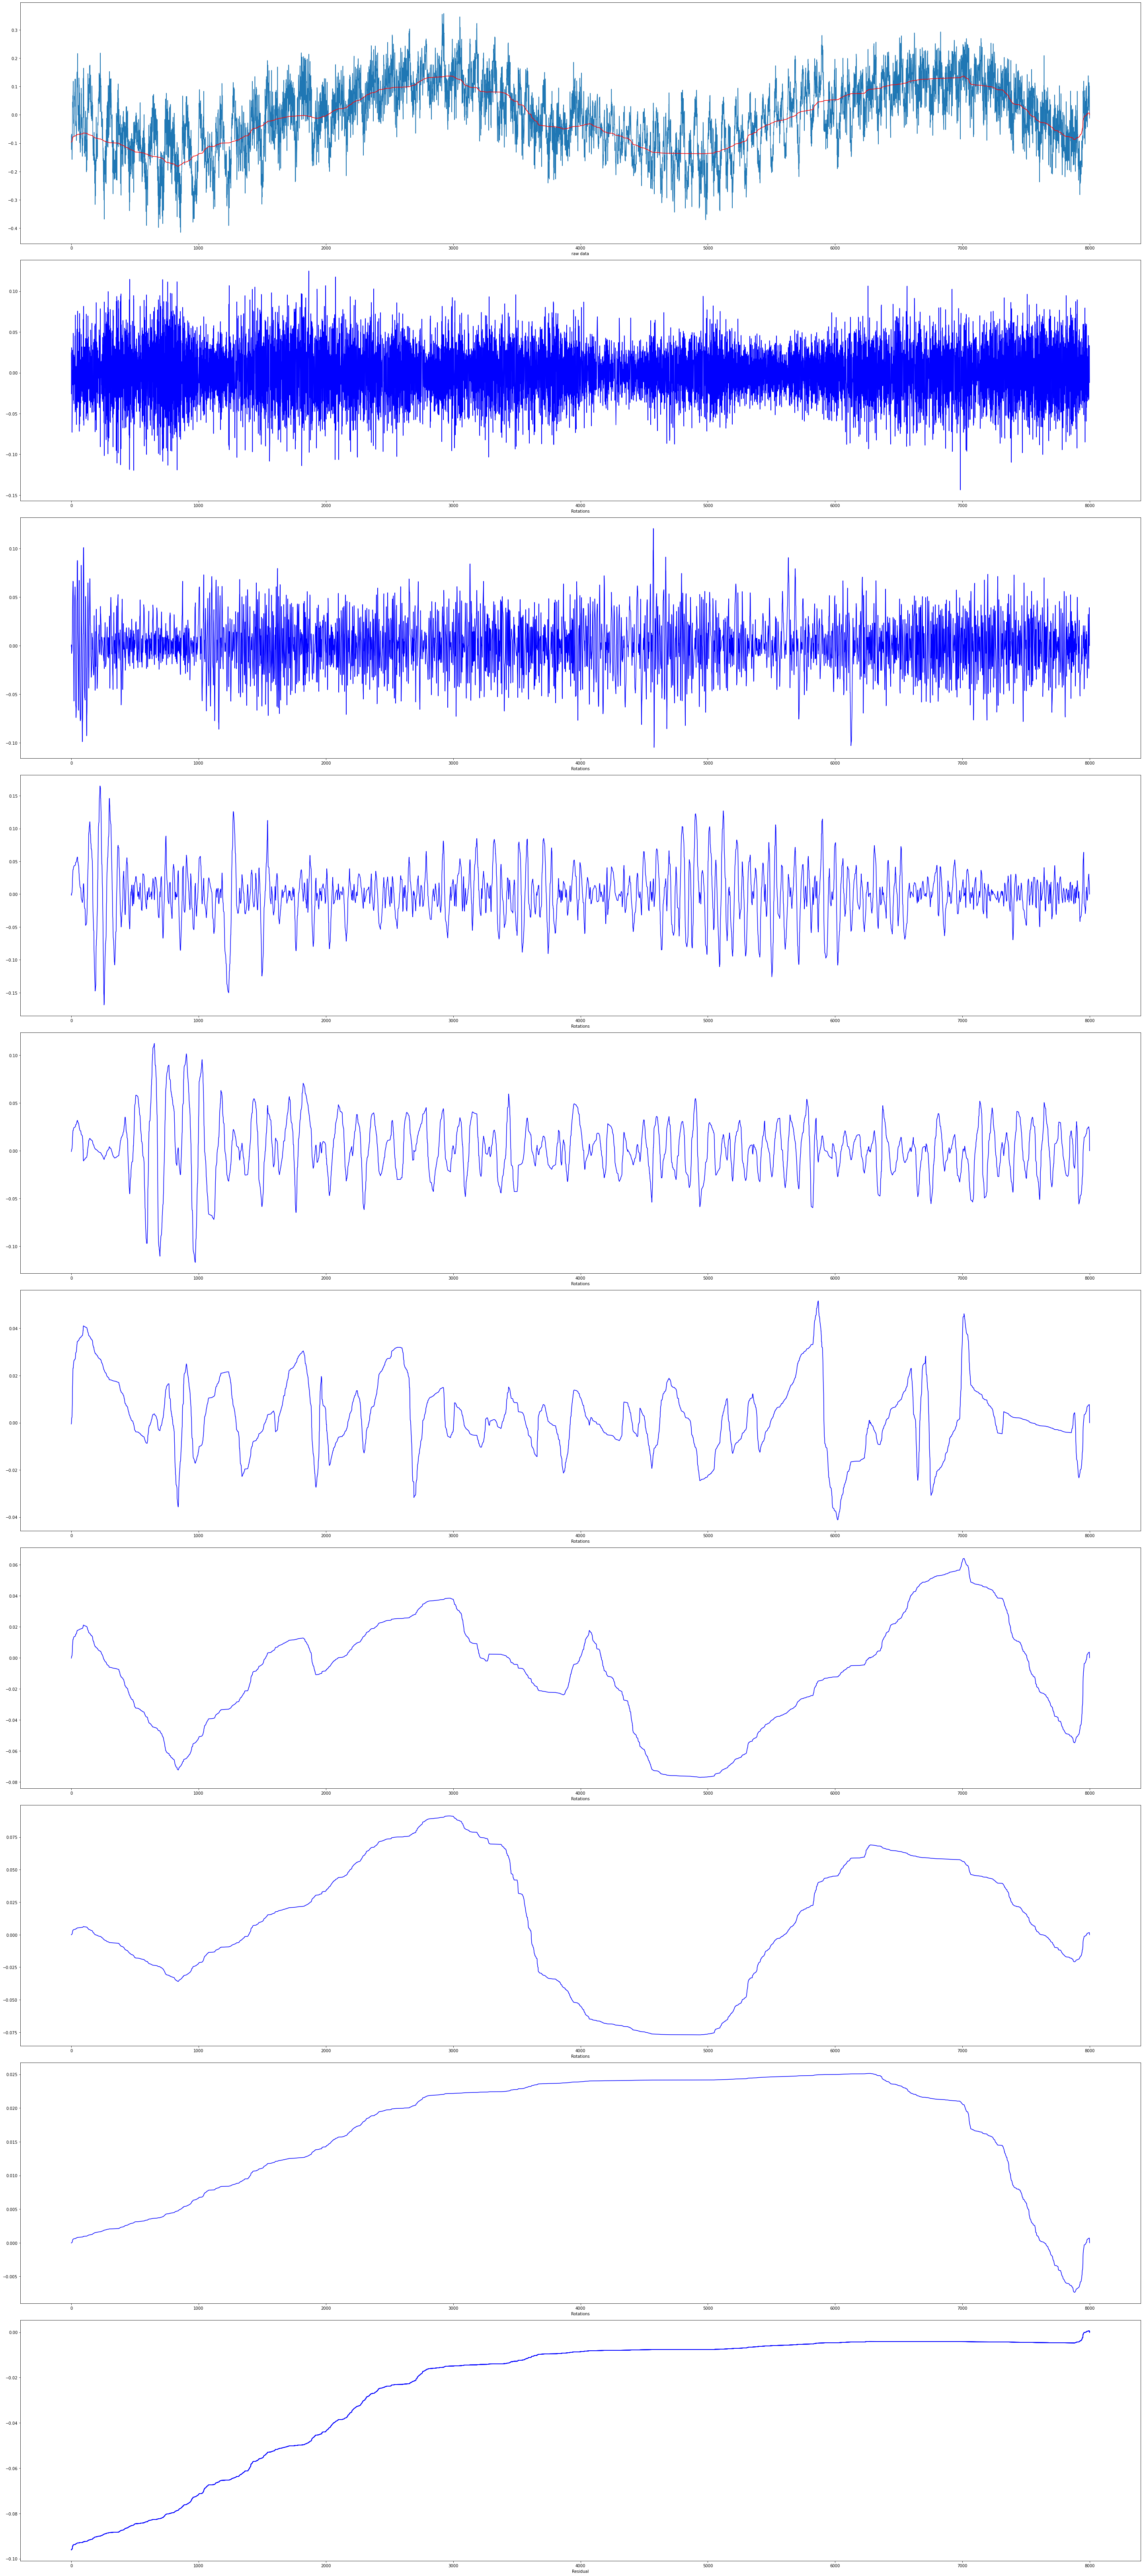

In [19]:
from matplotlib import pyplot as plt
import numpy
import math
itd = ITD()
def shewchuk_sum(a, axis=0):
    '''shewchuck summation of a numpy array.
    '''
    s = numpy.zeros(a.shape[1])
    for i in range(a.shape[1]):
        s[i] = math.fsum(a[:,i])
    return math.fsum(s)

samples = numpy.asarray(inputarray) 

rotations = itd.itd(samples)
baselines = itd.get_baselines()
rows, columns = baselines.shape
diff = abs(numpy.sum(samples) -  (shewchuk_sum(rotations)))
print("difference between input and ITD output after re-combining all values: ", diff)
fig, (ax) = plt.subplots(rows+2,figsize=(40,(rows * 10) + 10))

ax[0].set_xlabel('raw data')
ax[0].plot(samples)
ax[0].plot(baselines[4,:], 'r')
for i in range(rows):
    ax[i+1].set_xlabel('Rotations')
    ax[i+1].plot(rotations[i,:],'b')                             
    ax[-1].set_xlabel('Residual')
    ax[-1].plot(rotations[-1,:],'b')      

plt.tight_layout()                                   
plt.show()

Notes and exerpt quotations from articles around the web:


empirical wavelet transform (EWT) [16] combines aspects of EMD with the wavelet transform. The
main idea behind EWT is to partition the Fourier domain and build empirical wavelet filters from
the segmented spectrum. This is done by identifying local maxima of the amplitude in the Fourier
domain and partitioning the regions to separate the maxima [26]. The EWT was extended to two
dimensions for applications in imaging and can be related to other wavelet-like transforms [17].
https://arxiv.org/pdf/2204.06108.pdf notes from this article


The interesting fact about this algorithm(EMD) is that it is highly
adaptable and is able to extract the non-stationary part of the
original function. However, its main problem is that it is based
on an ad-hoc process which is mathematically difficult to model.
Consequently it is difficult to really understand what the EMD
provides. For example, some problems appear when some noise
is present in the signal. To deal with this problem, an Ensemble
EMD (EEMD) was proposed in [17]. The authors propose to
compute several EMD decompositions of the original signal
corrupted by different artificial noises. Then the final EEMD is
the average of each EMD. This approach seems to stabilize the
obtained decomposition but it increases the computational cost.
https://sci-hub.hkvisa.net/10.1109/TSP.2013.2265222 Emperical Wavelet Transform



VMD has a reconstruction error of only 0.4%, while EEMD and EWT have poor signal
reconstruction. One possible reason for the errors in EEMD and EWT is because these methods
do not guarantee that the sum of the reconstructed intrinsic modes equals the original signal.
In terms of signal decomposition, the VMD and EWT extract the linear trend well (the second
column of the last two rows in Figure 2) while their learned second and third modes agree with the
corresponding ground truth ones on the time interval t ∈ [0, 1] but create a false oscillatory pattern
on the remaining interval t ∈ [1, 2]. This indicates that the decomposition produced by the EWT
and VMD approaches experience a non-trivial amount of mode mixing. The remaining methods
used in this comparison are unable to extract the true mode behaviors.
https://arxiv.org/pdf/2204.06108.pdf SRMD

However, there are currently still many problems in the study of intrinsic time-scale decomposition. Existing research results improved the decomposition of the intrinsic time scale. However, problems such as curve distortion and modal aliasing still need to be further improved. Therefore, in order to further allow for the better application of eigentime-scale decomposition algorithms to the early fault diagnosis of bearings, this paper proposes an intrinsic time-scale decomposition method based on time-varying filtering (TVF-ITD). It is applied to the framework of CEITDAN, improving the noise-reduction effect of intrinsic time-scale decomposition on strong background noise signals in order to improve the effectiveness of early fault diagnosis. And named it as complete ensemble intrinsic time-scale with adaptive white noise based on time-varying filtering (TVF-CEITDAN).
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8069719/ TVF-CEITDAN

An approach based on selecting appropriate wavelet scales, dubbed
synchrosqueezing, was proposed by Daubechies et al. [13],
[20]. They remove unimportant wavelet coefficients (both in
time and scale) by thresholding of the respective signal energy
in that portion. Conversely, locally relevant wavelets are selected as local maxima of the continuous wavelet transform,
that are shown to be tuned with the local signals, and from
which the current instantaneous frequency of each mode can
be recovered.
https://sci-hub.hkvisa.net/10.1109/TSP.2013.2288675 VMDpy




summary conclusion:
TVF-CEITDAN is the state of the art in mode decomposition.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8069719/
Implementing it in python by incorporating/adapting related code from vmdpy, pyemd, and writing original code
remains as future research
